# Interconnect Telecom

## Analysis of client churn rate
The telecom operator Interconnect would like to be able to forecast their churn of clients.  
If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options.  
Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

<br>

## Table of Contents
***
- [Libraries](#Libraries)
- [Parse Datasets](#Parse-Datasets)
    - [Load Files](#Load-Files)
    - [Join Dataframes](#Join-Dataframes)
    - [Conclusions](#Datasets-Conclusions)
- [Data Wrangling](#Data-Wrangling)
    - [Duplicated Entries](#Duplicated-Entries)
    - [Data Types](#Data-Types)
    - [Date Columns](#Date-Columns)
    - [Qualitative Variables](#Qualitative-Variables)
        - [Internet N/A Values](#Internet-N/A-Values)
        - [Phone N/A Values](#Internet-N/A-Values)
    - [Quantitative Variables](#Quantitative-Variables)
        - [TotalCharges N/A Values](#TotalCharges-N/A-Values)
        - [Data Type Optimization](#Data-Type-Optimizations)
    - [Features Engineering](#Features-Engineering)
        - [Tenure](#Tenure)
        - [Churn](#Churn)
        - [Telephone](#Telephone)
        - [Internet](#Internet)
    - [Conclusions](#Wrangling-Conclusions)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Churn Analysis](#Churn-Analysis)
    - [Tenure (months) vs. Qualitative](#Tenure-(months)-vs.-Qualitative)
    - [MonthlyCharges vs. Qualitative](#MonthlyCharges-vs.-Qualitative)
    - [Monthly Payments Distribution](#Monthly-Payments-Distribution)
    - [Type of Services (Internet / Telephone)](#Type-of-Services-(Internet-/-Telephone))
    - [Conclusions](#EDA-Conclusions)


- [Clarifying Questions](#Clarifying-Questions)
- [Work Plan](#Work-Plan)


- [Machine Learning Forecast](#Machine-Learning-Forecast)
    - [Libraries](#ML-Libs)
    - [Features Selection](#Features-Selection)
    - [Train/Test Split](#Train/Test-Split)
    - [Pipeline](#Pipeline)
    - [Metrics](#Metrics)
    - [Execution](#Execution)
    - [Models](#Models)
        - [Baseline (Dummy)](#Baseline---Dummy-Model)
        - [Logistic Regression](#Logistic-Regression)
            - [Scores](#LR-Scores)
        - [Random Forest](#Random-Forest)
            - [Scores](#RF-Scores)
        - [Gradient Boosting](#Gradient-Boosting)
            - [Scores](#GB-Scores)
        - [XGBoost](#XGBoost)
            - [Scores](#XGB-Scores)
        - [LightGBM](#LightGBM)
            - [Scores](#LGBM-Scores)
        - [CatBoost](#CatBoost)
            - [Scores](#CB-Scores)
        - [Conclusions](#ML-Conclusions)
- [Project Conclusions](#Project-Conclusions)
    - [Analysis Conclusions](#Analysis-Conclusions)
    - [Forecasting Conclusions](#Forecasting-Conclusions)
    - [Further Work](#Further-Work)

<br>

## Libraries
***

In [1]:
# !pip install --quiet --user --upgrade pandas matplotlib seaborn scipy sklearn skopt imblearn xgboost lightgbm catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

import warnings
from datetime import timedelta
from functools import reduce
from pprint import pprint
from IPython.display import display, Markdown

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 'png'

plt.style.use('seaborn')
plt.rcParams.update({
    'figure.figsize': (13, 8),
    'figure.titlesize': 'xx-large',
    'axes.titlesize': 'xx-large',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

### Helper Functions

In [4]:
def hide_warnings(func):
    """Wrapper function to hide warnings.

    Args:
        func (Callable): Function to execute.
    """
    
    def wrap(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            return func(*args, **kwargs)
        
    return wrap

In [5]:
def remove_prefix(s, prefix):
    """Removes a predefined prefix from the string.

    Args:
        s (str): String to process.
        prefix (str): Prefix to remove.

    Returns:
        str: Processed string.
    """
    
    return s[len(prefix):] if s.startswith(prefix) else s

<br>

## Parse Datasets
***

Let's explore the files provided by the telecom company:

\- The contract information is valid as of February 1, 2020.

Contract Dataset:

          CustomerID: A unique ID that identifies each customer.
          
           BeingDate: Contract start date.
           
             EndDate: Contract end date.
             
                Type: The contract term of the customer (Month-to-month, One year, Two year).
                
    PaperlessBilling: Indicates if the customer has chosen paperless billing (Yes, No).
    
       PaymentMethod: Indicates how the customer pays their bill (Bank Withdrawal, Credit Card, Mailed Check).
       
      MonthlyCharges: Indicates the customer’s current total monthly charge 
                      for all their services from the company.
                      
        TotalCharges: Indicates the customer’s total charges, 
                      calculated to the end of the quarter specified above.
                      
Internet Dataset:
          
     InternetService: Indicates if the customer subscribes to Internet service 
                      with the company (DSL, Fiber Optic).
                       
      OnlineSecurity: Indicates if the customer subscribes to an additional online security service 
                      provided by the company (Yes, No).
                       
        OnlineBackup: Indicates if the customer subscribes to an additional online backup service 
                      provided by the company (Yes, No).
                       
    DeviceProtection: Indicates if the customer subscribes to an additional device protection plan 
                      for their Internet equipment provided by the company (Yes, No).
                       
         TechSupport: Indicates if the customer subscribes to an additional technical support plan 
                      from the company with reduced wait times (Yes, No).
                       
         StreamingTV: Indicates if the customer uses their Internet service to stream television programing 
                      from a third party provider (Yes, No).
                       
     StreamingMovies: Indicates if the customer uses their Internet service to stream movies 
                      from a third party provider (Yes, No).
                      
Personal Dataset:
    
              Gender: The customer’s gender (Male, Female).
    
       SeniorCitizen: Indicates if the customer is 65 or older (Yes, No).
    
             Partner: Whether the customer has a partner or not (Yes, No).
    
          Dependents: Indicates if the customer lives with any dependents (Yes, No). 
                      Dependents could be children, parents, grandparents, etc.
                   
Phone Dataset:

      Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company (Yes, No).

### Helper Functions

In [6]:
files_path = 'final_provider' # folder containing .csv files

In [7]:
def prepend_path(filename, path=files_path):
    """Attempts to add a predefined path to a filename.

    Args:
        filename (str): File's name.
        path (str, optional): Path to the file. Defaults to pedefined 'files_path'.

    Returns:
        str: Full filename with path.
    """
    
    if '/' in filename:
        return filename
    
    if path:
        if not path.endswith('/'):
            path += '/'
        
        return f'{path}{filename}'
    else:
        return filename

In [8]:
def preview_file(filename, head=2, verbose=False):
    """Prints file's metadata using Unix commands.
    Returns length of file.

    Args:
        filename (str): File's name.
        head (int, optional): Number of file's lines to preview. Defaults to 2.
        verbose (bool, optional): Print headers when True. Defaults to False.

    Returns:
        int: Length of file.
    """
    
    filename = prepend_path(filename)
    
    !file "$filename"
    
    size = !du -h "$filename"
    if size:
        print('Size:', size[0].split()[0])
        
    length = !wc -l "$filename"
    if length:
        length = int(length[0].split()[0])
        print(f'Length: {length:,}')
    
    if verbose:
        print('\nFile head:')
    else:
        print()
    
    !head -n{head+1} "$filename"
    print()
    
    return length

In [9]:
def normalize_name(name):
    """Capitalizes first letter."""

    return name[0].upper() + name[1:]

In [10]:
def parse_dataset(filename, norm_column_names=True):
    """Reads a dataset into a dataframe, and assigns to a global variable ('{filename}_df').

    Args:
        filename (str): File's name.
        norm_column_names (bool, optional): Capitalizes columns' names. Defaults to True.

    Returns:
        pd.DataFrame: Parsed dataframe.
    """
    
    name = filename[:filename.index('.')]
    full_filename = prepend_path(filename)
    
    var_name = f'{name}_df'
    
    globals()[var_name] = pd.read_csv(full_filename)
    
    df = globals()[var_name]
    
    if norm_column_names:
        df.columns = [normalize_name(col) for col in df.columns]
        
    print(f"Parsed '{filename}' into '{var_name}' variable.\n")
    
    return df

In [11]:
def parse_dataset_report(filename, head=2, verbose=False):
    """Composite function to preview a file, 
    parse it to a global variable,
    print resulting dataframe's information 
    and verify the parsing was successfull.

    Args:
        filename (str): File's name.
        head (int, optional): Number of file's lines to preview. Defaults to 2.
        verbose (int, optional): Print headers when True. Defaults to False.

    Returns:
        pd.DataFrame: Parsed dataframe.
    """
    
    display(Markdown(f'#### {filename}'))
        
    print('Metadata:')
    length = preview_file(filename, head=head, verbose=1)
    
    df = parse_dataset(filename)
    
    print('Dataframe head:')
    print(df.head(head))
    
    print('\nDataframe info:')
    df.info(memory_usage='deep')
    print()
    
    if length-1 == len(df):
        print('File and dataframe lengths match,\nParsed successfully.')
    else:
        print('There was a problem while parsing the file.\nFurther inspection required.')
                
    return df

In [12]:
def are_ids_overlapping(datasets):
    """Checks whether unique customer IDs overlap between the different datasets.

    Args:
        datasets (list[pd.DataFrame]): List of dataframes.

    Returns:
        bool: True if there's a full match.
    """
    
    largest_df = max(datasets, key=len)
    
    return np.all([df['CustomerID'].isin(largest_df['CustomerID']).all() 
                   for df in datasets if not df.equals(largest_df)])

### Load Files

In [13]:
!ls -lah "$files_path"

total 2056
drwxr-xr-x@ 6 dani  staff   192B Dec 10 12:41 .
drwxr-xr-x  5 dani  staff   160B Dec 26 18:57 ..
-rw-r--r--@ 1 dani  staff   533K Apr 30  2020 contract.csv
-rw-r--r--@ 1 dani  staff   216K Apr 30  2020 internet.csv
-rw-r--r--@ 1 dani  staff   177K Apr 30  2020 personal.csv
-rw-r--r--@ 1 dani  staff    90K Apr 30  2020 phone.csv


In [14]:
files = !ls "$files_path"

In [15]:
datasets = [parse_dataset_report(file) for file in files]

#### contract.csv

Metadata:
final_provider/contract.csv: ASCII text
Size: 536K
Length: 7,044

File head:
customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5

Parsed 'contract.csv' into 'contract_df' variable.

Dataframe head:
   CustomerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   

      PaymentMethod  MonthlyCharges TotalCharges  
0  Electronic check           29.85        29.85  
1      Mailed check           56.95       1889.5  

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-nu

#### internet.csv

Metadata:
final_provider/internet.csv: ASCII text
Size: 220K
Length: 5,518

File head:
customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No

Parsed 'internet.csv' into 'internet_df' variable.

Dataframe head:
   CustomerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-nul

#### personal.csv

Metadata:
final_provider/personal.csv: ASCII text
Size: 180K
Length: 7,044

File head:
customerID,gender,SeniorCitizen,Partner,Dependents
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No

Parsed 'personal.csv' into 'personal_df' variable.

Dataframe head:
   CustomerID  Gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB

File and dataframe lengths match,
Parsed successfully.


#### phone.csv

Metadata:
final_provider/phone.csv: ASCII text
Size: 92K
Length: 6,362

File head:
customerID,MultipleLines
5575-GNVDE,No
3668-QPYBK,No

Parsed 'phone.csv' into 'phone_df' variable.

Dataframe head:
   CustomerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 785.7 KB

File and dataframe lengths match,
Parsed successfully.


Checking whether the unique customer IDs overlap between the different datasets:

In [16]:
are_ids_overlapping(datasets)

True

UIDs do in fact overlap, which means we can merge the dataframes into a single wide dataframe.

### Join Dataframes

In [17]:
df = reduce(lambda a,b: a.merge(b, on='CustomerID', how='outer'), datasets)

In [18]:
df.head()

CustomerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies  Gender  SeniorCitizen Partner Dependents  \
0          No              No  Female              0     Yes         No   
1          No              No    Male              0      No         No   
2          No              No    Male              0      No         No   
3          No              No    Male              0      No         No   
4          No              No  Female              0      No         No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

In [19]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  Gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


### Conclusions<a id="Datasets-Conclusions"></a>

* All 4 datasets have been successfully loaded, and joined together into a single dataframe,  
with CustomerID as a unique identifier.

* All entries are in fact unique, and there are no overlapping plans for the same users.  

* We can already see some missing values and inappropriate data types,  
all of which will be handled in the next section.

<br>

## Data Wrangling
***

Now that the data is loaded, we can start cleaning it up and also optimize the dataframe while at it.

### Helper Functions

In [20]:
def check_missing_values(df):
    """Reports missing values, in count and percent.

    Args:
        df (pd.DataFrame): Dataframe to inspect.
    """
    
    na = df.isna().sum()
    na = pd.concat([
        na,
        na / len(df)
    ], axis=1, keys=['count', '%']).rename_axis(columns='n/a')
    na = na[na['count'] > 0]
    
    if not na.empty:
        display(na.style.format({'count': '{:,}', '%': '{:.1%}'}))
        total_na = na['count'].sum()
        print('Total {:,.0f} ({:,.1%}) missing values found.'.format(total_na, total_na/df.size))
    else:
        print('No missing values were found.')
    
    
# check_missing_values(pd.DataFrame(dict(col1=['a', 'b', 'c'], col2=[np.NaN, 1, 2])))

In [21]:
def is_all_nans(df, columns):
    """Checks whether all the values are missing, per row."""
    
    return df.loc[df[columns].isna().any(axis=1), columns].isna().all(axis=1).all(axis=0)

In [22]:
def check_duplicates(df, subset=None):
    """Report duplicated entries.

    Args:
        df (pd.DataFrame): Dataframe to inspect.
        subset (list[str], optional): Subset of columns to compare by. Defaults to None.
    """
    
    # display(df)
    
    dup = df.duplicated(subset=subset).sum()
    if dup:
        print('Total {:,.0f} ({:,.1%}) duplicated entries found.'.format(dup, dup/len(df)))
    else:
        print('No duplicated entries were found.')

        
# check_duplicates(pd.DataFrame(dict(col1=['a', 'b', 'b'], col2=[np.NaN, 1, 2])), subset='col1')

In [23]:
def value_counts(df, dropna=False):
    """Reports value counts (with percent).

    Args:
        df (pd.DataFrame): Dataframe to inspect.
        dropna (bool, optional): Removes empty entries. Defaults to False.
    """
    
    display(pd.concat([
        df.value_counts(dropna=dropna),
        df.value_counts(dropna=dropna, normalize=True)
    ], axis=1, keys=['count', '%']).style.format({'count': '{:,}', '%': '{:.1%}'}))

### Duplicated Entries

In [24]:
check_duplicates(df, subset='CustomerID')

No duplicated entries were found.


### Data Types

In [25]:
df.dtypes

CustomerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
MultipleLines        object
dtype: object

In [26]:
df.describe()

MonthlyCharges  SeniorCitizen
count     7043.000000    7043.000000
mean        64.761692       0.162147
std         30.090047       0.368612
min         18.250000       0.000000
25%         35.500000       0.000000
50%         70.350000       0.000000
75%         89.850000       0.000000
max        118.750000       1.000000

In [27]:
df.describe(include='O')

CustomerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77       5               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5174            3875             4171   

           PaymentMethod TotalCharges InternetService OnlineSecurity  \
count               7043         7043            5517           5517   
unique                 4         6531               2              2   
top     Electronic check                  Fiber optic             No   
freq                2365           11            3096           3498   

       OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
count          5517             5517        5517        5517            5517   
unique            2                2           2           2               2   
top              No               No          No          No              No   
freq           3088             3095        3473        2810            2785   

       Gender Partner Dependents MultipleLines  
count    7043    7043       7043          6361  
unique      2       2          2             2  
top      Male      No         No            No  
freq     3555    3641       4933          3390

In [28]:
df.select_dtypes('O').apply(lambda x:x.str.isspace().sum())

CustomerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
TotalCharges        11
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Gender               0
Partner              0
Dependents           0
MultipleLines        0
dtype: int64

A few observations:
- 'SeniorCitizen' is actually a boolean variable.  
We'll replace values with 'Yes / No' for uniformity, same as the other boolean columns.
- Convert 'BeginDate' and 'EndDate' to datetime.  
- 'TotalCharges' is actually a quantitative column,  
and should be converted together with 'MonthlyCharges' to int type - since we don't need floating-point precision.  
It also has 11 blank entries.

### Date Columns

Converting dates to the appropriate dtype 'datetime'.

In [29]:
df['BeginDate'].head()

0    2020-01-01
1    2017-04-01
2    2019-10-01
3    2016-05-01
4    2019-09-01
Name: BeginDate, dtype: object

In [30]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['BeginDate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

In [31]:
df['EndDate'].head()

0                     No
1                     No
2    2019-12-01 00:00:00
3                     No
4    2019-11-01 00:00:00
Name: EndDate, dtype: object

In [32]:
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['EndDate'].head()

0          NaT
1          NaT
2   2019-12-01
3          NaT
4   2019-11-01
Name: EndDate, dtype: datetime64[ns]

In [33]:
df.describe(include='datetime', datetime_is_numeric=True)

BeginDate                        EndDate
count                           7043                           1869
mean   2017-04-30 13:01:50.918642688  2019-11-15 21:31:18.009630976
min              2013-10-01 00:00:00            2019-10-01 00:00:00
25%              2015-06-01 00:00:00            2019-11-01 00:00:00
50%              2017-09-01 00:00:00            2019-11-01 00:00:00
75%              2019-04-01 00:00:00            2019-12-01 00:00:00
max              2020-02-01 00:00:00            2020-01-01 00:00:00

### Qualitative Variables

In [34]:
df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace=True)

In [35]:
check_missing_values(df.select_dtypes('O'))

Total 11,364 (9.5%) missing values found.


#### Internet N/A Values

In [36]:
internet_columns = internet_df.columns.drop('CustomerID')

In [37]:
is_all_nans(df, columns=internet_columns)

True

All of the internet related column values that are missing, are packed together,  
it stands to reason that these values are missing since they are irrelevant for these customers,  
probably because said customers don't have internet services enabled.

In [38]:
value_counts(df['InternetService'])

We will fill all irrelevant internet packages with a placeholder 'N/A':

In [39]:
df['InternetService'].fillna('N/A', inplace=True)
value_counts(df['InternetService'])

In [40]:
for column in internet_columns.drop('InternetService'):
    df[column].fillna('N/A', inplace=True)

In [41]:
value_counts(df['OnlineSecurity'])

#### Phone N/A Values

In [42]:
value_counts(df['MultipleLines'])

Let's check the correlation of 'MultipleLines' to other variables:

In [43]:
df.apply(lambda x : pd.factorize(x)[0]).corr()['MultipleLines'].sort_values()

PaperlessBilling   -0.133255
OnlineBackup       -0.130619
Partner            -0.117307
OnlineSecurity     -0.066844
TechSupport        -0.066684
CustomerID         -0.023091
Dependents         -0.019657
DeviceProtection   -0.013069
Gender             -0.009451
TotalCharges        0.015373
MonthlyCharges      0.024338
PaymentMethod       0.025676
EndDate             0.026335
StreamingMovies     0.028187
StreamingTV         0.030195
BeginDate           0.068870
Type                0.083343
SeniorCitizen       0.113791
InternetService     0.186826
MultipleLines       1.000000
Name: MultipleLines, dtype: float64

There appears to be no correlation between 'MultipleLines' and any other variables.  
The missing values are probably MCAR - Missing completely at random, with no systematic relationship.

For python ML libraries to work correctly, we'll have to fill in the value -  
so we will fill in using a placeholder 'N/A'.

In [44]:
df['MultipleLines'].fillna('N/A', inplace=True)

### Quantitative Variables

#### TotalCharges N/A Values

In [45]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce', downcast='float')

In [46]:
df.describe(include='number')

MonthlyCharges  TotalCharges
count     7043.000000   7032.000000
mean        64.761692   2283.300537
std         30.090047   2266.771484
min         18.250000     18.799999
25%         35.500000    401.450012
50%         70.350000   1397.475098
75%         89.850000   3794.737549
max        118.750000   8684.799805

In [47]:
check_missing_values(df.select_dtypes('number'))

Total 11 (0.1%) missing values found.


In [48]:
df[df['TotalCharges'].isna()].head()

CustomerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01     NaT  Two year              Yes   
753   3115-CZMZD 2020-02-01     NaT  Two year               No   
936   5709-LVOEQ 2020-02-01     NaT  Two year               No   
1082  4367-NUYAO 2020-02-01     NaT  Two year               No   
1340  1371-DWPAZ 2020-02-01     NaT  Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
488   Bank transfer (automatic)           52.55           NaN             DSL   
753                Mailed check           20.25           NaN             N/A   
936                Mailed check           80.85           NaN             DSL   
1082               Mailed check           25.75           NaN             N/A   
1340    Credit card (automatic)           56.05           NaN             DSL   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
488             Yes           No              Yes         Yes         Yes   
753             N/A          N/A              N/A         N/A         N/A   
936             Yes          Yes              Yes          No         Yes   
1082            N/A          N/A              N/A         N/A         N/A   
1340            Yes          Yes              Yes         Yes         Yes   

     StreamingMovies  Gender SeniorCitizen Partner Dependents MultipleLines  
488               No  Female            No     Yes        Yes           N/A  
753              N/A    Male            No      No        Yes            No  
936              Yes  Female            No     Yes        Yes            No  
1082             N/A    Male            No     Yes        Yes           Yes  
1340              No  Female            No     Yes        Yes           N/A

Entries with missing 'TotalCharges' were added the same day that the snapshot of the data was taken,  
thus, it can be filled with 0s.

In [49]:
df['TotalCharges'].fillna(0, inplace=True)

In [50]:
check_missing_values(df.select_dtypes('number'))

No missing values were found.


#### Data Type Optimization

In our case, we don't need floating-point precision for the quantitative columns,  
so we will convert them to integer dtype.

In [51]:
df[df.select_dtypes('number').columns] = df.select_dtypes('number').astype(int).apply(pd.to_numeric, downcast='integer')

In [52]:
df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   MonthlyCharges  7043 non-null   int8 
 1   TotalCharges    7043 non-null   int16
dtypes: int16(1), int8(1)
memory usage: 75.7 KB


### Features Engineering

We'll create a few new features:

#### Tenure
Indicates the total amount of months that the customer has been with the company (until February 1st, 2020).

In [53]:
end_date = df['EndDate'].max() + pd.DateOffset(months=1)
end_date

Timestamp('2020-02-01 00:00:00')

In [54]:
df['Tenure'] = (end_date - df['BeginDate']) / np.timedelta64(1, 'M')
df['Tenure'].head()

0     1.018501
1    34.037660
2     4.041151
3    45.044046
4     5.026797
Name: Tenure, dtype: float64

#### Churn
Indicates whether the customer has left the company.

In [55]:
df['Churn'] = ~df['EndDate'].isna()
df['Churn'].head()

0    False
1    False
2     True
3    False
4     True
Name: Churn, dtype: bool

#### Telephone
Indicates whether the customer is subscribed to telephony services.

In [56]:
df['Telephone'] = df['MultipleLines'] != 'N/A'

#### Internet
Indicates whether the customer is subscribed to telephony services.

In [57]:
df['Internet'] = df['InternetService'] != 'N/A'

In [58]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   int8          
 7   TotalCharges      7043 non-null   int16         
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

### Conclusions<a id="Wrangling-Conclusions"></a>

* Dates missing values can be ignored, since they won't be used for the forecast models.

* TotalCharges missing values were filled with 0, since those customers were new and hadn't paid yet.  

* All other missing values were of different internet services,  
and filled in with a placeholder 'N/A' - since the missing values in this case represent irrelevant customers,  
who aren't subscribed to internet services at all.

<br>

## Exploratory Data Analysis
***

Conducting EDA to find relationships between the features, which might be helpful later on when working on the forecasting model.

First we'll categorize the different types of features, for the convenice of plotting functions:

In [59]:
quantitative = ['Tenure', 'MonthlyCharges', 'TotalCharges']

In [60]:
qualitative = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 
               'Telephone', 'Internet']

In [61]:
internet_services = internet_columns.drop('InternetService')

Although 'Churn' is qualitative, we'll leave it out of the list since we'll be using it as a dimension for comparison.

### Helper Functions

In [62]:
def stats(df, transpose=True, skewness=True, kurtosis=True, order=[True, False]):
    """Generate descriptive statistics.

    Args:
        df (pd.DataFrame): Dataframe to analyze.
        transpose (bool, optional): Transposes the resulting. Defaults to True.
        skewness (bool, optional): Skewness levels. Defaults to True.
        kurtosis (bool, optional): Kurtosis levels. Defaults to True.
        order (list, optional): Reorders resulting columns. Defaults to [True, False].

    Returns:
        pd.DataFrame: Dataframe which contains relevant statistics.
    """
    
    desc = df.describe()
    
    if transpose:
        desc = desc.T
    
    if skewness:
        desc = desc.append(df.skew().rename('skewness'))
        
    if kurtosis:
        desc = desc.append(df.apply(lambda x:x.kurtosis()).rename('kurtosis'))
        
    if order:
        desc = desc.reindex(columns=order)
        
    return desc

In [63]:
def plot_monthly_charges_dist(groups, order=[True, False], 
                              titles=['Past Customers', 'Current Customers'], 
                              alt_color=sns.color_palette()[1]):
    """Plots a 2x2 plot, with histograms and boxplots.
    Compares Monthly Charges w.r.t. Churn.

    Args:
        groups (pd.DataFrameGroupBy): Grouped Dataframe object.
        order (list, optional): Order of plots. Defaults to [True, False] (Churn values).
        titles (list, optional): Title of plot columns. Defaults to ['Past Customers', 'Current Customers'].
        alt_color (matplotlib.colors.Colormap, optional): Secondary color. Defaults to sns.color_palette()[1].
    """
    
    _, axes = plt.subplots(2, 2, sharey='row')
    plt.suptitle('Monthly Charges Distribution of Past and Current Customers\n')
    
    for i, (name, group) in enumerate(monthly_charges_by_churn):
        column = order.index(name) if order else i
        # print(name, column)
        
        sns.histplot(x=group, ax=axes[0][column], color=sns.color_palette()[column], kde=True)
        sns.boxplot(x=group, ax=axes[1][column], color=sns.color_palette()[column])

    for i, title in enumerate(titles):
        axes[0][i].set_title(title)
        
    for ax in axes[0]:
        ax.set_xlabel('')
        
    axes[1][0].yaxis.set_ticks([])
    # axes[1][1].spines['left'].set_visible(False)

    plt.tight_layout()

In [64]:
def compare_dist_ks_test(sample1, sample2, alpha=.05):
    """Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.

    Args:
        sample1 (array_like): First sample observation.
        sample2 (array_like): Second sample observation.
        alpha (float, optional): Statistical significance threshold. Defaults to .05.
    """
    
    res = ks_2samp(sample1, sample2)
    print(res, '\n')
    
    print('Significance threshold (alpha): ', alpha)
    
    is_below = res.pvalue < alpha
    print('Is alternative hypothesis statistically significant (pvalue < alpha)?\n', is_below, '\n')
    
    confidence = 1 - alpha
    if is_below:
        print(f"Reject null hypothesis, distributions are different (with {confidence:.0%} confidence).")
    else:
        print(f"Can't reject null hypothesis, distributions are similar (with {confidence:.0%} confidence).")

In [65]:
# simple form of a pie plot, left as reference.

# def plot_share(series, labels):
#     """Plots a pie chart, depicting shares of different groups."""
    
#     count = series.value_counts()
#     plt.pie(count, explode=[0, .1], labels=labels, autopct='%.f%%')


# plot_share(df['MultipleLines'] != 'N/A', labels=['Telephone subscribers', 'non-subscribers'])
# plot_share(df['InternetService'] != 'N/A', labels=['Internet subscribers', 'non-subscribers'])

In [66]:
def plot_telephone_pie():
    """Plots a pie chart, depicting share of telephone services customers."""
    
    autopct = lambda p:f'{p:.2f}%\n{p*sum(count)/100:,.0f}'
    
    count = df['Telephone'].value_counts()
    # print(count)
    
    growth_dict = {col: df.loc[(df[col] == 'Yes') & (df['MultipleLines'] == 'No'), 'CustomerID'].values for col in ['Dependents', 'Partner']}
    growth_by_cat = pd.Series({k: len(v) for k,v in growth_dict.items()}, name='Growth Potential by Family Members without Telephone service')
    
    growth_unique_customers = np.unique(np.concatenate([v for v in growth_dict.values()]))
    growth_count = len(growth_unique_customers)
    # print('unique growth users:', growth_count)

    growth = count.copy()
    growth[True] -= growth_count
    growth['Growth'] = growth_count
    
    indices = growth.index.tolist()
    indices = [*indices, # move True, False to end
               indices.pop(indices.index(True)), 
               indices.pop(indices.index(False))] 
    growth = growth.reindex(indices)
    
    size = 0.3
    _, ax = plt.subplots(figsize=(13, 10))
    plt.suptitle('Telephony Users Ratio', y=.86)

    inner = ax.pie(count, 
                   radius=1-size, 
                   autopct=autopct, # '%.1f%%',
                   labels=['Telephone subscribers', 'Non-subscribers'],
                   labeldistance=1.3,
                   pctdistance=0.78,
                   wedgeprops=dict(width=size, edgecolor='w'))
    
    outer = ax.pie(growth, 
                   radius=1,
                   autopct=autopct, # '%.1f%%',
                   labels=['Family members without our telephone service', '', ''],
                   pctdistance=0.85,
                   wedgeprops=dict(width=size, edgecolor='w'))
    
    # hide outer wedges
    outer[0][-2].set_alpha(0)
    outer[0][-1].set_alpha(0)
    
    # hide outer autopct
    outer[2][-2].set_visible(False)
    outer[2][-1].set_visible(False)
    
    plt.show()
    
    print(growth_by_cat, '\n')

In [67]:
def plot_internet_pie():
    """Plots a pie chart, depicting share of internet services customers."""
    
    autopct = lambda p:f'{p:.2f}%\n{p*sum(count)/100:,.0f}'
    
    count = df['Internet'].value_counts()
    # print(count)
    
    cols = internet_columns.drop('InternetService')
    # print(cols)
    
    growth_dict = {col: df.loc[df[col] == 'No', 'CustomerID'].values for col in cols}
    growth_by_service = pd.Series({k: len(v) for k,v in growth_dict.items()}, name='Growth Potential by Service')
    
    growth_unique_customers = np.unique(np.concatenate([v for v in growth_dict.values()]))
    growth_count = len(growth_unique_customers)
    # print('unique growth users:', growth_count)

    growth = count.copy()
    growth[True] -= growth_count
    growth['Growth'] = growth_count
    
    indices = growth.index.tolist()
    indices = [*indices, # move True, False to end
               indices.pop(indices.index(True)), 
               indices.pop(indices.index(False))] 
    growth = growth.reindex(indices)
    
    size = 0.3
    _, ax = plt.subplots(figsize=(13, 10))
    plt.suptitle('Internet Users Ratio', y=.86)

    inner = ax.pie(count, 
                   radius=1-size, 
                   autopct=autopct, # '%.1f%%',
                   labels=['Internet subscribers', 'Non-subscribers'],
                   labeldistance=0.3,
                   pctdistance=0.78,
                   wedgeprops=dict(width=size, edgecolor='w'))
    
    outer = ax.pie(growth, 
                   radius=1,
                   autopct=autopct, # '%.1f%%',
                   labels=['Customers lacking at least 1 internet service', '', ''],
                   pctdistance=0.85,
                   wedgeprops=dict(width=size, edgecolor='w'))
    
    # hide outer wedges
    outer[0][-2].set_alpha(0)
    outer[0][-1].set_alpha(0)
    
    # hide outer autopct
    outer[2][-2].set_visible(False)
    outer[2][-1].set_visible(False)
    
    plt.show()
    
    print(growth_by_service, '\n')

### Analysis

#### Churn Analysis

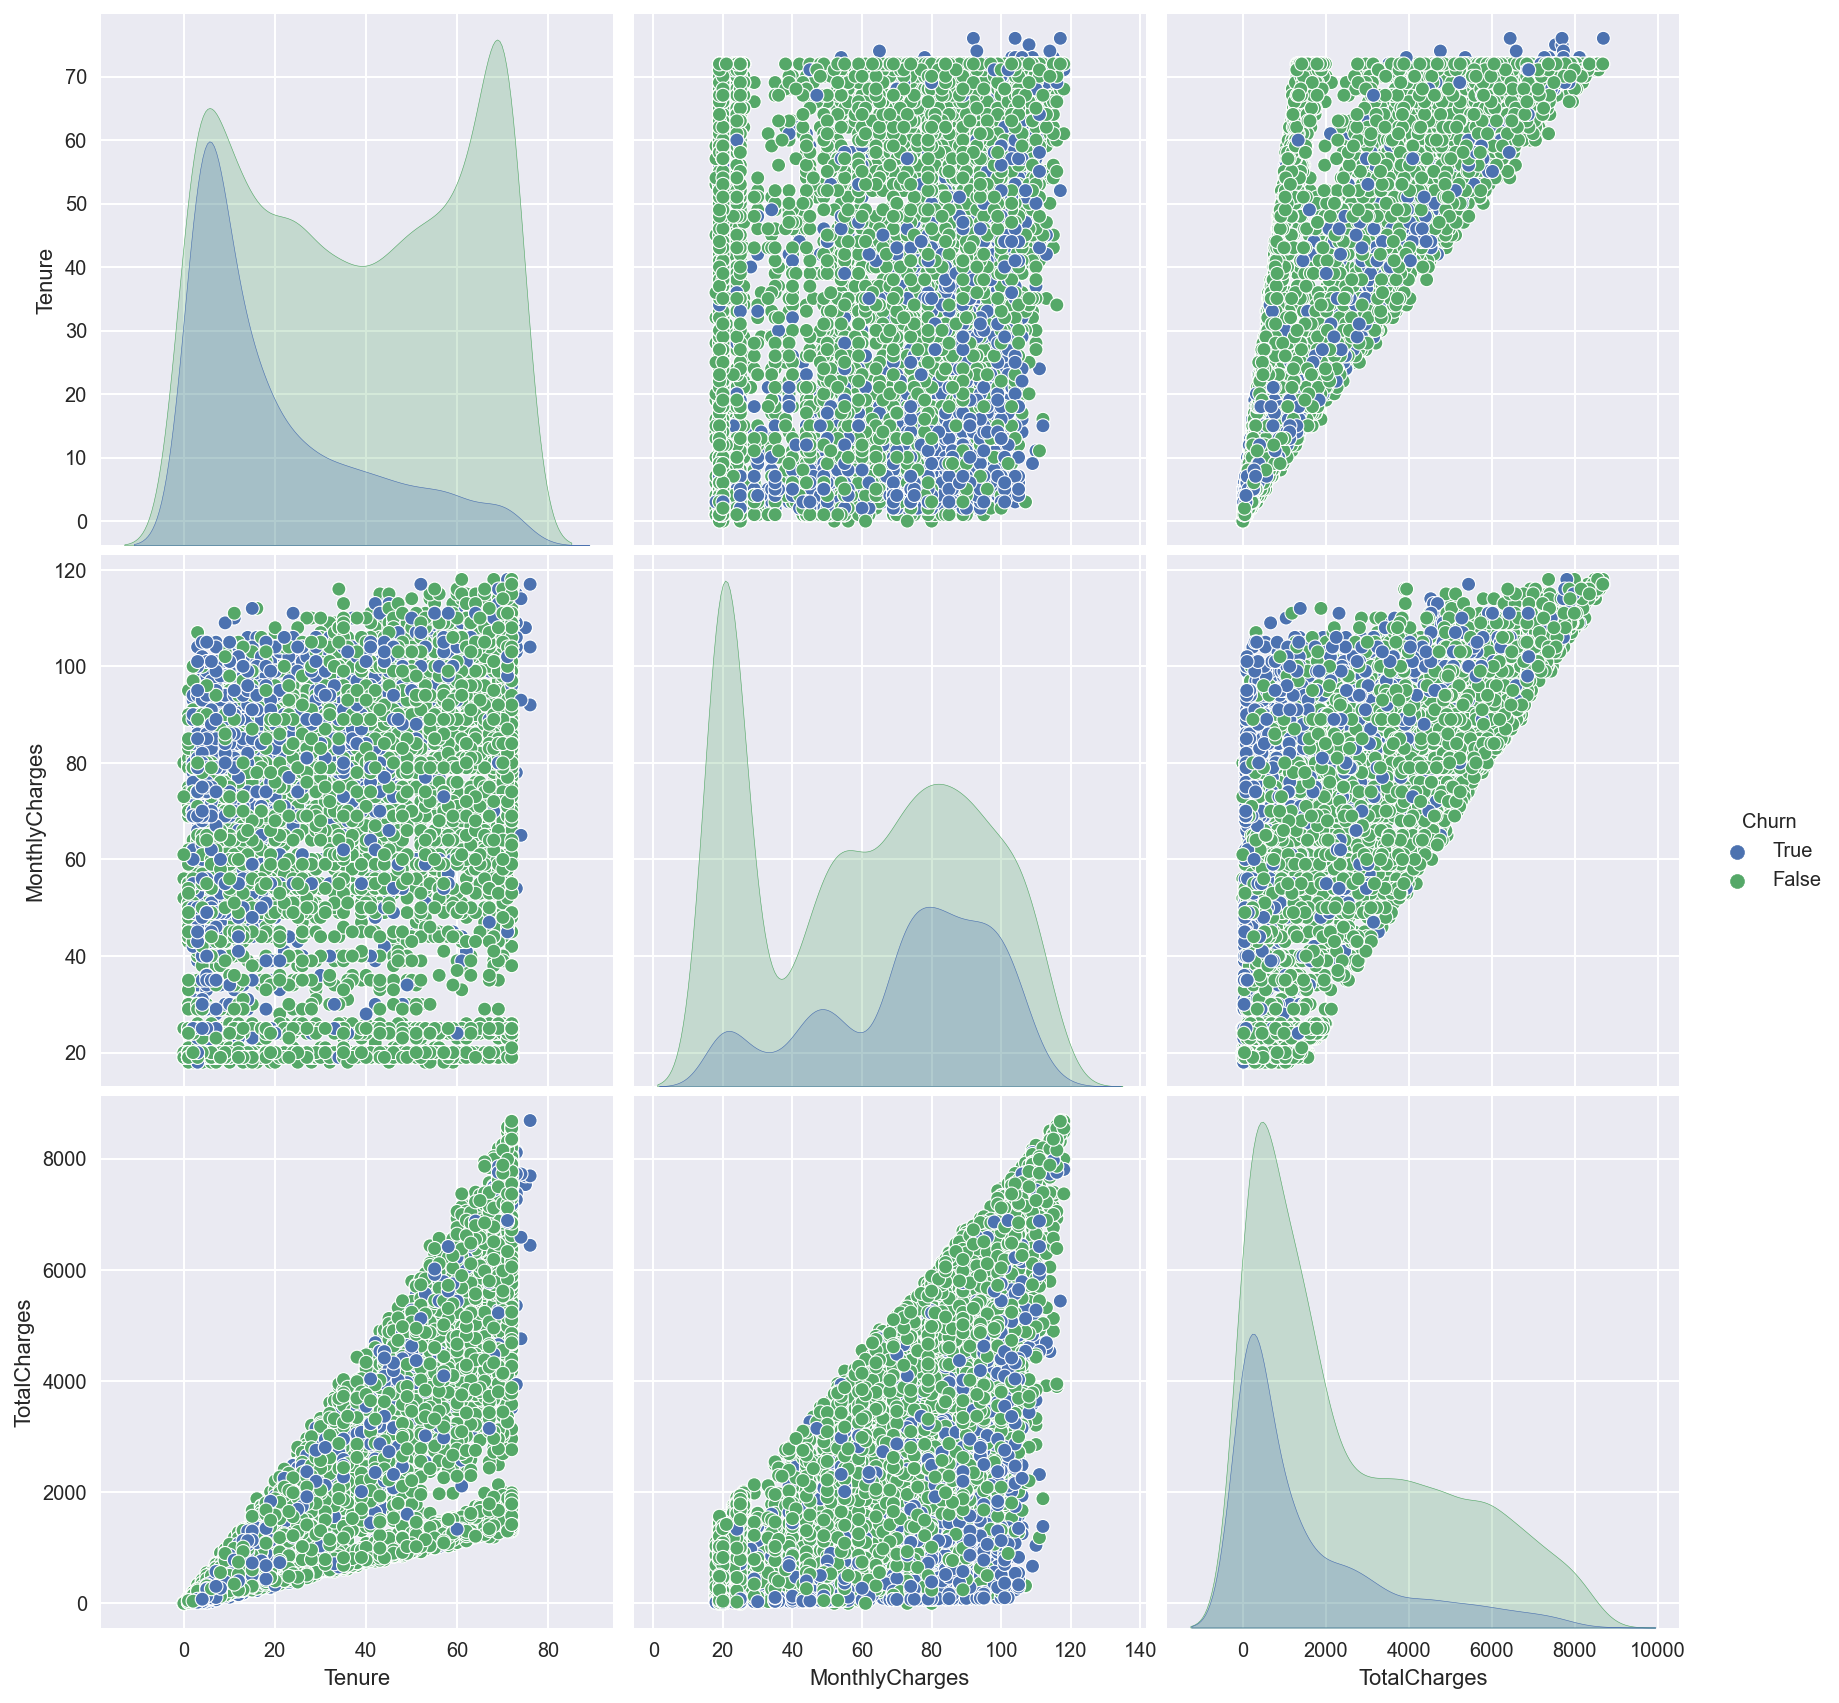

In [68]:
sns.pairplot(df[[*quantitative, 'Churn']], hue='Churn', hue_order=[True, False], height=4);

Pairplot does not offer any straight-forward insights in our case.  
We can see the distributions of MonthlyCharges and TotalCharges between past and current customers is roughly the same.

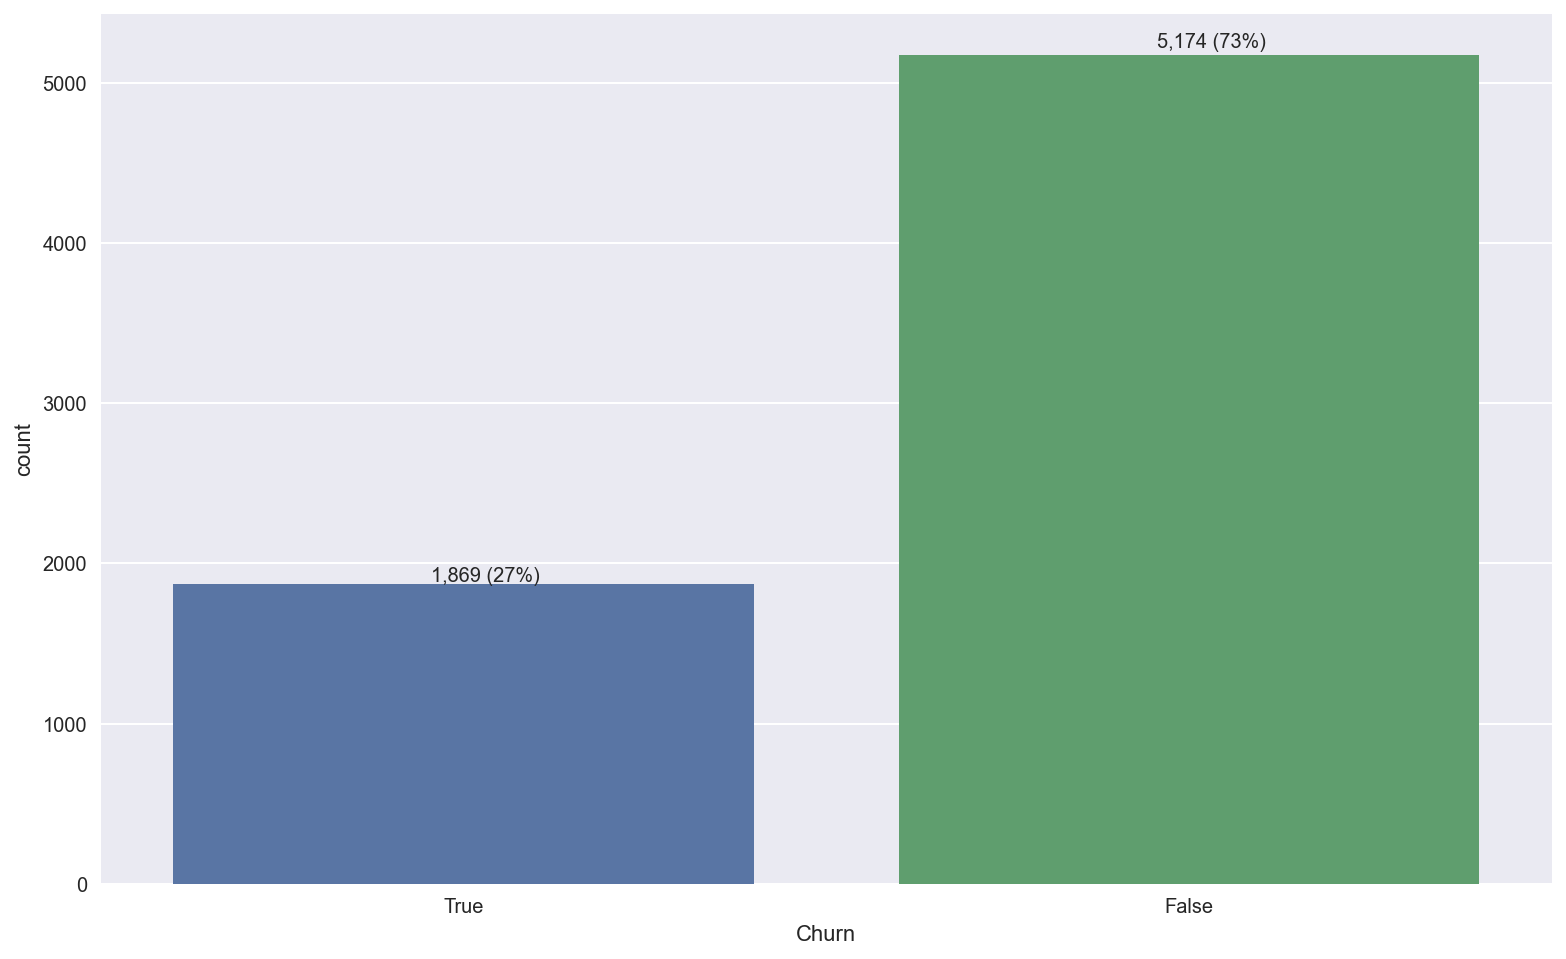

In [69]:
ax = sns.countplot(x='Churn', data=df, order=[True, False])
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.25, height*1.01, '{:,} ({:.0%})'.format(height, height/len(df)))

'Churn' displays a strong class imbalance (roughly 1:3) of past to current customers.

#### Tenure (months) vs. Qualitative

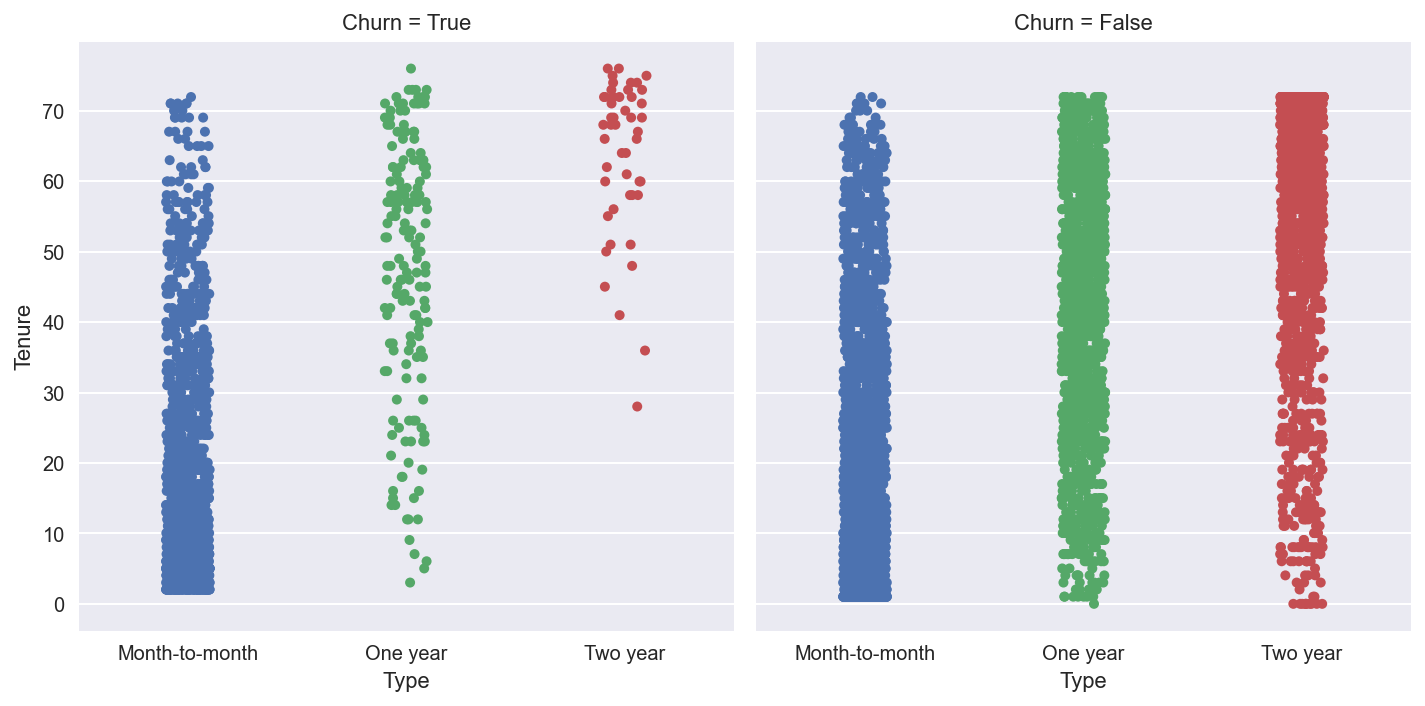

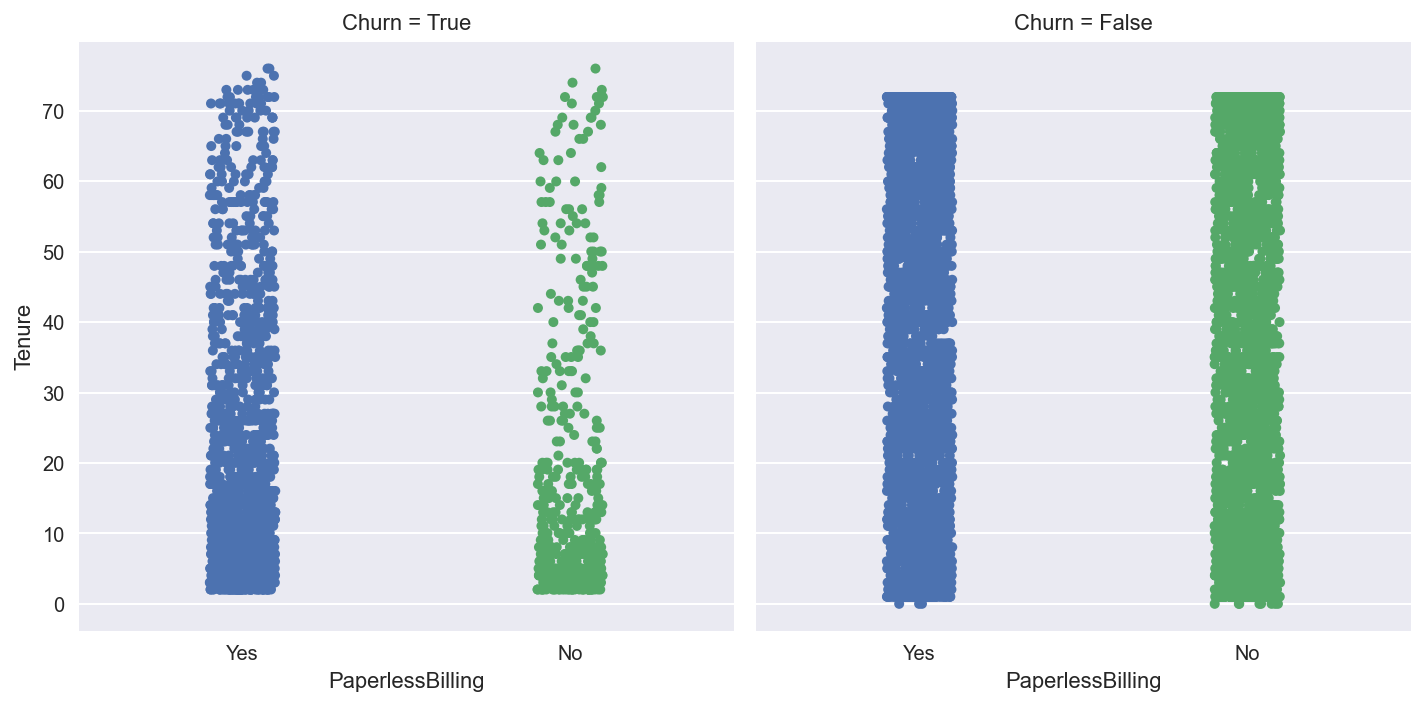

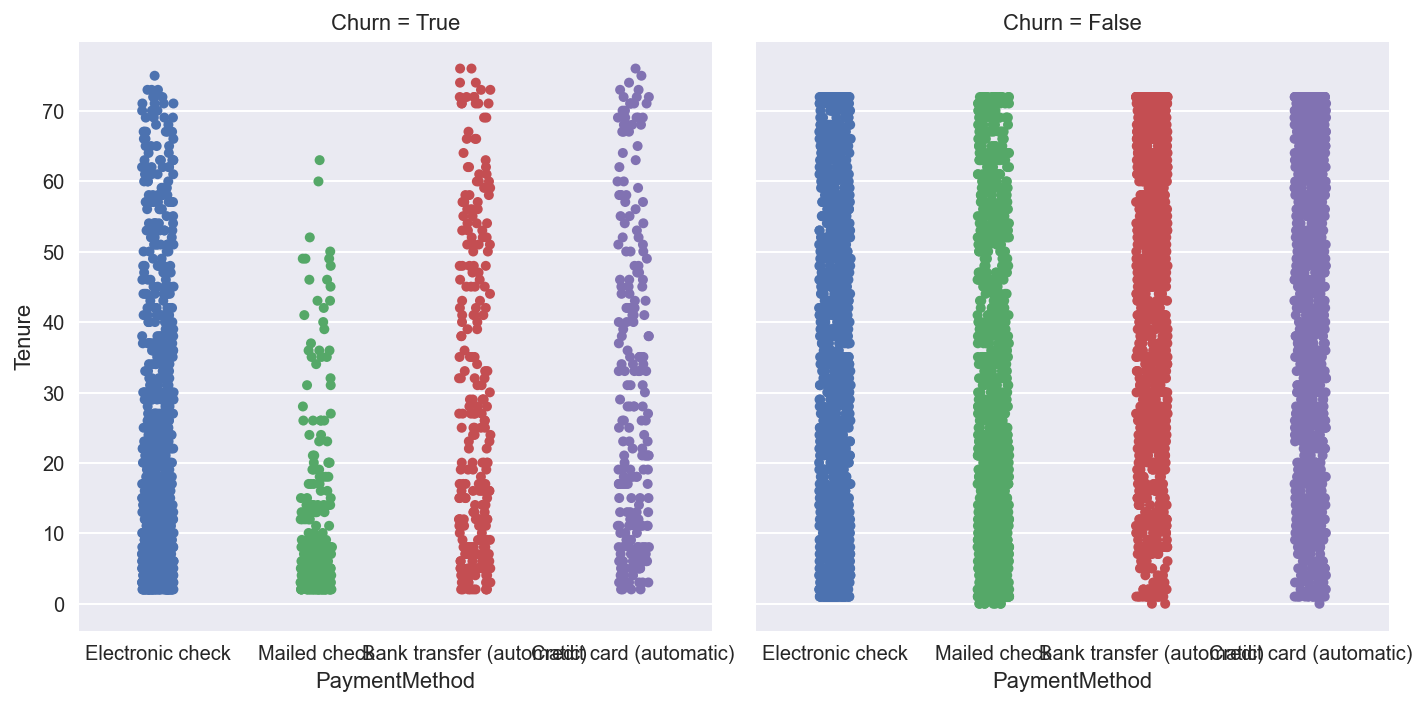

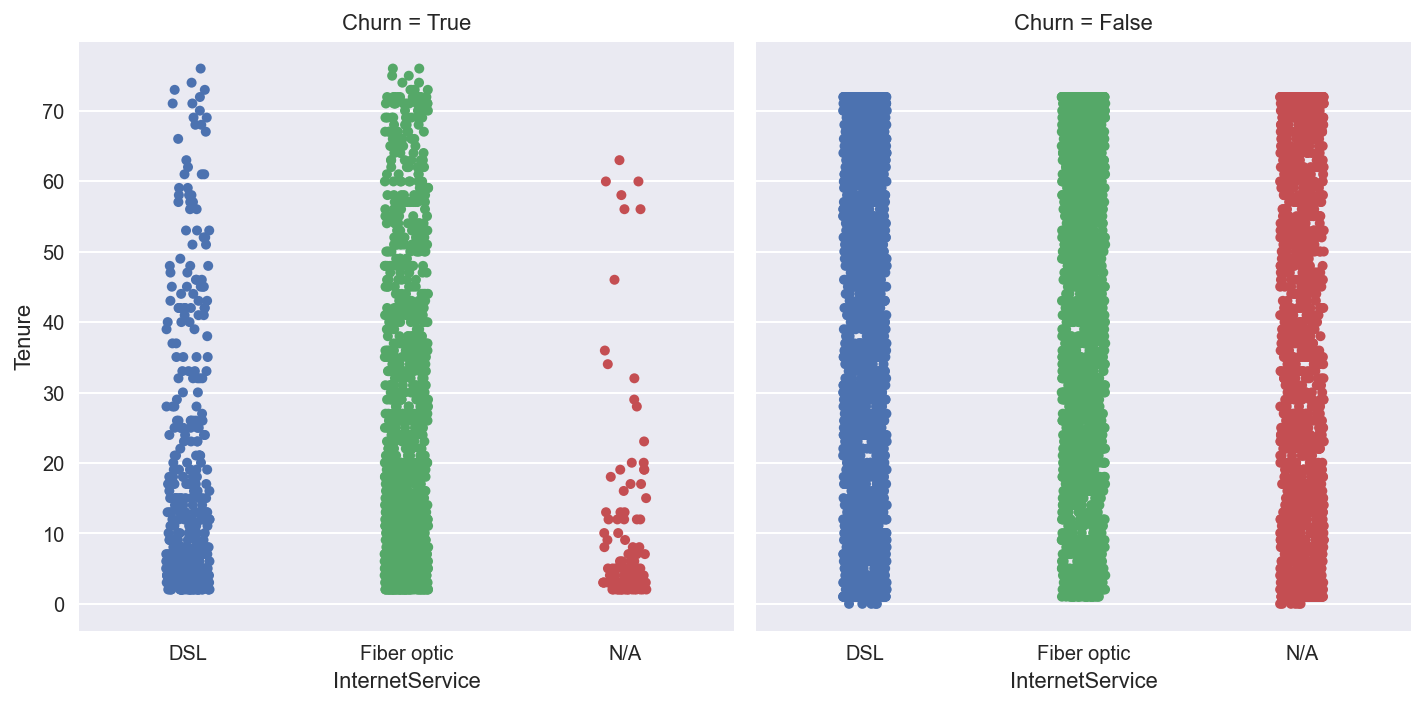

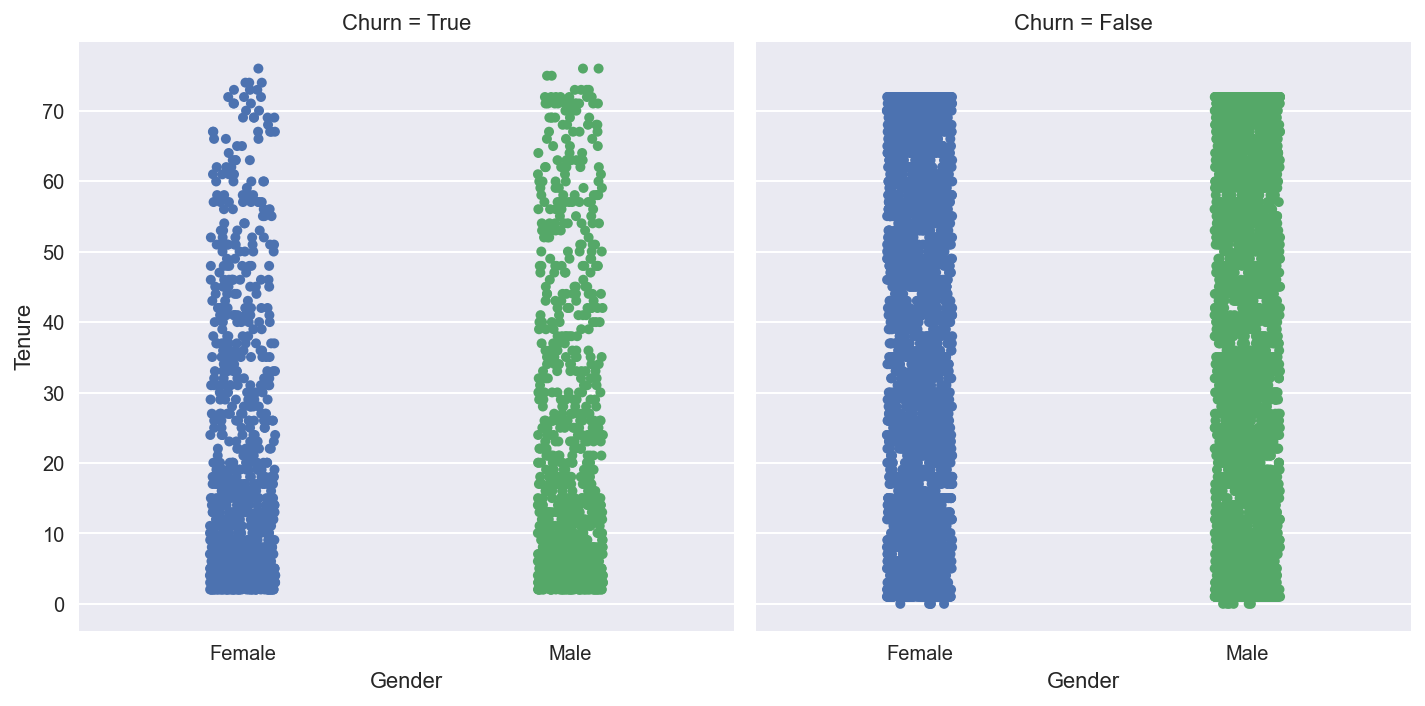

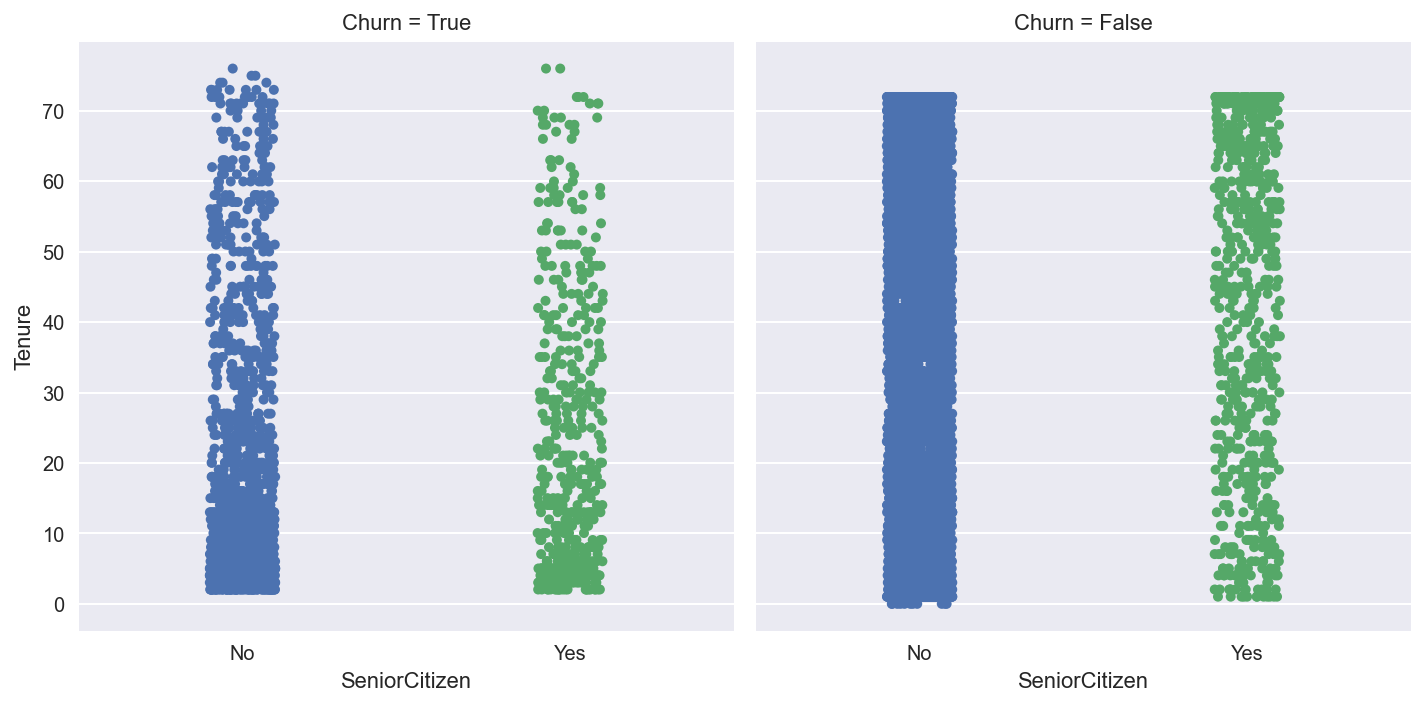

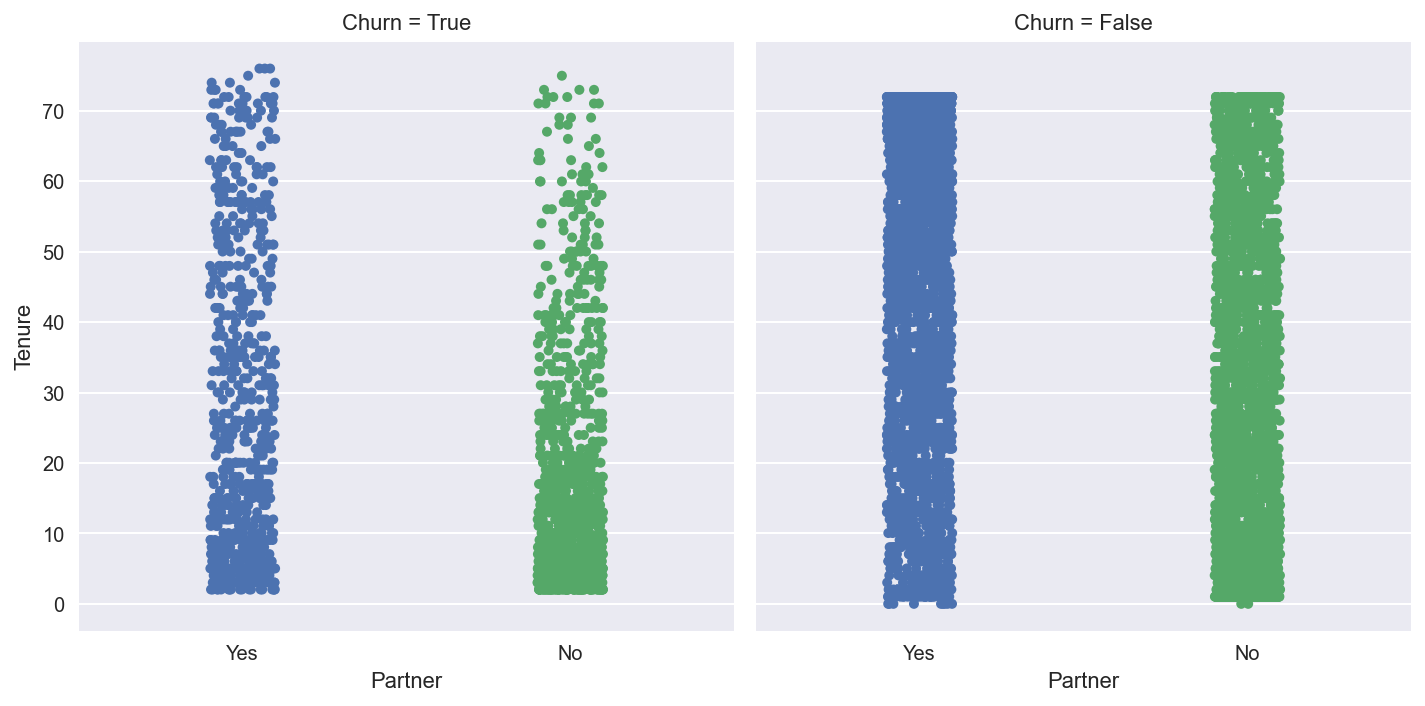

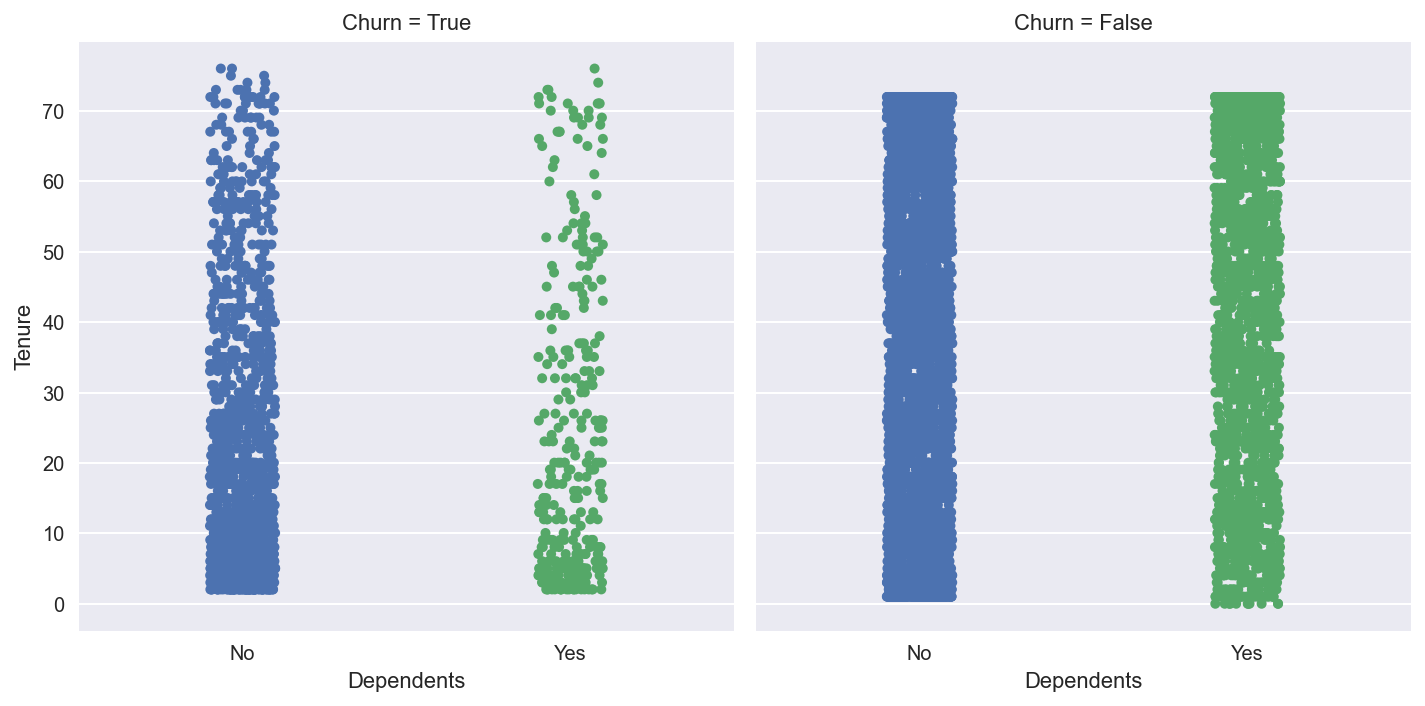

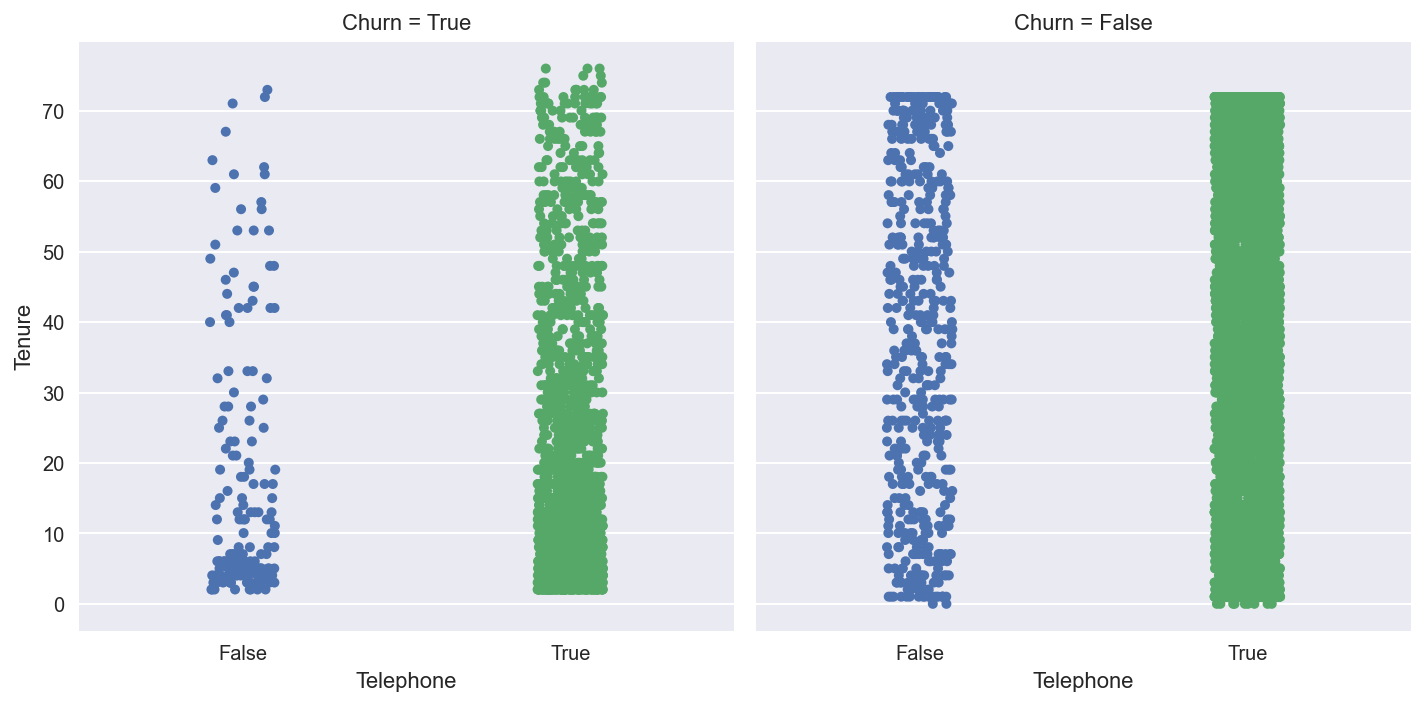

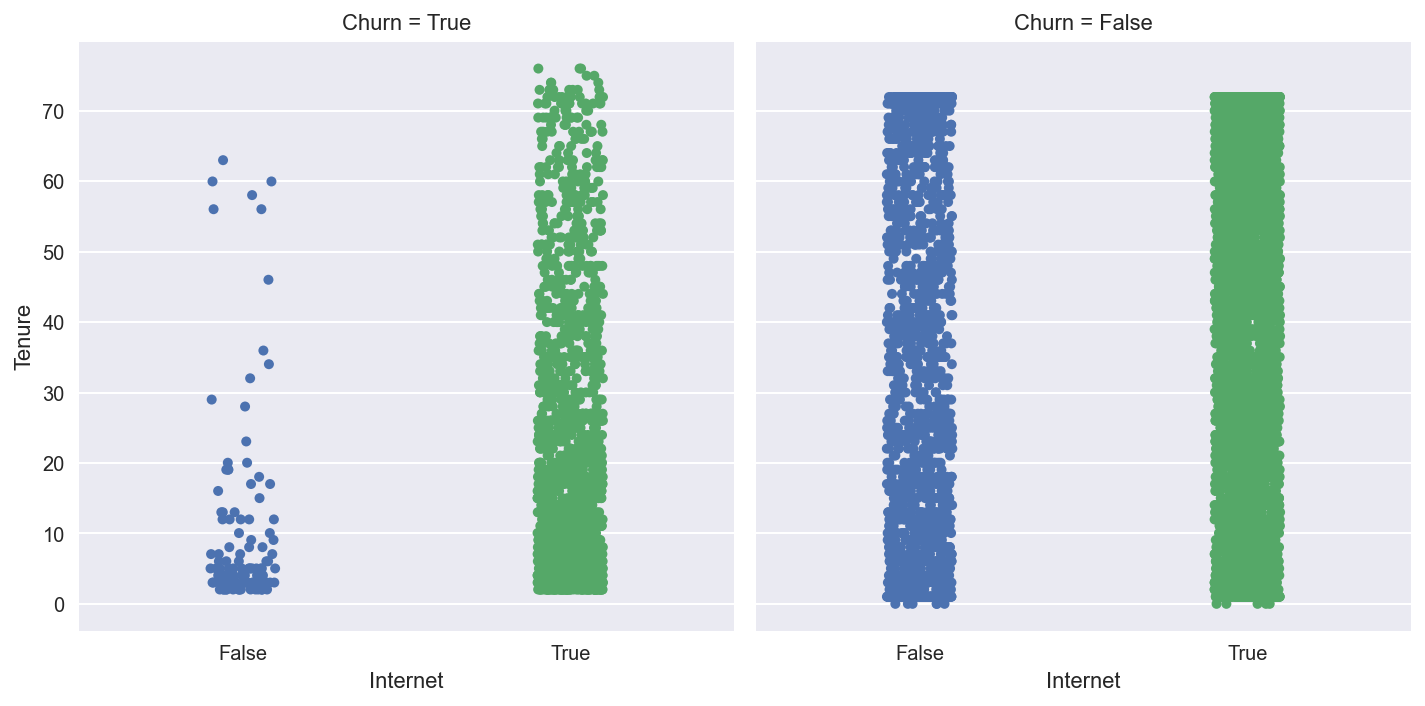

In [70]:
for col in qualitative:
    sns.catplot(x=col, y='Tenure', data=df, col='Churn', col_order=[True, False])
    
plt.tight_layout()

Tenure vs. Type:  
There are relatively less churned customers with Two Year contracts,  
Most of them are Month-to-month clients.  
Perhaps customers who have longer contracts are also more loyal.

Tenure vs. Telephone / Internet:  
There are also relatively less churned clients which exclusively have either a telephone service or an internet service -  
which might point towards that if we get a client to sign up on both - he'll be less likely to leave.

#### MonthlyCharges vs. Qualitative

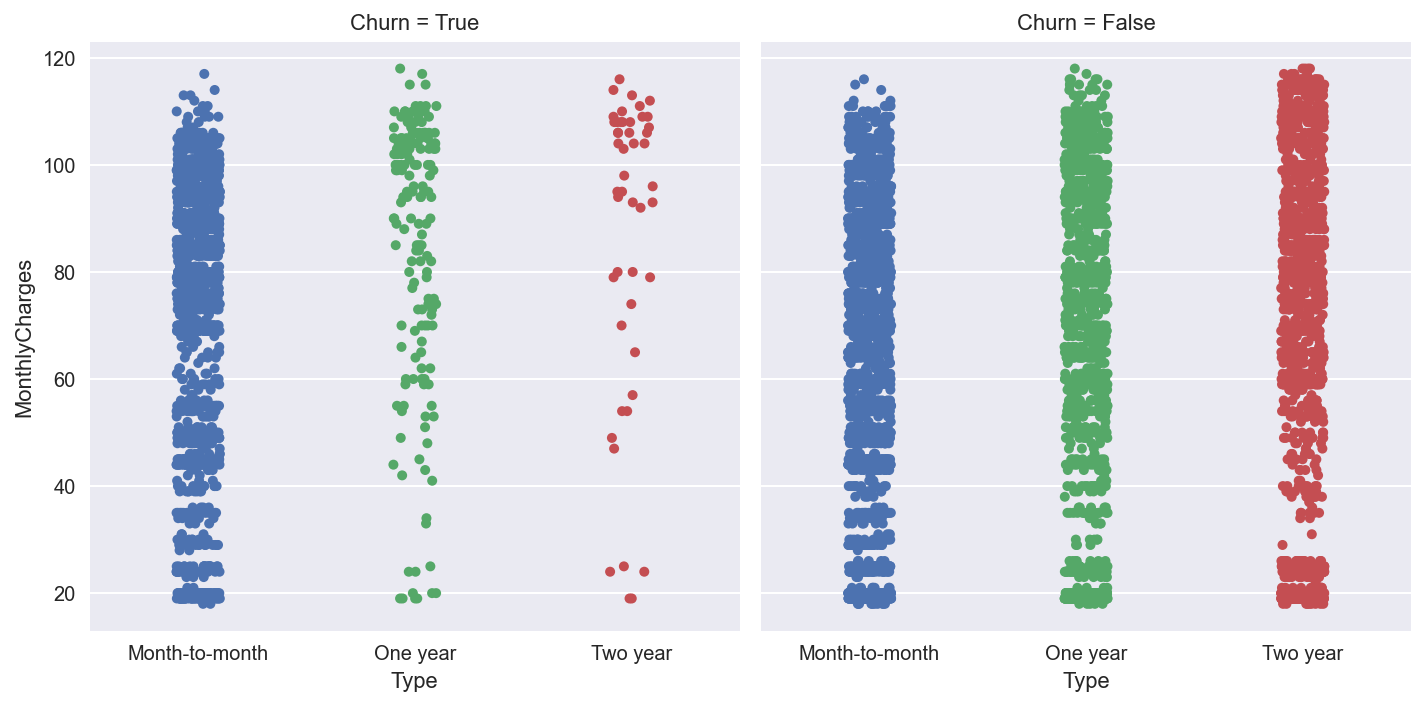

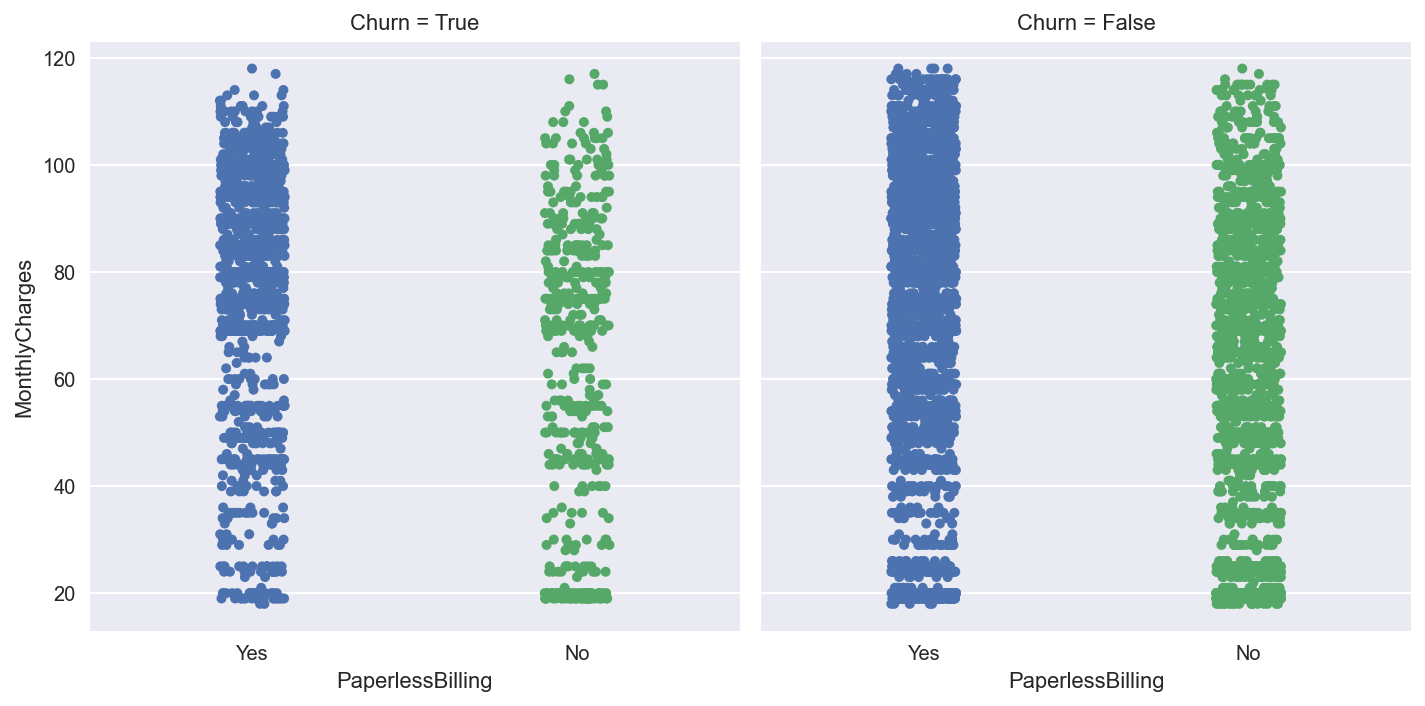

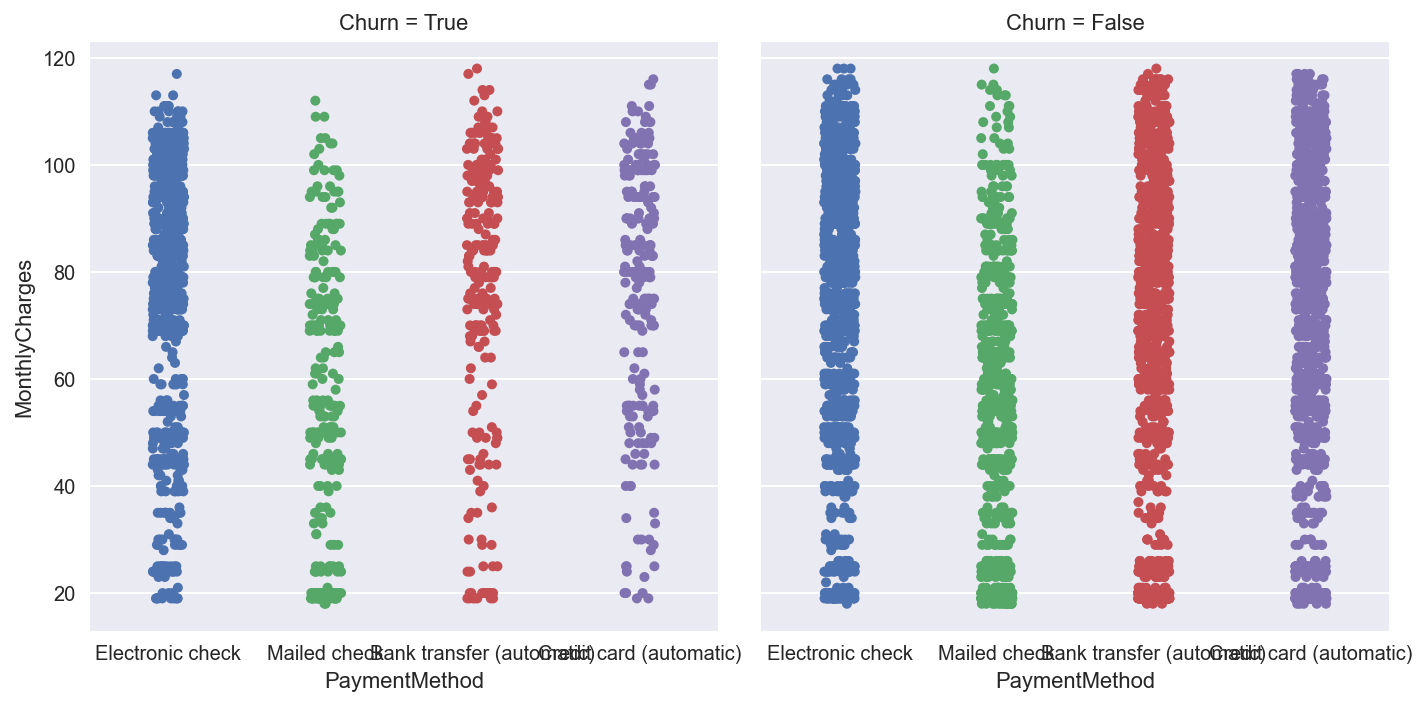

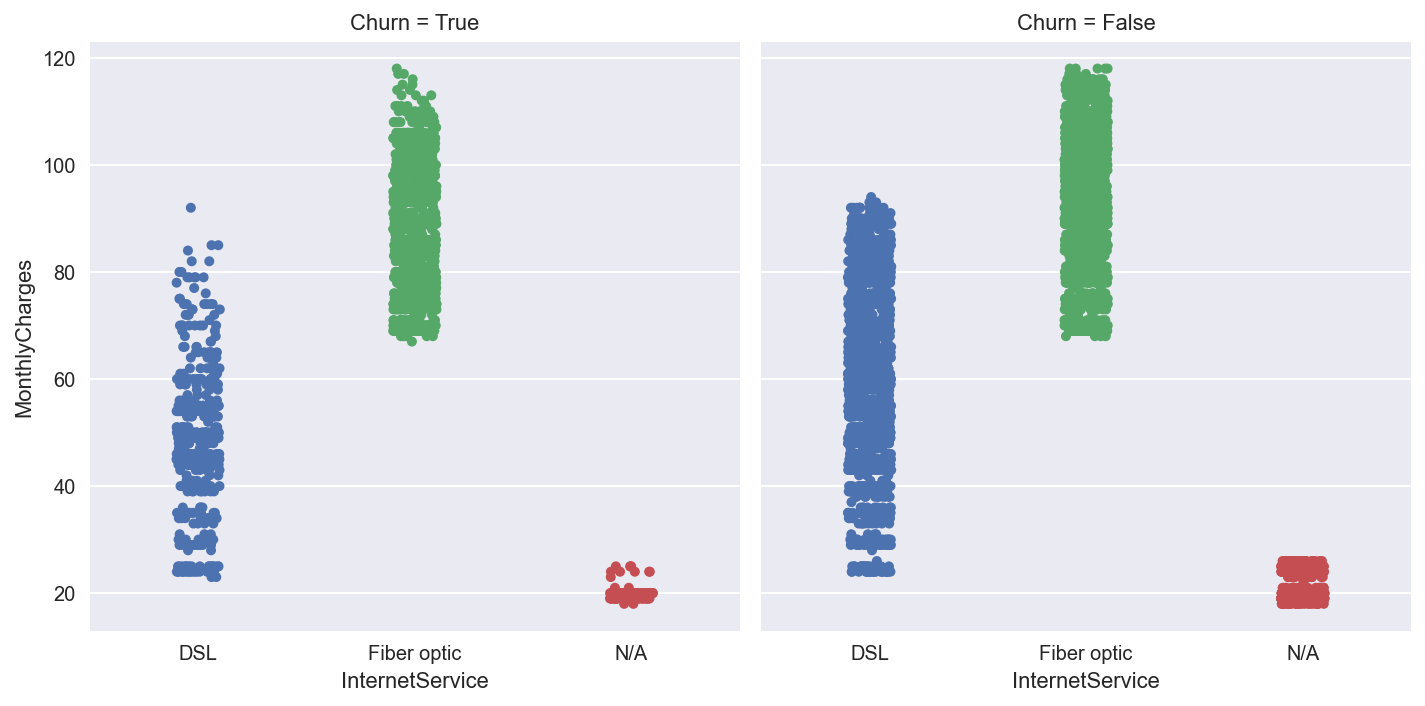

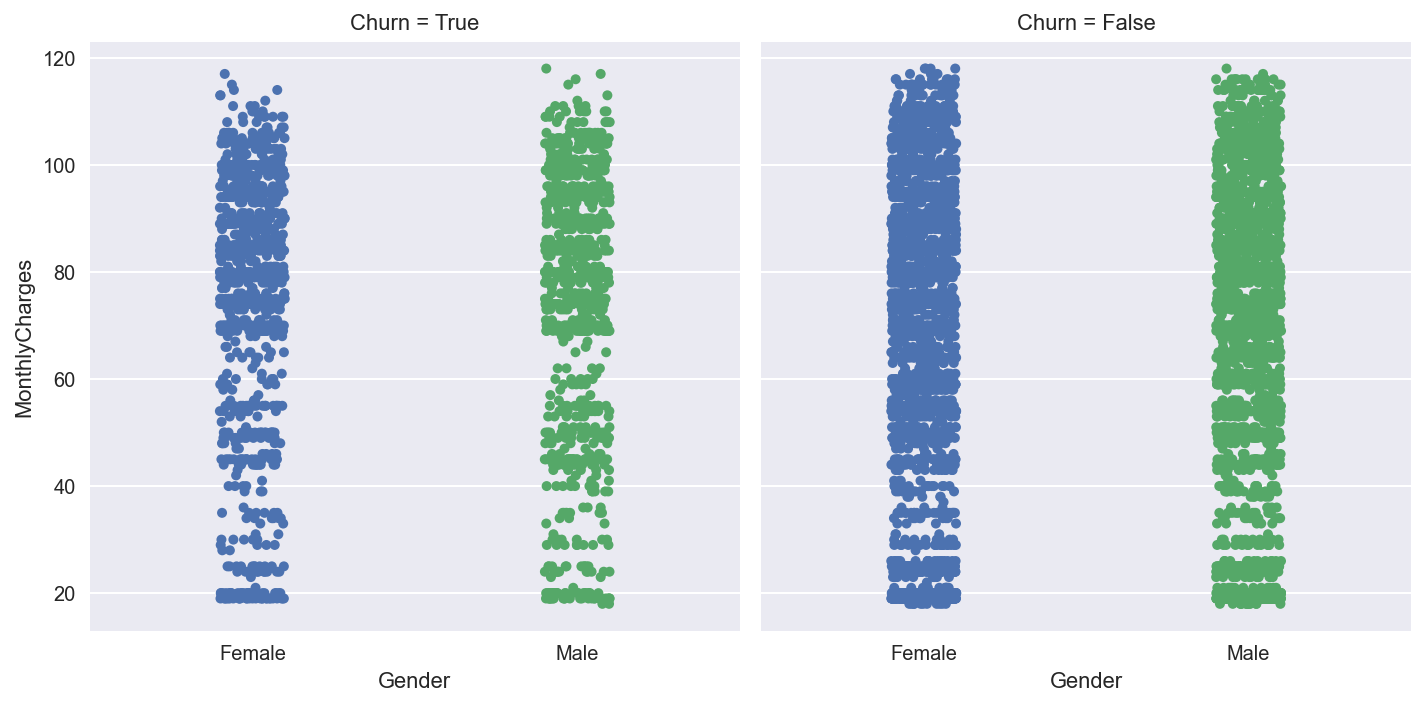

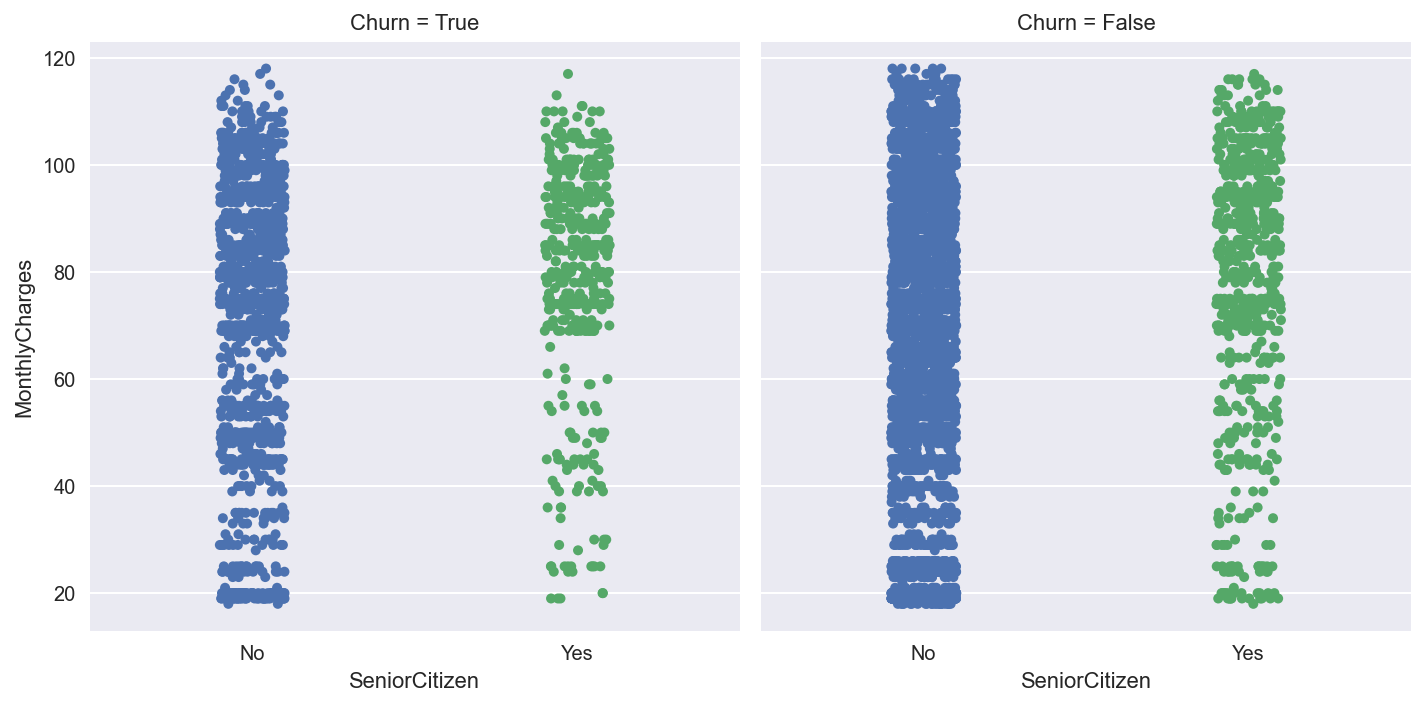

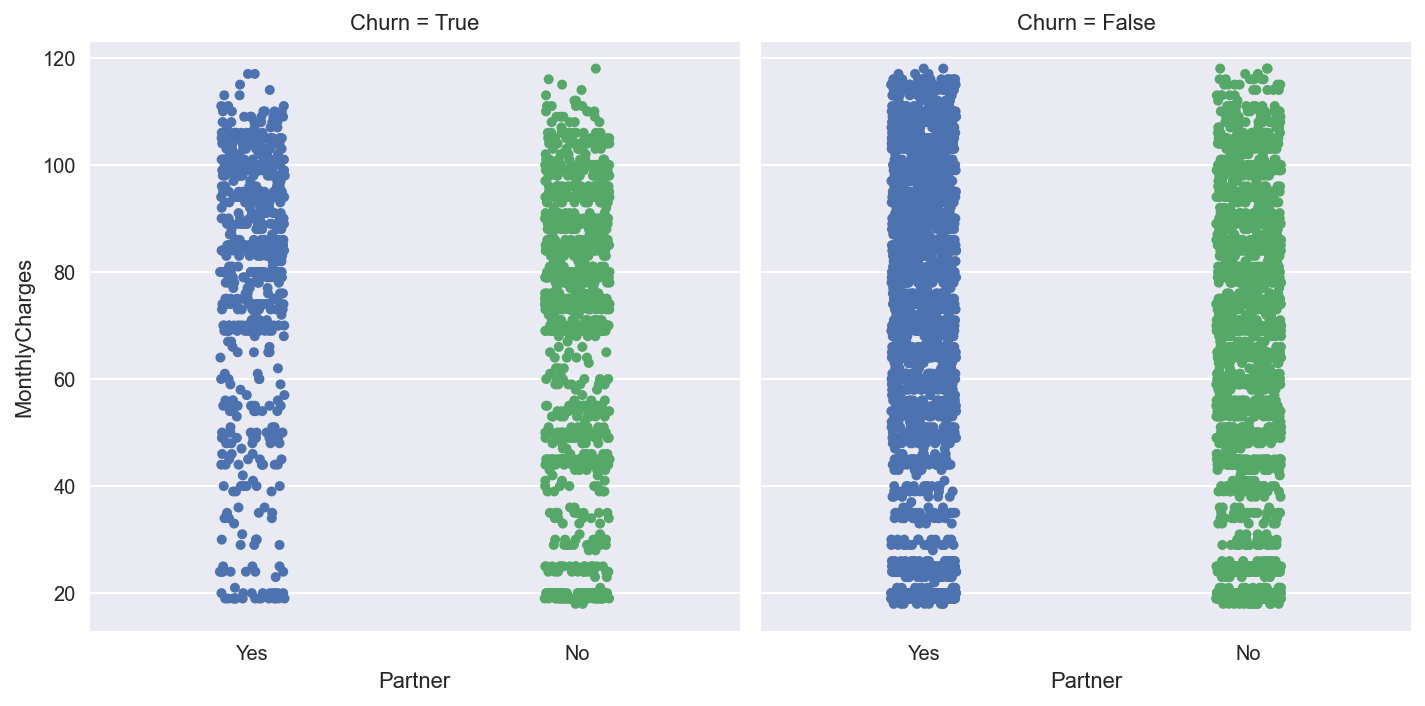

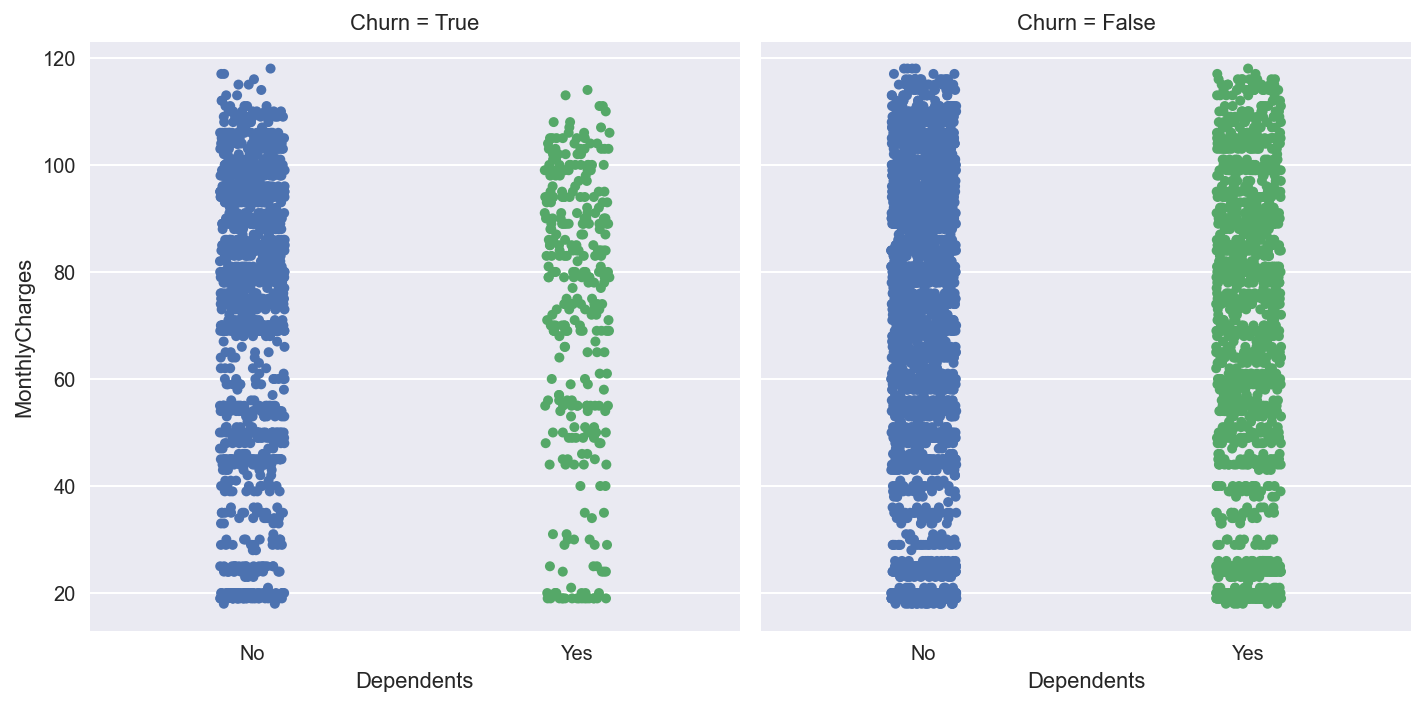

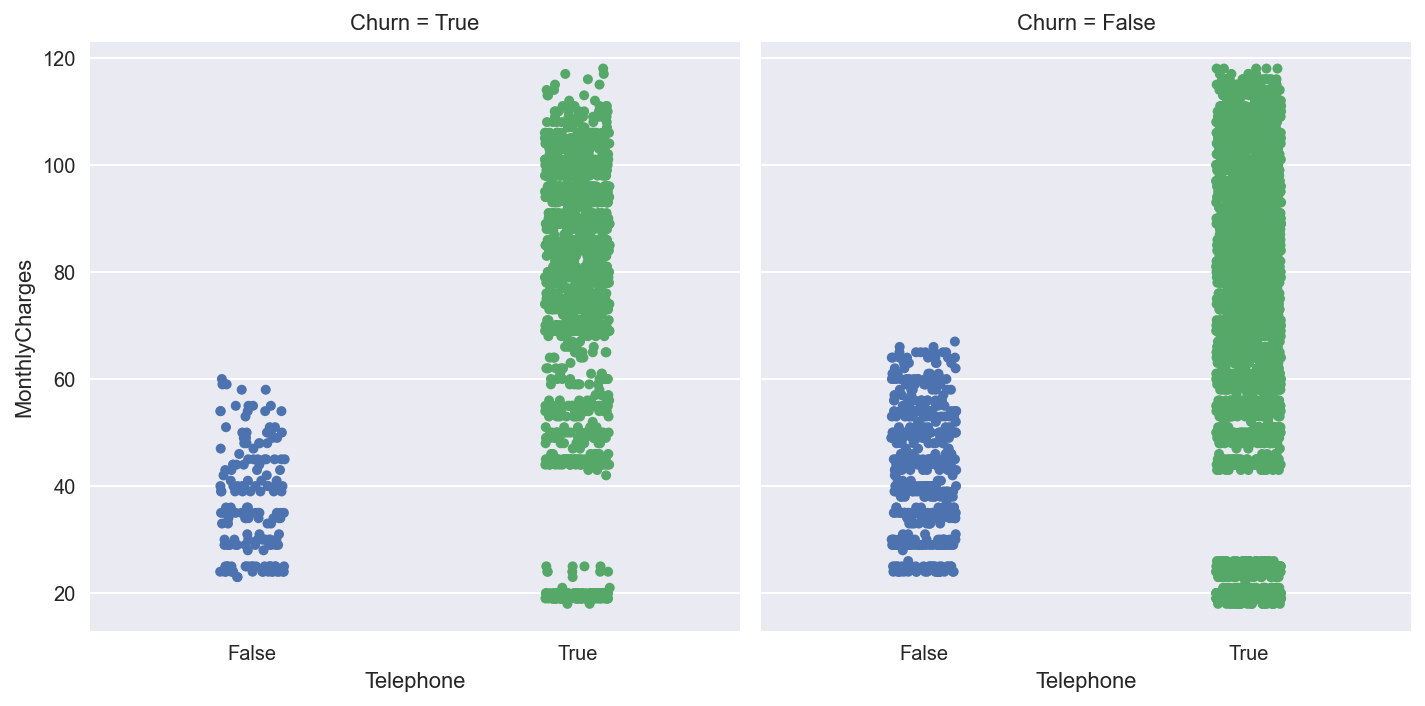

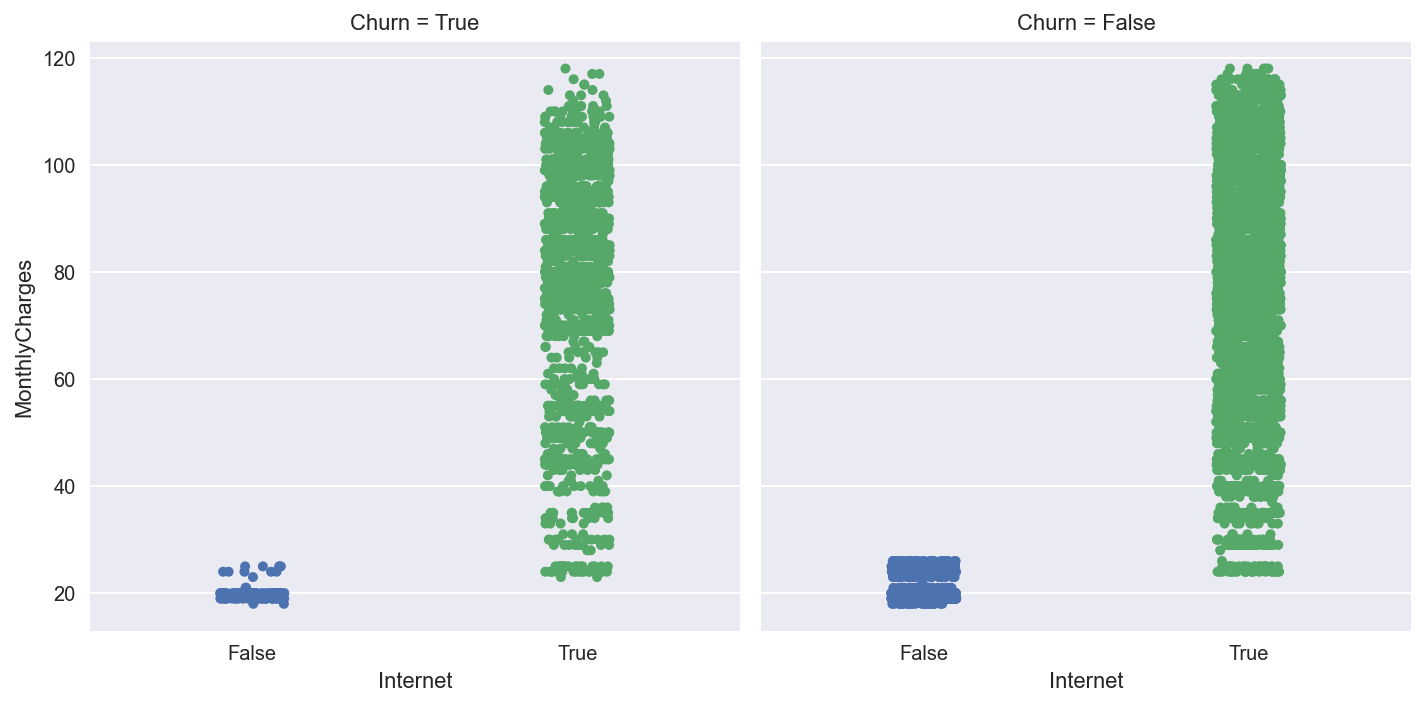

In [71]:
for col in qualitative:
    sns.catplot(x=col, y='MonthlyCharges', data=df, col='Churn', col_order=[True, False])
    
plt.tight_layout()

Monthly charges vs. Internet service:  
Fiber users pay more on average than DSL.

#### Monthly Payments Distribution

In [72]:
monthly_charges_by_churn = df.groupby('Churn')['MonthlyCharges']

In [73]:
stats(monthly_charges_by_churn)

Churn            True        False
count     1869.000000  5174.000000
mean        73.979668    60.797835
std         24.665506    31.095702
min         18.000000    18.000000
25%         56.000000    25.000000
50%         79.000000    64.000000
75%         94.000000    88.000000
max        118.000000   118.000000
skewness    -0.729271    -0.024547
kurtosis    -0.360915    -1.354820

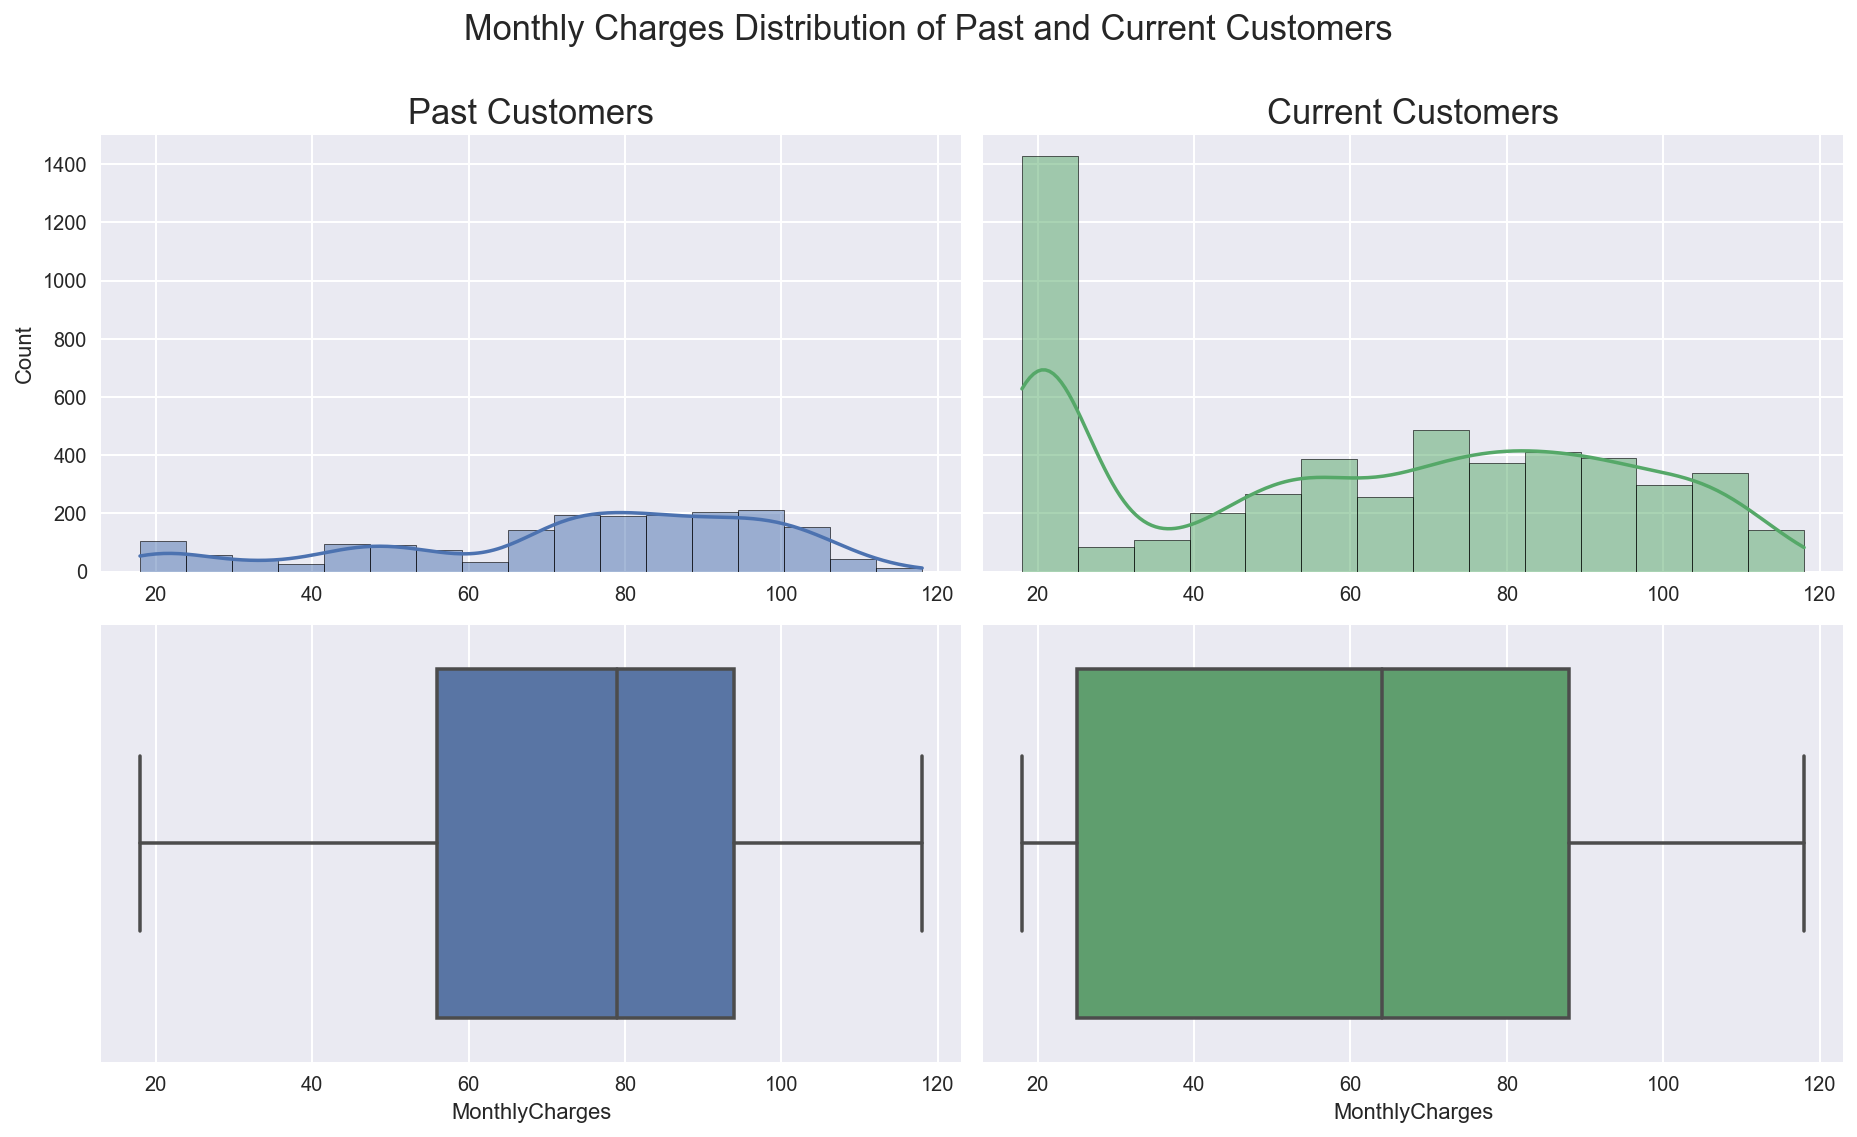

In [74]:
plot_monthly_charges_dist(monthly_charges_by_churn)

'Past customers' is moderately (-0.73) negatively skewed, and data packed together,  
while 'Current customers' is almost non-skewed (-0.025) and more dispersed.

'Current customers' has a big peak in the start,  
meaning there are lots of customers who have a low monthly payment  
\- there's room for the marketing dept. to suggest extra services.

We'll perform a statistical test (Kolmogorov-Smirnov) to check whether the distributions are in fact similar:

In [75]:
compare_dist_ks_test(*monthly_charges_by_churn.groups.values(), alpha=.05)

KstestResult(statistic=0.015583432245393738, pvalue=0.8861476753041158) 

Significance threshold (alpha):  0.05
Is alternative hypothesis statistically significant (pvalue < alpha)?
 False 

Can't reject null hypothesis, distributions are similar (with 95% confidence).


#### Type of Services (Internet / Telephone)

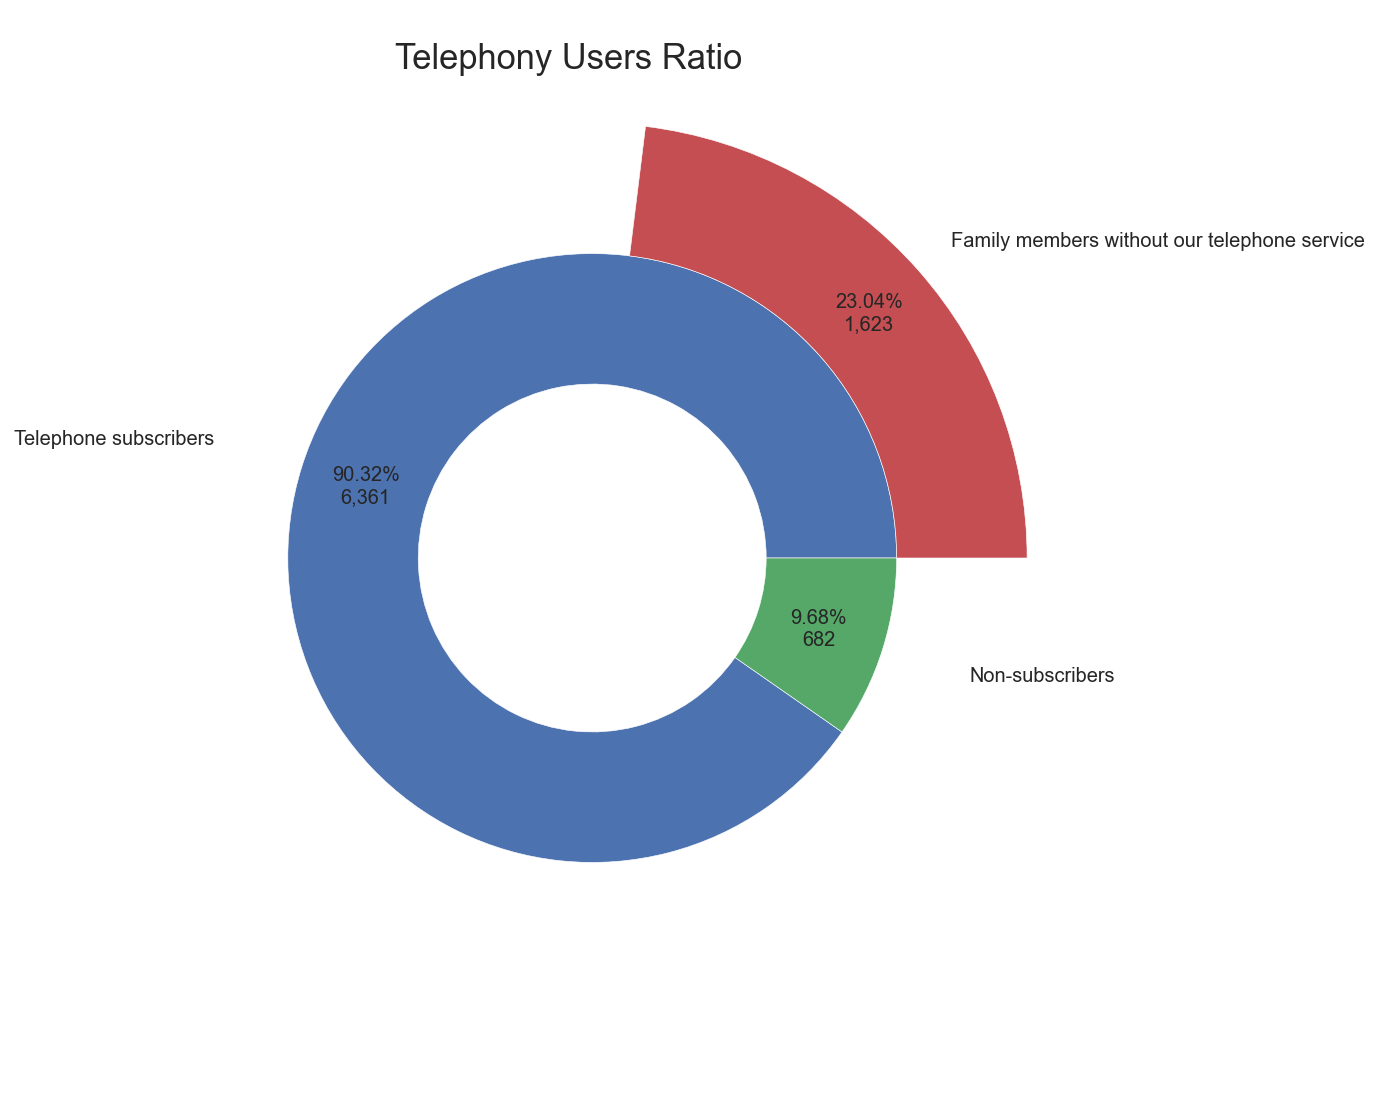

Dependents    1053
Partner       1409
Name: Growth Potential by Family Members without Telephone service, dtype: int64 



In [76]:
plot_telephone_pie()

9.7% of customers can be offered a telephone line service,  
and 23% of customers can be offered to onboard a family member.  

In total, 32.7% of customers can be offered additional telephony services.

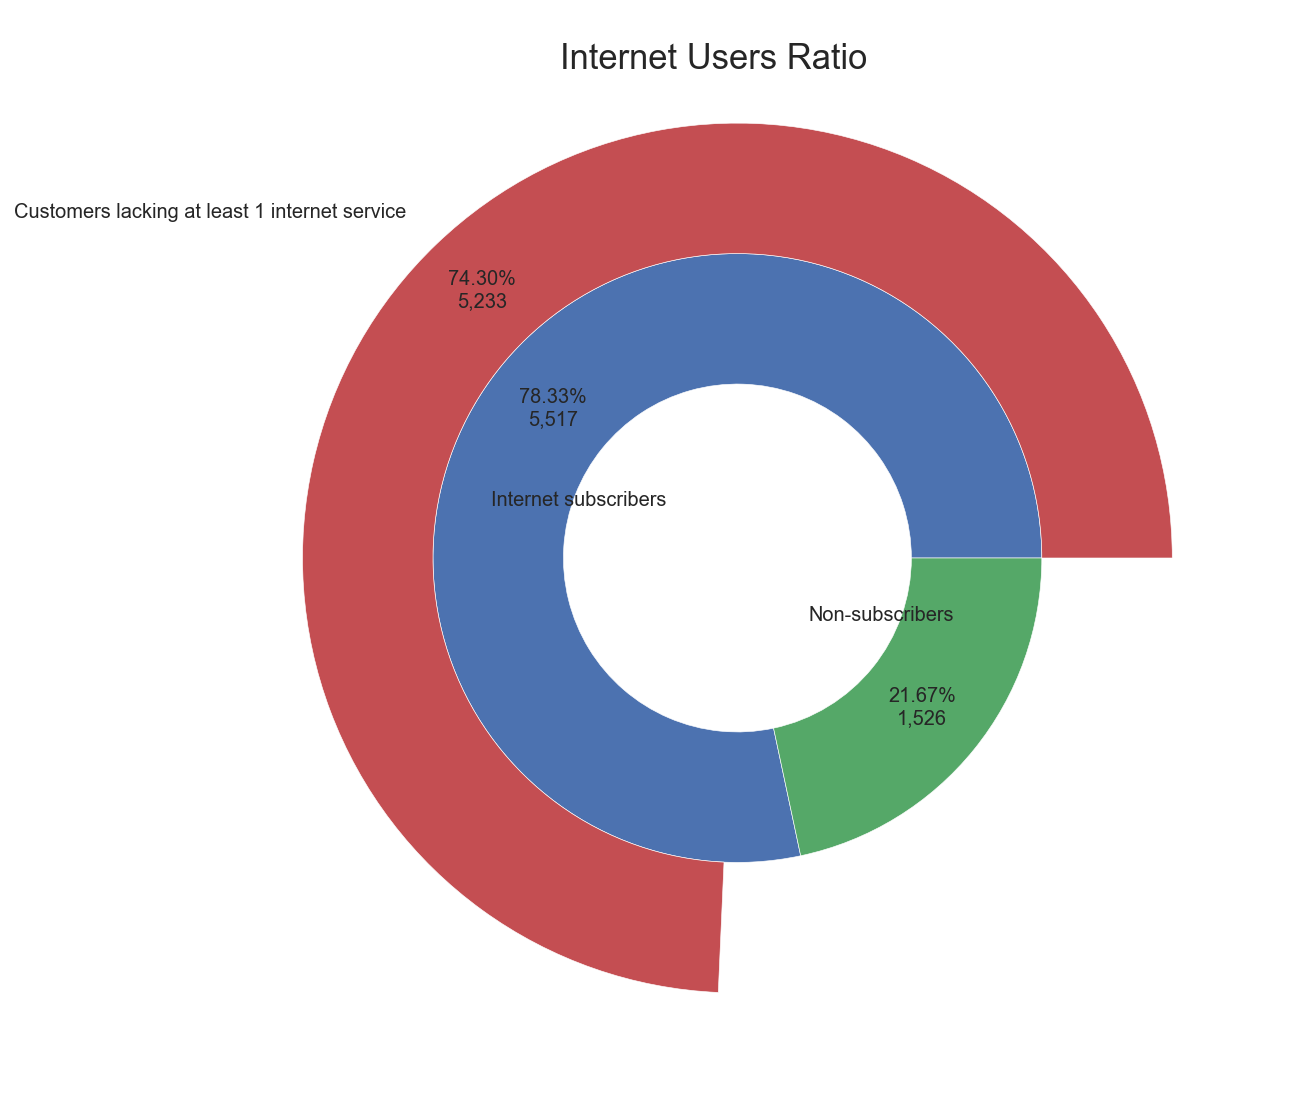

OnlineSecurity      3498
OnlineBackup        3088
DeviceProtection    3095
TechSupport         3473
StreamingTV         2810
StreamingMovies     2785
Name: Growth Potential by Service, dtype: int64 



In [77]:
plot_internet_pie()

Almost all of the Internet customers have at least 1 internet service missing.  
The plot above shows enormous potential for marketing,  
96% of customers are relevant for targeted marketing.

### Conclusions<a id="EDA-Conclusions"></a>

* Detected a strong imblanace of Churn class (roughly 1:3).  
This must be taken into account when setting up the forecast model.

* Most of past customers had a Month-to-month contract.

* Customers with both Telephone and Internet services tend to leave less.

* Fiber Internet has higher Monthly Charges than DSL counterpart.

* Monthly Charges distributions of past and current customers is roughly the same.  
Getting those customers back could increase the monthly turnover by a substantial amount (1/3).

* 9.7% of customers can be offered to connect a phone line,  
and 23% can be offered to onboard a family member.

* 22% of customers can be offered to connect to the internet,  
and 75% (!) can be offered one of the extra internet services provided.

<br>

## Clarifying Questions

- Data is from Feb 2020, but we're at Dec 2021.  
Can we get up-to-date data? (access to company's SQL db would be best).

- Can we get extra information about plans and prices, so together with marketing we can custom fit a specific plan for churned clients?  
Perhaps use clustering algorithms.  
Or, get a list of pre-made special plans which we can pair with churned customers.

- Forecast customer churn - binary classification.  
Why ROC_AUC?  
and only ROC_AUC? perhaps add F1 and / or any other scores?  
Maybe optimize towards less Type 1 (False Positive) or less Type 2 (False Negative) errors?



## Work Plan

It is established that keeping existing customers is more cost effective than attracting new ones [1],  
and our model should be sharpened to accommodate that - by using the correct metric [2].

We should keep False Negatives to a minimum,  
since a false negative essentially means we are predicting a customer will stay - when in fact he has left,  
and that is a customer which we might have retained if we had signaled the marketing team it should intervene.

a False Positives means we are predicting that a client will leave when in fact he's staying,  
and that's a less costly scenario.

We will achieve this by tuning the models for the best possible Recall score,  
while keeping an eye out for ROC_AUC as per demand.  

Accuracy is not a good absolute measure in this case,  
but since the data is not severely imbalanced we'll measure it anyway to gauge relative performance.  

F1 is a good balanced metric combining precision and recall, so we'll be looking at it as well.

References:  
[1] https://www.invespcro.com/blog/customer-acquisition-retention/  
[2] https://www.wovenware.com/blog/2020/01/the-problems-with-imbalanced-datasets-and-how-to-solve-them/

Outline:

1. Split data intoto train/test, while taking into account class imbalance (via stratification).  
Validation will be taken care of via GridSearch or a similar method.

2. Set up a pipeline, to select which features will be used,  
taking care to preprocess each feature appropriately (OHE, Scale).

3. Define functions to create a full metrics report for classification (recall, roc auc, f1, accuracy, confusion matrix),  
complete with plots.

4. Define a function to tie it all together, which will execute the aforementioned steps.

5. Check which features are most relevant to a specific model.

6. Experiment with different techniques for balancing the target class (models' built-in methods, upsample, downsample).

7. Set up multiple classification models, and optimizie hyperparameters for each.

8. Extract the best model for production use.

<br>

## Machine Learning Forecast
***

Now it's time we utilize the power of machine learning,  
for the purpose of predicting churn - whether a customer will stay with the company or leave.  
We will do so in accordance to the plan outlined above.

<br>

### Libraries<a id="ML-Libs"></a>

In [78]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance

# hypertune
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV

# metrics
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

# pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# other ML libs
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [79]:
random_state = 42

<br>

### Features Selection

We will once again look at the various features we have at our disposal,  
and decide which are going to be used as data for the model to operate on.

In [80]:
def extract_feature_importances(pipeline, feature_names=None):
    """Rates each feature according to its importance for prediction.

    Args:
        pipeline (sklearn.pipeline.Pipeline): ML pipeline.
        feature_names (list[str], optional): Feature names. Defaults to None.

    Returns:
        pd.Series: Features ranked by importance.
    """
    
    if not feature_names:
        feature_names = get_feature_names(pipeline)
    # print(feature_names)
        
    model = pipeline[-1]
    
    scores = []
    if hasattr(model, 'feature_importances_'):
        scores = model.feature_importances_
    elif hasattr(model, 'coef_'):
        scores = model.coef_[0] 
    # print(scores)
        
    if len(scores) == len(feature_names):
        return pd.Series(scores, feature_names)
    else:
        return pd.Series(scores)

In [81]:
def permutation_importances(pipeline, X_test, y_test, n=10):
    """Feature importance based on feature permutation.
    For more information, check help(sklearn.inspection.permutation_importance).

    Args:
        pipeline (sklearn.pipeline.Pipeline): ML pipeline.
        X_test (array_like): Data on which permutation importance will be computed.
        y_test (array_like): Target data.
        n (int, optional): Number of feature permutations. Defaults to 10.

    Returns:
        pd.Series: Features ranked by importance.
    """
    
    result = permutation_importance(pipeline, X_test, y_test, n_repeats=n, random_state=random_state, n_jobs=-1)
    return pd.Series(result.importances_mean, index=X.columns)

In [82]:
def report_importances(pipeline, X=None, y=None, permutation=False, n=10, feature_names=None, threshold=None):
    """Interface for either extract_feature_importances or permutation_importances.

    Args:
        pipeline (sklearn.pipeline.Pipeline): ML pipeline.
        X (array_like, optional): Data on which importance will be computed. Relevant to permutation=True only. Defaults to None.
        y (array_like, optional): Target data. Relevant to permutation=True only. Defaults to None.
        permutation (bool, optional): Whether to use permutations. Defaults to False.
        n (int, optional): Number of feature permutations. Relevant to permutation=True only. Defaults to 10.
        feature_names (list[str], optional): Feature names. Defaults to None.
        threshold (float, optional): Subset of features to include, cut by rank. Defaults to None.

    Returns:
        pd.Series: Features ranked by importance.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                        stratify=y, 
                                                        random_state=random_state)
    
    pipeline.fit(X_train, y_train)
    
    if permutation:
        res = permutation_importances(pipeline, X_test, y_test, n).sort_values(ascending=False, key=abs)
    else:
        res = extract_feature_importances(pipeline, feature_names).sort_values(ascending=False, key=abs)
        
    if threshold:
        return res[abs(res) > threshold]
    else:
        return res

Checking pairwise correlations of features:

In [83]:
encoded_df = df.apply(lambda x : pd.factorize(x)[0])
encoded_df.head(2)

CustomerID  BeginDate  EndDate  Type  PaperlessBilling  PaymentMethod  \
0           0          0       -1     0                 0              0   
1           1          1       -1     1                 1              1   

   MonthlyCharges  TotalCharges  InternetService  OnlineSecurity  ...  \
0               0             0                0               0  ...   
1               1             1                0               1  ...   

   StreamingMovies  Gender  SeniorCitizen  Partner  Dependents  MultipleLines  \
0                0       0              0        0           0              0   
1                0       1              0        1           0              1   

   Tenure  Churn  Telephone  Internet  
0       0      0          0         0  
1       1      0          1         0  

[2 rows x 24 columns]

In [84]:
corr = encoded_df.corr()

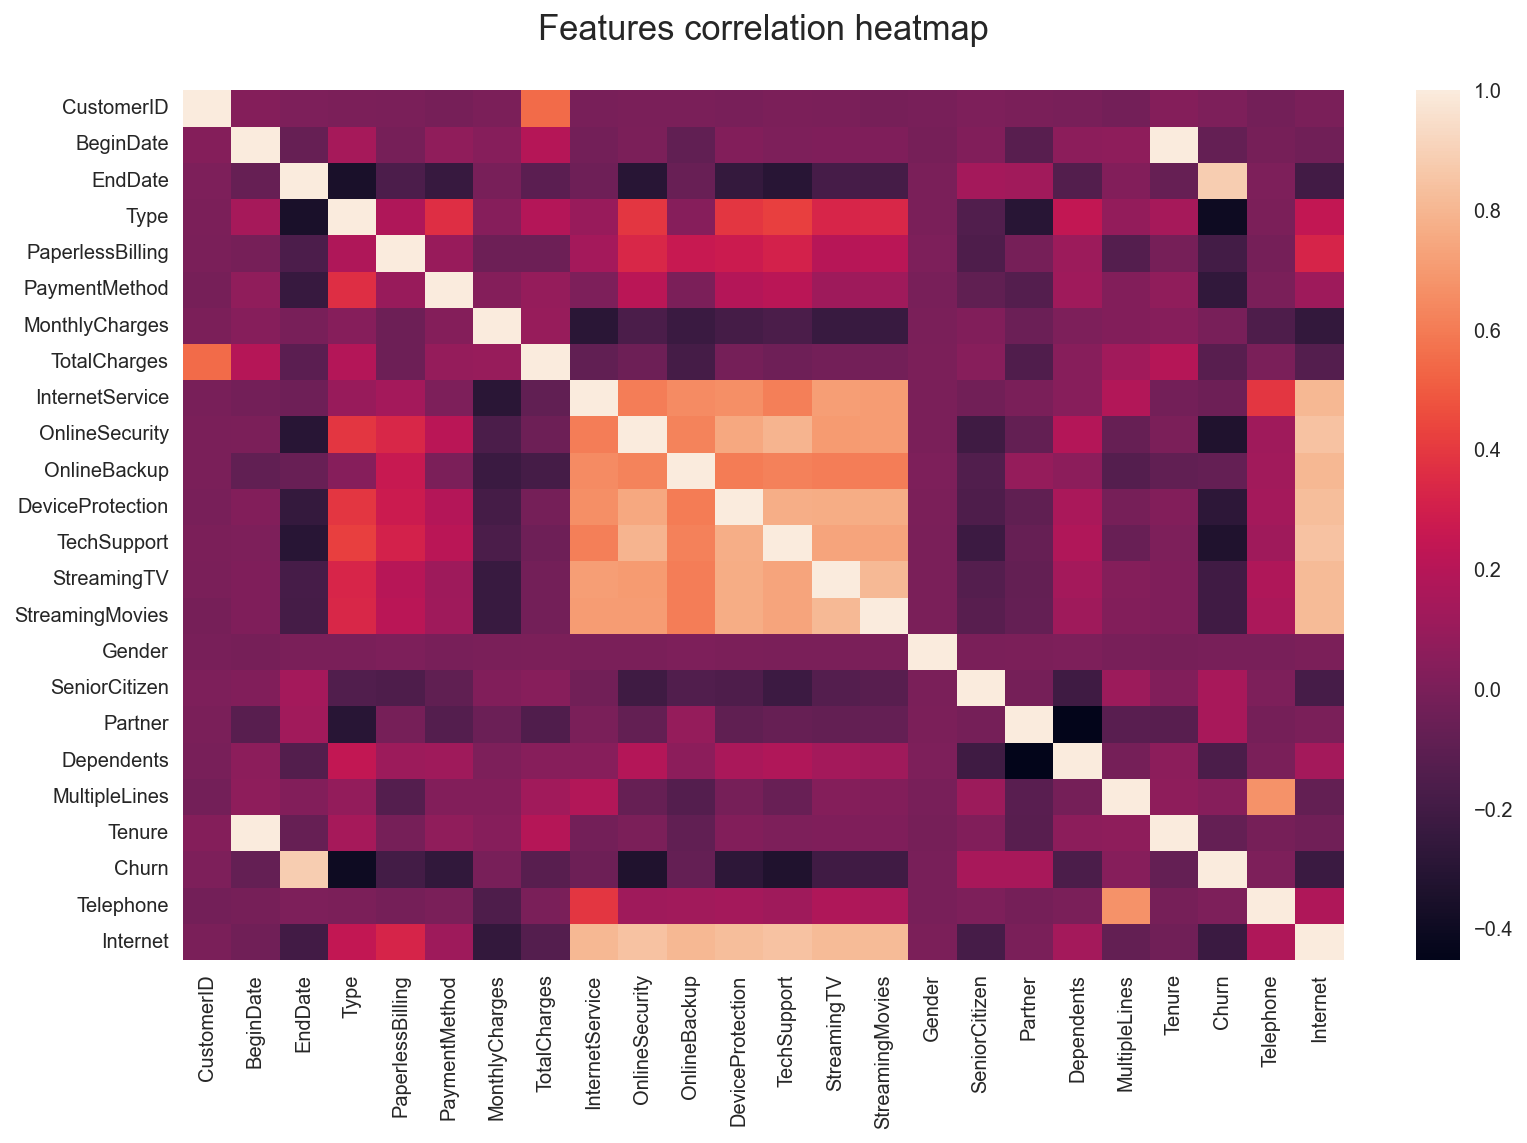

In [85]:
sns.heatmap(corr)
plt.title('Features correlation heatmap\n', fontsize='xx-large');

We won't be using date features, can disregard those.  

In [86]:
corr.loc[internet_columns, 'Internet']

InternetService     0.803477
OnlineSecurity      0.844829
OnlineBackup        0.803663
DeviceProtection    0.825776
TechSupport         0.843533
StreamingTV         0.814783
StreamingMovies     0.813923
Name: Internet, dtype: float64

'Internet' feature is highly correlated to the various internet services - we will drop those and leave only 'Internet'.

In [87]:
qualitative = [f for f in qualitative if f not in internet_columns]
qualitative

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Telephone',
 'Internet']

In [88]:
df[qualitative].describe()

Type PaperlessBilling     PaymentMethod Gender  \
count             7043             7043              7043   7043   
unique               3                2                 4      2   
top     Month-to-month              Yes  Electronic check   Male   
freq              3875             4171              2365   3555   

       SeniorCitizen Partner Dependents Telephone Internet  
count           7043    7043       7043      7043     7043  
unique             2       2          2         2        2  
top               No      No         No      True     True  
freq            5901    3641       4933      6361     5517

We can further segment qualitative features by binary / non-binary.

In [89]:
qualitative_b = ['PaperlessBilling', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Telephone', 'Internet']

In [90]:
qualitative_mc = ['Type', 'PaymentMethod'] # multi-class

In [91]:
target = 'Churn'

In [92]:
features = quantitative + qualitative
features

['Tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Telephone',
 'Internet']

In [93]:
X = df[features]
y = df[target]

In [94]:
y_ratio = (lambda c:c[0]/c[1])(y.value_counts().sort_index())
y_ratio

2.7683253076511503

<br>

### Train/Test Split

We'll split the data to train and test (3:1),  
in order to be able to fit the model (train set),  
and then give it a score based on previously unseen data (test set).

In [95]:
# X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], 
#                                                     test_size=.25, 
#                                                     stratify=df[target],
#                                                     random_state=random_state)

# X_train.shape, y_train.shape

# X_test.shape, y_test.shape

The split will be performed inside the execution function for convenience (and shorter function signatures).  
random_state takes care of uniformity for us.

<br>

### Pipeline

In [96]:
def get_feature_names(pipeline, base_features=None):
    """Recursive function that extracts feature names out of a fitted preprocessing pipeline.

    Args:
        pipeline (sklearn.pipeline.Pipeline): ML pipeline.
        base_features (list[str], optional): Feature names before transformation. Defaults to None.

    Returns:
        list: Features ranked by importance.
    """
    
    def on_transformer(name, transformer, features):
        # print(name, transformer, features)
        
        if hasattr(transformer, 'steps'):
            return get_feature_names(transformer, features)
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                ftrs = transformer.get_feature_names_out(features)
            except:
                ftrs = None
            return ftrs if ftrs is not None else features
        elif transformer == 'passthrough' and base_features is not None:
            return base_features[features]
        else:
            return features
    
    def on_step(step):
        # print(step)
        
        if hasattr(step, 'transformers_'):
            return [on_transformer(*t) for t in step.transformers_]
        elif hasattr(step, 'get_feature_names_out'):
            return step.get_feature_names_out(base_features)
        
        return base_features

    return list(dict.fromkeys([f for f in pd.core.common.flatten([on_step(s) for s in pipeline]) 
                          if isinstance(f, str) and not f.startswith('x')]))

All of the binary categories will be processed by OrdinalEncoder,  
and the rest of the categories will be processed by One-Hot Encoder.

In [97]:
qualitative_b

['PaperlessBilling',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Telephone',
 'Internet']

In [98]:
qualitative_mc

['Type', 'PaymentMethod']

All of the quantitative features will be processed by a scaler (either Standard or MinMax).

In [99]:
quantitative

['Tenure', 'MonthlyCharges', 'TotalCharges']

In [100]:
def pipeline(model=None, sscaler=False, minmax=quantitative, ordinal=qualitative_b, one_hot=qualitative_mc, 
             remainder='drop',
             upsample=False, downsample=False):
    """Builds a preprocessing pipeline.

    Args:
        model (sklearn_model, optional): ML model. Defaults to None.
        sscaler (Union[bool, list[str]], optional): Applies StandardScaler to specified columns, 
            or True for all columns. Defaults to False.
        minmax (Union[bool, list[str]], optional): Applies MinMaxScaler to specified columns, 
            or True for all columns. Defaults to quantitative.
        ordinal (list[str], optional): Applies OrdinalEncoder to specified columns. Defaults to qualitative_b.
        one_hot (list[str], optional): Applies OneHotEncoder to specified columns. Defaults to qualitative_mc.
        remainder (str, optional): 'passthrough' to include remaining columns, 
            otherwise 'drop' to exclude. Defaults to 'drop'.
        upsample (bool, optional): Applies Imblearn's RandomOverSampler. Defaults to False.
        downsample (bool, optional): Applies Imblearn's RandomUnderSampler. Defaults to False.

    Returns:
        imblearn.pipeline.Pipeline: Resulting pipeline.
    """
    
    steps = []
    column_transformer = []
    
    if isinstance(sscaler, list):
        column_transformer.append(
            (StandardScaler(), sscaler))
    elif sscaler == True:
        steps.append(StandardScaler())
        
    if isinstance(minmax, list):
        column_transformer.append(
            (MinMaxScaler(), minmax))
    elif minmax == True:
        steps.append(MinMaxScaler())
    
    if ordinal:
        column_transformer.append(
            (OrdinalEncoder(), ordinal))
        
    if one_hot:
        column_transformer.append(
            (OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), one_hot))
    
    
    if column_transformer:
        column_transformer = [make_column_transformer(*column_transformer, remainder=remainder)]
        
    steps = [*column_transformer, *steps]
    
    if upsample:
        steps.append(RandomOverSampler(random_state=random_state))
        
    if downsample:
        steps.append(RandomUnderSampler(random_state=random_state))
        
    pipeline = make_pipeline(*steps)
    
    if model is not None:
        pipeline.steps.append(('model', model))
    
    return pipeline

Checking the pipeline's output:

In [101]:
(lambda x:pd.DataFrame(x.fit_transform(X), columns=get_feature_names(x, X.columns))
)(pipeline()).head()

Tenure  MonthlyCharges  TotalCharges  PaperlessBilling  Gender  \
0  0.013397            0.11      0.003339               1.0     0.0   
1  0.447710            0.38      0.217526               0.0     1.0   
2  0.053155            0.35      0.012437               1.0     1.0   
3  0.592481            0.24      0.211884               0.0     1.0   
4  0.066119            0.52      0.017388               1.0     0.0   

   SeniorCitizen  Partner  Dependents  Telephone  Internet  Type_One year  \
0            0.0      1.0         0.0        0.0       1.0            0.0   
1            0.0      0.0         0.0        1.0       1.0            1.0   
2            0.0      0.0         0.0        1.0       1.0            0.0   
3            0.0      0.0         0.0        0.0       1.0            1.0   
4            0.0      0.0         0.0        1.0       1.0            0.0   

   Type_Two year  PaymentMethod_Credit card (automatic)  \
0            0.0                                    0.0   
1            0.0                                    0.0   
2            0.0                                    0.0   
3            0.0                                    0.0   
4            0.0                                    0.0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  
0                             1.0                         0.0  
1                             0.0                         1.0  
2                             0.0                         1.0  
3                             0.0                         0.0  
4                             1.0                         0.0

Everything appears to be in order.

<br>

### Metrics

We will use Recall as the main metrics, to minimize False Negatives (false negative = wrongly predicted client will stay).  
As per project demands, we will also monitor Roc-Auc score to comply with the definesd minimum threshold of 0.88.

In [102]:
scoring = 'recall'

In [103]:
def report_scores(scoring, y_true, y_pred, y_prob=None, cm_norm=None, round_=3, verbose=True):
    """Returns a dictionary, containing confusion matrix values and computed scores.

    Args:
        scoring (Union[str, list[str]]): List of metrics or a single metric to compute. 
        y_true (array_like): Target labels.
        y_pred (array_like): Predicted labels.
        y_prob (array_like, optional): Predicted probabilities. Used for roc_auc_score. Defaults to None.
        cm_norm (Union[bool, str], optional): Whether to normalize confusion matrix values. Defaults to None.
        round_ (int, optional): Rounds normalized confusion matrix values. Defaults to 3.
        verbose (bool, optional): Prints confusion matrix if True. Defaults to True.

    Returns:
        dict: Dictionary containing confusion matrix and computed scores.
    """
    
    def _score(scorer):
        if 'y_score' in scorer._score_func.__code__.co_varnames:
            return scorer._score_func(y_true, y_score=y_prob)
        else:
            return scorer._score_func(y_true, y_pred=y_pred)
    
    cm = confusion_matrix(y_true, y_pred, normalize=cm_norm)
    cm_map = dict(tn=cm[0, 0], fp=cm[0, 1], fn=cm[1, 0], tp=cm[1, 1])
    if verbose:
        print(cm)
        
    fn = confusion_matrix(y_true, y_pred)[1, 0]
    
    if isinstance(scoring, list):
        return {**cm_map, **{s:_score(get_scorer(s)) for s in scoring}, 'fn_count': fn}
    else:
        return {**cm_map, scoring: _score(get_scorer(scoring)), 'fn_count': fn}

In [104]:
def plot_cm(results=None, cm=None, ticks=[0, 1], rotate_ylabels=False, fmt='l\n\nv\nn', cmap='Blues', **kwargs):
    """Plots a Confusion Matrix.

    Args:
        results (dict, optional): Results dictionary, as generated by run_model. 
            Used as convenience in order to override cm value. Defaults to None.
        cm (array_like, optional): Confusion matrix to plot. Defaults to None.
        ticks (list, optional): Overrides default ticks. Defaults to [0, 1].
        rotate_ylabels (bool, optional): Rotates y ticks by 90 degrees. Defaults to False.
        fmt (str, optional): Annotation format. Defaults to 'l\n\nv\nn' (label, value, normalized).
        cmap (Union[str, matplotlib.colors.Colormap], optional): Colormap. Defaults to 'Blues'.
    """
    
    labels = [['TN', 'FP'], 
              ['FN', 'TP']]
    
    if results:
        cm = confusion_matrix(results['y']['test'], results['y_pred']['test'])
    
    norm_values = cm.astype('float') / cm.sum(axis=1).reshape(-1, 1)
    
    def label(i, j):
        nonlocal fmt
        
        if cm.shape != (2, 2):
            fmt = fmt.replace('l', '')
            
        if '\n' not in fmt:
            fmt = '\n\n'.join(fmt)
            
        return fmt.replace('v', f'{cm[i][j]:,}') \
                  .replace('n', f'{norm_values[i][j]:.2f}') \
                  .replace('l', str(labels[i][j]))
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=cmap, **kwargs)
    plt.colorbar(im, ax=ax)

    middle_value = np.max(cm) // 2
    dark_color = im.cmap(255)
    for i in range(2):
        for j in range(2):
            value = cm[i, j]
            color = 'w' if value > middle_value else dark_color
            plt.text(j, i, label(i, j), ha="center", va="center", color=color)
        
    ax.set_title('Confusion Matrix')
    
    ax.set_xlabel('Predicted label')
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    
    ax.set_ylabel('Actual label')
    ax.set_yticks(range(len(ticks)))
    
    if rotate_ylabels:
        ax.set_yticklabels(ticks, rotation=90, va='center')
    else:
        ax.set_yticklabels(ticks)
        
    plt.grid(None)

In [105]:
def plot_curves(results, thresholds=[0.2, 0.4, 0.5, 0.6, 0.8]):
    """Plots metrics related curves (F1, AUC_ROC, PRC) to help illustrate how well the model is performing.

    Args:
        results (dict): Results dictionary, as generated by run_model. 
        thresholds (list, optional): List of thresholds to compare. Defaults to [0.2, 0.4, 0.5, 0.6, 0.8].
    """
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for _type in ['train', 'test']:
        
        eval_stats[_type] = {}
        
        target = results['y'][_type]
        pred_target = results['y_pred'][_type]
        pred_proba = results['y_prob'][_type]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[_type]['ROC AUC'] = roc_auc
        # roc_gmeans = np.sqrt(tpr * (1-fpr))

        # PRC
        precision, recall, pr_thresholds = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        eval_stats[_type]['APS'] = aps
        
        color = 'blue' if _type == 'train' else 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in thresholds:
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1')
        ax.legend()
        ax.set_title('F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{_type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in thresholds:
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        # roc_gmean_idx = np.argmax(roc_gmeans)
        # ax.plot(roc_thresholds[roc_gmean_idx], roc_gmeans[roc_gmean_idx], color='black', marker='o', markersize=7, 
        #         label=f'G-Mean {roc_gmeans[roc_gmean_idx]}')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend()        
        ax.set_title('ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{_type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in thresholds:
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        prc_baseline = len(target[target==1]) / len(target)
        plt.plot([0, 1], [prc_baseline, prc_baseline], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        ax.set_title('PRC')        

        eval_stats[_type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[_type]['F1'] = f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    # print(df_eval_stats)
    plt.show()

<br>

### Execution

In [106]:
experiments = {}

In [107]:
@hide_warnings
def run_model(model, X, y, 
              baseline=None,
              scoring=scoring, 
              search=HalvingRandomSearchCV, hyperparams={}, 
              verbose=False, **kwargs):
    """A function to streamline the model selection and tuning process.

    Args:
        model (Union[sklearn_model, sklearn.pipeline.Pipeline]): ML model or a pipeline.
        X (array_like): Data to train and test on.
        y (array_like): Target labels.
        baseline (pd.DataFrame, optional): Baseline results of dummy model. Defaults to None.
        scoring (str, optional): Metric which is used for hyperparameters tuning. Defaults to predefined scoring.
        search (sklearn.model_selection, optional): Hyperparameters tuning. 
            GridSearchCV, HalvingRandomSearchCV, skopt.BayesSearchCV. Defaults to HalvingRandomSearchCV.
        hyperparams (dict, optional): Dictionary of hyperparameter names and value ranges. Defaults to empty dict().
        verbose (bool, optional): Verbosity of logs. Defaults to False.

    Returns:
        dict: Dictionary containing:
            model (Union[sklearn_models, sklearn.pipeline.Pipeline]): Fitted model / pipeline.
                if search was True, with tuned hyperparameters.
            best_params (dict): Dictionary of best parameters found, if search was True.
            scores (pd.DataFrame): Scores report (as returned by report_scores).
            y: Target labels.
            y_pred: Predicted labels.
            y_prob: Predicted probabilities.
    """
    
    def init(_class, *args, **kwargs):
        try:
            return _class(*args, random_state=random_state, **kwargs)
        except:
            return _class(*args, **kwargs)
    
    if verbose:
        print(model[-1].__class__.__name__, '\n')
        
    metrics = ['recall', 'roc_auc', 'f1', 'accuracy']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                        stratify=y, random_state=random_state)
    
    best_params = {}
    
    
    is_catboost = isinstance(model, cb.CatBoostClassifier) or isinstance(model[-1], cb.CatBoostClassifier)
    _y_train = y_train if not is_catboost else y_train.astype(str)
    
    if is_catboost and scoring == 'recall':
        scoring = make_scorer(recall_score, pos_label='True')
    
    if hyperparams:
        hyperparams = {('model__'+k  if '__' not in k else k):v for k,v in hyperparams.items()}
        
        search = init(search, model, hyperparams,
                      # cv=StratifiedKFold(shuffle=True, random_state=random_state),
                      scoring=scoring,
                      **kwargs)
        
        search.fit(X_train, _y_train)
        best_params = {remove_prefix(k, 'model__'): v for k, v in search.best_params_.items()}
        print('best params')
        pprint(best_params)
        print()
        
        fit_time = search.cv_results_['mean_fit_time'].mean()
        predict_time = search.cv_results_['mean_score_time'].mean()
        
        model = search.best_estimator_
    else:
        model.fit(X_train, _y_train)
        cv = cross_validate(model, X_train, _y_train, scoring=scoring, n_jobs=-1)
        fit_time = cv['fit_time'].mean()
        predict_time = cv['score_time'].mean()
        
    train_time = timedelta(seconds=round(fit_time))
    test_time = timedelta(seconds=round(predict_time))
    
    has_predict_proba = hasattr(model, 'predict_proba') or hasattr(model[-1], 'predict_proba')
    
    y_train_pred = model.predict(X_train)
    if is_catboost:
        y_train_pred = y_train_pred == 'True'
        
    y_train_prob = model.predict_proba(X_train)[:, 1] if has_predict_proba else None
    train_scores = report_scores(metrics, y_train, y_train_pred, y_train_prob, cm_norm='true', verbose=False)
    
    y_test_pred = model.predict(X_test)
    if is_catboost:
        y_test_pred = y_test_pred == 'True'
        
    y_test_prob = model.predict_proba(X_test)[:, 1] if has_predict_proba else None
    test_scores = report_scores(metrics, y_test, y_test_pred, y_test_prob, cm_norm='true', verbose=False)

    scores = pd.DataFrame({'train': dict(seconds=train_time.total_seconds(), **train_scores),
                           'test': dict(seconds=test_time.total_seconds(), **test_scores)})
    
    if baseline is not None:
        scores['baseline'] = baseline

    # scores.loc['diff'] = (scores.loc['test'] - scores.loc['train']).fillna(0)

    return {
        'model': model,
        'best_params': best_params,
        'scores': scores.T, 
        'y': dict(train=y_train, test=y_test),
        'y_pred': dict(train=y_train_pred, test=y_test_pred),
        'y_prob': dict(train=y_train_prob, test=y_test_prob),
    }

In [108]:
def compare_experiments(models, by=scoring):
    """
    Conducts experiments, 
    running model training with various preprocessors, postprocessors and balancing methods.

    Args:
        models (dict): Dictionary of experiment names and pipelines / models to run.
        by (str, optional): Metric of best result to return an experiment by. Defaults to scoring.

    Returns:
        dict: Dictionary results of best experiment, as specified by run_model.
    """
    
    def style(df, fn, recall, roc_auc):
        df = df.copy()
        df.loc[:, :] = ''
        df.loc[fn, 'fn'] = 'background-color: #00FF0022;'
        df.loc[fn, 'recall'] = 'background-color: #00FF0022;'
        df.loc[roc_auc, 'roc_auc'] = 'background-color: #0044FF22;'
        return df
    
    def execute(name, model):
        results = run_model(model, X, y)
        # display(results['scores'])
        
        results['scores']['name'] = name
        results['scores'].rename_axis(index='type', inplace=True)
        return results
    
    results = {name: execute(name, model) for name, model in models.items()}
        
    scores = (pd.concat([res['scores'] for res in results.values()])
              .reset_index().set_index(['name', 'type']))
    
    
    scores_level1_idx = scores.index.get_level_values(1)
    
    # Minimum False Negatives
    min_test_fn_idx = scores.loc[scores_level1_idx == 'test', 'fn'].idxmin()
    
    # Maximum Recall
    max_test_recall_idx = scores.loc[scores_level1_idx == 'test', 'recall'].idxmax()  
    
    # Maximum ROC_AUC
    max_test_roc_auc_idx = scores.loc[scores_level1_idx == 'test', 'roc_auc'].idxmax()
    
    display(scores.style.apply(style, axis=None, 
                               fn=min_test_fn_idx, 
                               recall=max_test_recall_idx,
                               roc_auc=max_test_roc_auc_idx).format('{:.4f}').format('{:.0f}', subset='fn_count'))
    
    if by == 'roc_auc':
        return results[max_test_roc_auc_idx[0]]
    elif by == 'recall':
        return results[max_test_recall_idx[0]]
    elif by == 'fn':
        return results[min_test_fn_idx[0]]

In [109]:
def best_scores(experiment=None, scoring=scoring):
    """Prints the best resulting experiment out of a batch of experiments,


    Args:
        experiment (dict, optional): Experiment to analyze. Defaults to None.
        scoring (str, optional): Metric to compare by. Defaults to scoring.

    Returns:
        Union[pd.DataFrame, None]: If no experiment specified, returns best results of each experiment.
            Otherwise, returns None.
    """

    if not experiment:
        return (pd.DataFrame({name: exp['scores'].loc['test'] for name, exp in experiments.items()})
                .T.set_index('name').rename_axis(index=None)
                .rename(columns={'fn_count': 'lost_customers'})
                .style.format('{:.3f}').format('{:.0f}', subset='lost_customers'))

    name = experiment['scores']['name'][0]
    score = experiment['scores'].loc['test'][scoring]
    
    best = experiments.get(name)
    
    if not best or score > best['scores'].loc['test'][scoring]:
        experiments[name] = experiment
    
    scores = experiment['scores'].loc['test']
    print('Name of experiment: {}\nBest Recall:  {:.3f}\nBest ROC_AUC: {:.3f}'.format(name, 
                                                                                      scores['recall'],
                                                                                      scores['roc_auc']))

<br>

### Models

We will define a dummy model to be a sanity check - as it shows us the minimum scores achieved with no training.  
This will serve as our baseline for models to compare against.

Then we'll train several different classifiers from sklearn library,  
and lastly train some of the newer models available - xgboost, lightgbm and catboost.

#### Baseline - Dummy Model

Since our target variable 'Churn' is imbalanced,  
we should use either 'stratified' or 'uniform' as the dummy's strategy.

In [110]:
for s in ['stratified', 'uniform', 'prior', 'most_frequent']:
    print(s, '\n')
    display(run_model(pipeline(DummyClassifier(strategy=s, random_state=random_state)), X, y, verbose=False)['scores'])
    print()

stratified 



seconds        tn        fp        fn        tp    recall   roc_auc  \
train      0.0  0.745349  0.254651  0.724415  0.275585  0.275585  0.510467   
test       0.0  0.741063  0.258937  0.708556  0.291444  0.291444  0.516253   

             f1  accuracy  fn_count  
train  0.278284  0.620696    1083.0  
test   0.290280  0.621718     265.0


uniform 



seconds        tn        fp        fn        tp    recall  roc_auc  \
train      0.0  0.494322  0.505678  0.516388  0.483612  0.483612      0.5   
test       0.0  0.490821  0.509179  0.524064  0.475936  0.475936      0.5   

             f1  accuracy  fn_count  
train  0.335421   0.49148     772.0  
test   0.329935   0.48687     196.0


prior 



seconds   tn   fp   fn   tp  recall  roc_auc   f1  accuracy  fn_count
train      0.0  1.0  0.0  1.0  0.0     0.0      0.5  0.0  0.734647    1495.0
test       0.0  1.0  0.0  1.0  0.0     0.0      0.5  0.0  0.734564     374.0


most_frequent 



seconds   tn   fp   fn   tp  recall  roc_auc   f1  accuracy  fn_count
train      0.0  1.0  0.0  1.0  0.0     0.0      0.5  0.0  0.734647    1495.0
test       0.0  1.0  0.0  1.0  0.0     0.0      0.5  0.0  0.734564     374.0

Uniform seems to be the most balanced benchmark.

In [111]:
baseline = run_model(pipeline(DummyClassifier(strategy='uniform', random_state=random_state)), 
                     X, y, verbose=False)['scores'].loc['test'].rename('baseline')
baseline

seconds       0.000000
tn            0.490821
fp            0.509179
fn            0.524064
tp            0.475936
recall        0.475936
roc_auc       0.500000
f1            0.329935
accuracy      0.486870
fn_count    196.000000
Name: baseline, dtype: float64

These scores represent the bare minimum required from out model to perform better than chance.  
Although, our business requirements put the bar higher:  
ROC_AUC of at least 0.88, and minimum possible amount of False Negatives.

#### Logistic Regression

In [112]:
run_model(pipeline(LogisticRegression(random_state=random_state)), 
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      0.0  0.900  0.100  0.502  0.498   0.498    0.835  0.561     0.793   
test       0.0  0.896  0.104  0.505  0.495   0.495    0.823  0.555     0.789   

       fn_count  
train     751.0  
test      189.0

##### Feature Importance

In [113]:
report_importances(pipeline(LogisticRegression(class_weight='balanced', random_state=random_state)), X, y)

MonthlyCharges                           3.202085
TotalCharges                            -2.866401
Type_Two year                           -2.066350
Type_One year                           -1.125764
Telephone                               -0.585241
PaymentMethod_Electronic check           0.538838
PaperlessBilling                         0.405571
Dependents                              -0.265381
SeniorCitizen                            0.206052
Tenure                                   0.203833
PaymentMethod_Mailed check               0.160420
Internet                                -0.114759
Partner                                 -0.067470
Gender                                   0.061215
PaymentMethod_Credit card (automatic)   -0.036228
dtype: float64

In [114]:
report_importances(pipeline(LogisticRegression(class_weight='balanced', random_state=random_state)), X, y, permutation=True)

MonthlyCharges      0.058978
TotalCharges        0.050248
Type                0.029808
Telephone           0.006033
PaperlessBilling   -0.005678
PaymentMethod       0.003123
Partner            -0.001774
Internet            0.001703
SeniorCitizen       0.001632
Tenure             -0.000426
Dependents         -0.000355
Gender              0.000071
dtype: float64

We'll exclude 'Gender' and 'Dependents' binary columns, as they contribute the least.

In [115]:
lr_cat = list(set(qualitative_b) - {'Gender', 'Dependents'})
lr_cat

['Telephone', 'PaperlessBilling', 'Partner', 'SeniorCitizen', 'Internet']

In [116]:
lr_quant = ['MonthlyCharges', 'TotalCharges']

##### Compare Balancing Methods

In [117]:
def lr_experiments():
    return compare_experiments({
        'balanced':            pipeline(LogisticRegression(class_weight='balanced', random_state=random_state)), 
        
        'balanced_filtered':   pipeline(LogisticRegression(class_weight='balanced', random_state=random_state),
                                        minmax=lr_quant,
                                        ordinal=lr_cat), 
        
        'upsample':            pipeline(LogisticRegression(random_state=random_state), upsample=True),
        
        'upsample_filtered':   pipeline(LogisticRegression(random_state=random_state), upsample=True,
                                        minmax=lr_quant,
                                        ordinal=lr_cat),
        
        'downsample':          pipeline(LogisticRegression(random_state=random_state), downsample=True),
        
        'downsample_filtered': pipeline(LogisticRegression(random_state=random_state), downsample=True,
                                        minmax=lr_quant,
                                        ordinal=lr_cat),
    })

In [118]:
best_lr = lr_experiments()

In [119]:
best_lr['scores']['name'] = 'lr_' + best_lr['scores']['name']

##### Confusion Matrix

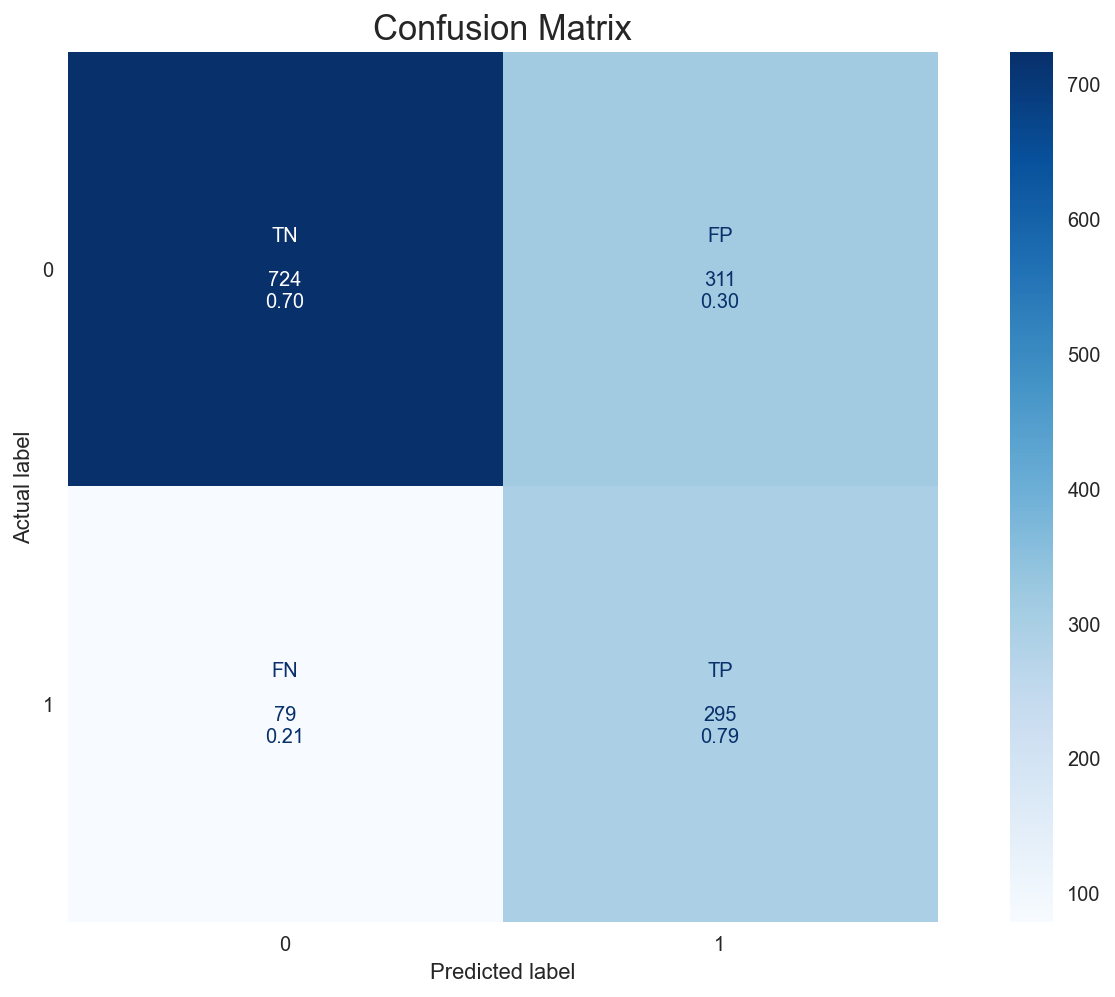

In [120]:
plot_cm(best_lr)

We'd have lost 79 customers, who were not contacted in an attempt to preserve them as customers,  
since the model wrongly predicted that they'll stay with the company.

##### Plot Curves

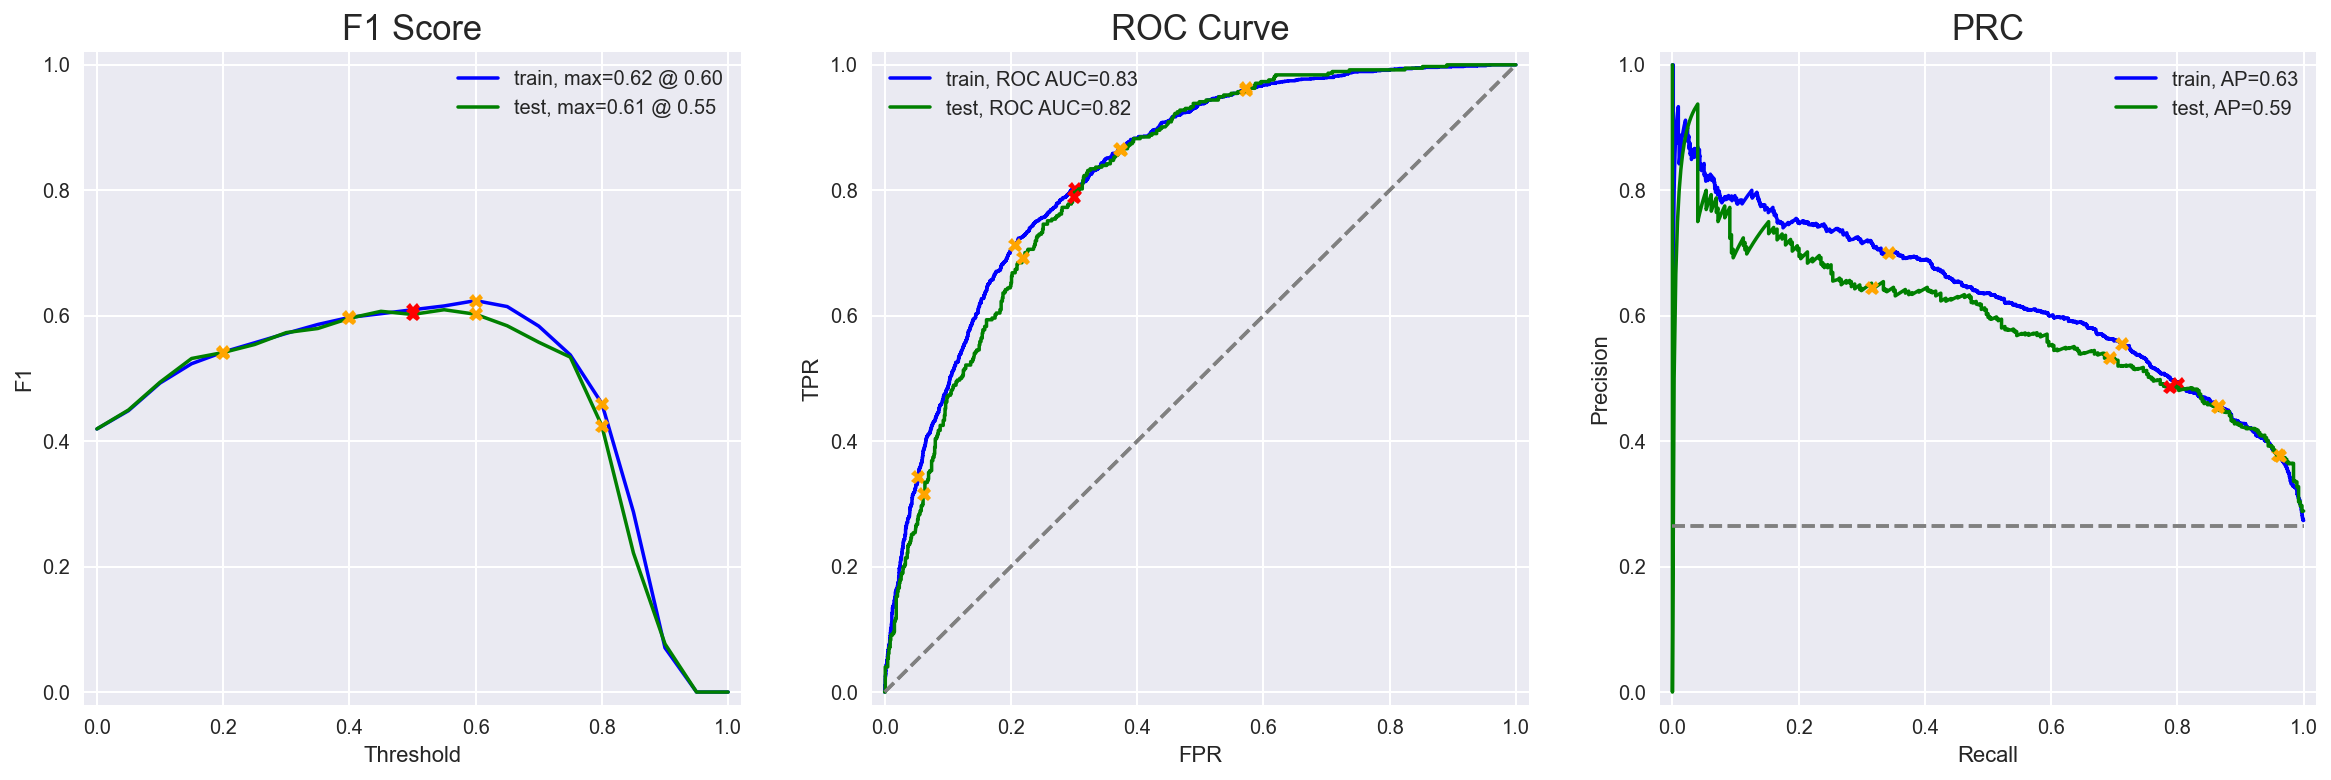

In [121]:
plot_curves(best_lr)

Train and test performance are similar - model is not overfit.

##### Scores<a id="LR-Scores"></a>

In [122]:
best_scores(best_lr)

Name of experiment: lr_balanced_filtered
Best Recall:  0.789
Best ROC_AUC: 0.823


<br>

#### Random Forest

In [123]:
run_model(pipeline(RandomForestClassifier(n_jobs=-1, random_state=random_state)), 
          X, y)['scores'].round(3)

seconds     tn     fp    fn    tp  recall  roc_auc     f1  accuracy  \
train      0.0  1.000  0.000  0.00  1.00    1.00    1.000  1.000     1.000   
test       0.0  0.927  0.073  0.42  0.58    0.58    0.878  0.651     0.835   

       fn_count  
train       0.0  
test      157.0

##### Feature Importance

In [124]:
report_importances(pipeline(RandomForestClassifier(class_weight='balanced', random_state=random_state)), X, y, 
                   threshold=.03)

Tenure                            0.248954
TotalCharges                      0.231697
MonthlyCharges                    0.178773
Type_Two year                     0.078189
PaymentMethod_Electronic check    0.049552
Type_One year                     0.039164
Internet                          0.032761
dtype: float64

In [125]:
report_importances(pipeline(RandomForestClassifier(class_weight='balanced', random_state=random_state)), X, y, 
                   permutation=True, 
                   threshold=.01)

TotalCharges      0.100213
Tenure            0.061391
Type              0.048048
MonthlyCharges    0.031725
Internet          0.020653
dtype: float64

In [126]:
rf_cat = None
rf_ohe = ['Type', 'Internet']

##### Compare Balancing Methods

In [127]:
def rf_experiments():
    return compare_experiments({
        'balanced':            pipeline(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=random_state)), 
        
        'balanced_filtered':   pipeline(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=random_state),
                                        ordinal=rf_cat,
                                        one_hot=rf_ohe), 
        
        'upsample':            pipeline(RandomForestClassifier(n_jobs=-1, random_state=random_state), upsample=True),
        
        'upsample_filtered':   pipeline(RandomForestClassifier(n_jobs=-1, random_state=random_state), upsample=True,
                                        ordinal=rf_cat,
                                        one_hot=rf_ohe),
        
        'downsample':          pipeline(RandomForestClassifier(n_jobs=-1, random_state=random_state), downsample=True),
        
        'downsample_filtered': pipeline(RandomForestClassifier(n_jobs=-1, random_state=random_state), downsample=True,
                                        ordinal=rf_cat,
                                        one_hot=rf_ohe),
    })

In [128]:
best_rf = rf_experiments()

##### Halving Random Search

In [129]:
# # takes too much time, kept as reference.

# %%time

# rf_halving = run_model(pipeline(RandomForestClassifier(n_jobs=2, random_state=random_state), downsample=True,
#                                 ordinal=None,
#                                 one_hot=rf_ohe),
#                        X, y,
#                        hyperparams={
#                            'n_estimators': np.arange(145, 155),
#                            'max_depth': [None, *np.arange(2, 10)],
#                            'min_samples_split': (2, 15),
#                            'min_samples_leaf': (1, 10),
#                        }, n_jobs=2)
# rf_halving['scores'].round(3)

Halving Random takes much more time compared to the bayesian method, with similar results.  
Leaving it here as reference only.

##### Bayes Search

In [130]:
%%time

rf_bayes = run_model(pipeline(RandomForestClassifier(n_jobs=2, random_state=random_state), downsample=True,
                              ordinal=rf_cat,
                              one_hot=rf_ohe), 
                     X, y, 
                     search=BayesSearchCV, 
                     hyperparams={
                         'n_estimators': (200, 500),
                         'max_depth': (50, 150),
                         'min_samples_split': (2, 10),
                         'min_samples_leaf': (1, 10),
                         # 'max_leaf_nodes': [None, *np.arange(2, 15)],
                     }, n_iter=64, n_jobs=2)

rf_bayes['scores']['name'] = 'rf_downsample_filtered'
rf_bayes['scores'].round(3)

best params
{'max_depth': 122,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 243}

CPU times: user 7min 19s, sys: 1min 5s, total: 8min 25s
Wall time: 3min 12s


seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      1.0  0.828  0.172  0.107  0.893   0.893    0.947  0.754     0.845   
test       0.0  0.811  0.189  0.179  0.821   0.821    0.903  0.700     0.813   

       fn_count                    name  
train     160.0  rf_downsample_filtered  
test       67.0  rf_downsample_filtered

In [131]:
best_rf = rf_bayes

##### Confusion Matrix

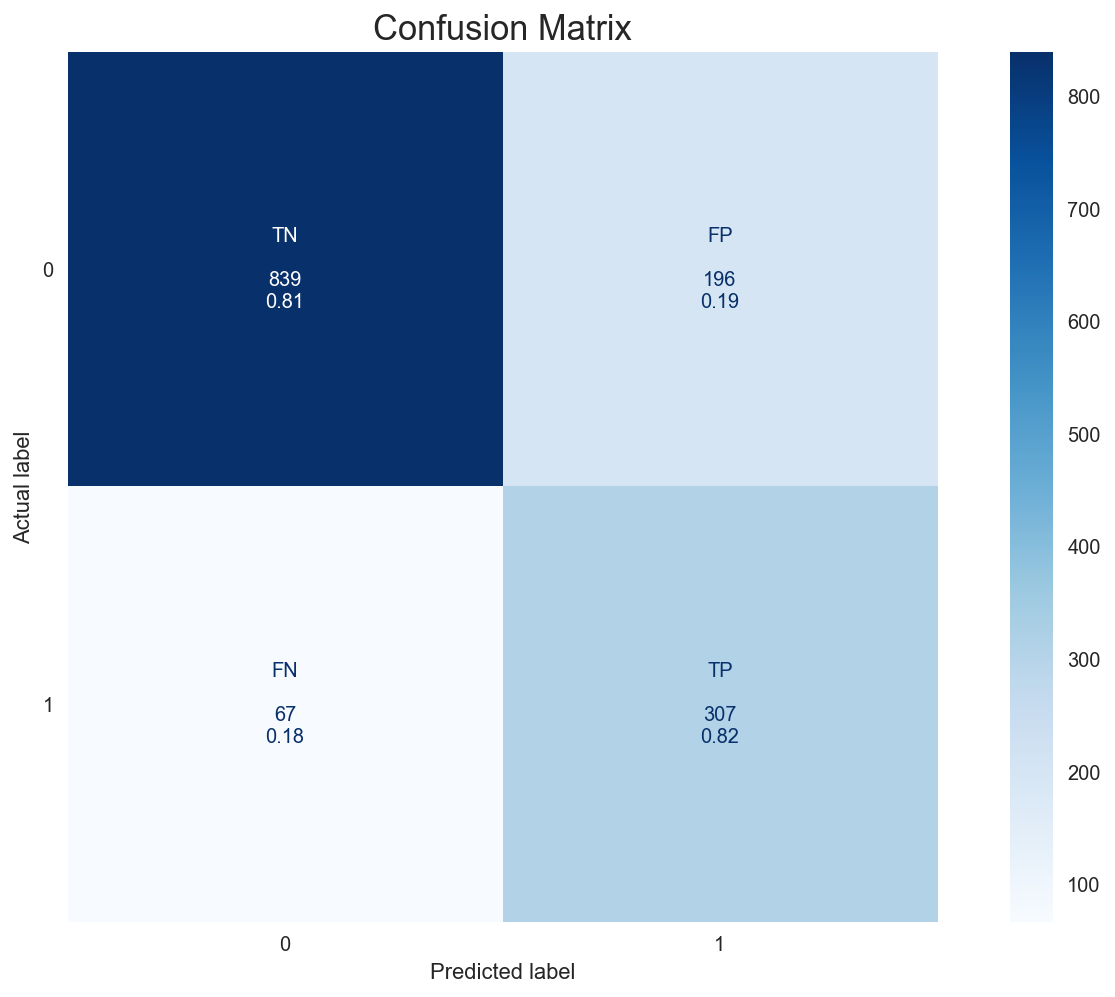

In [132]:
plot_cm(best_rf)

We'd have lost 67 customers.

##### Plot Curves

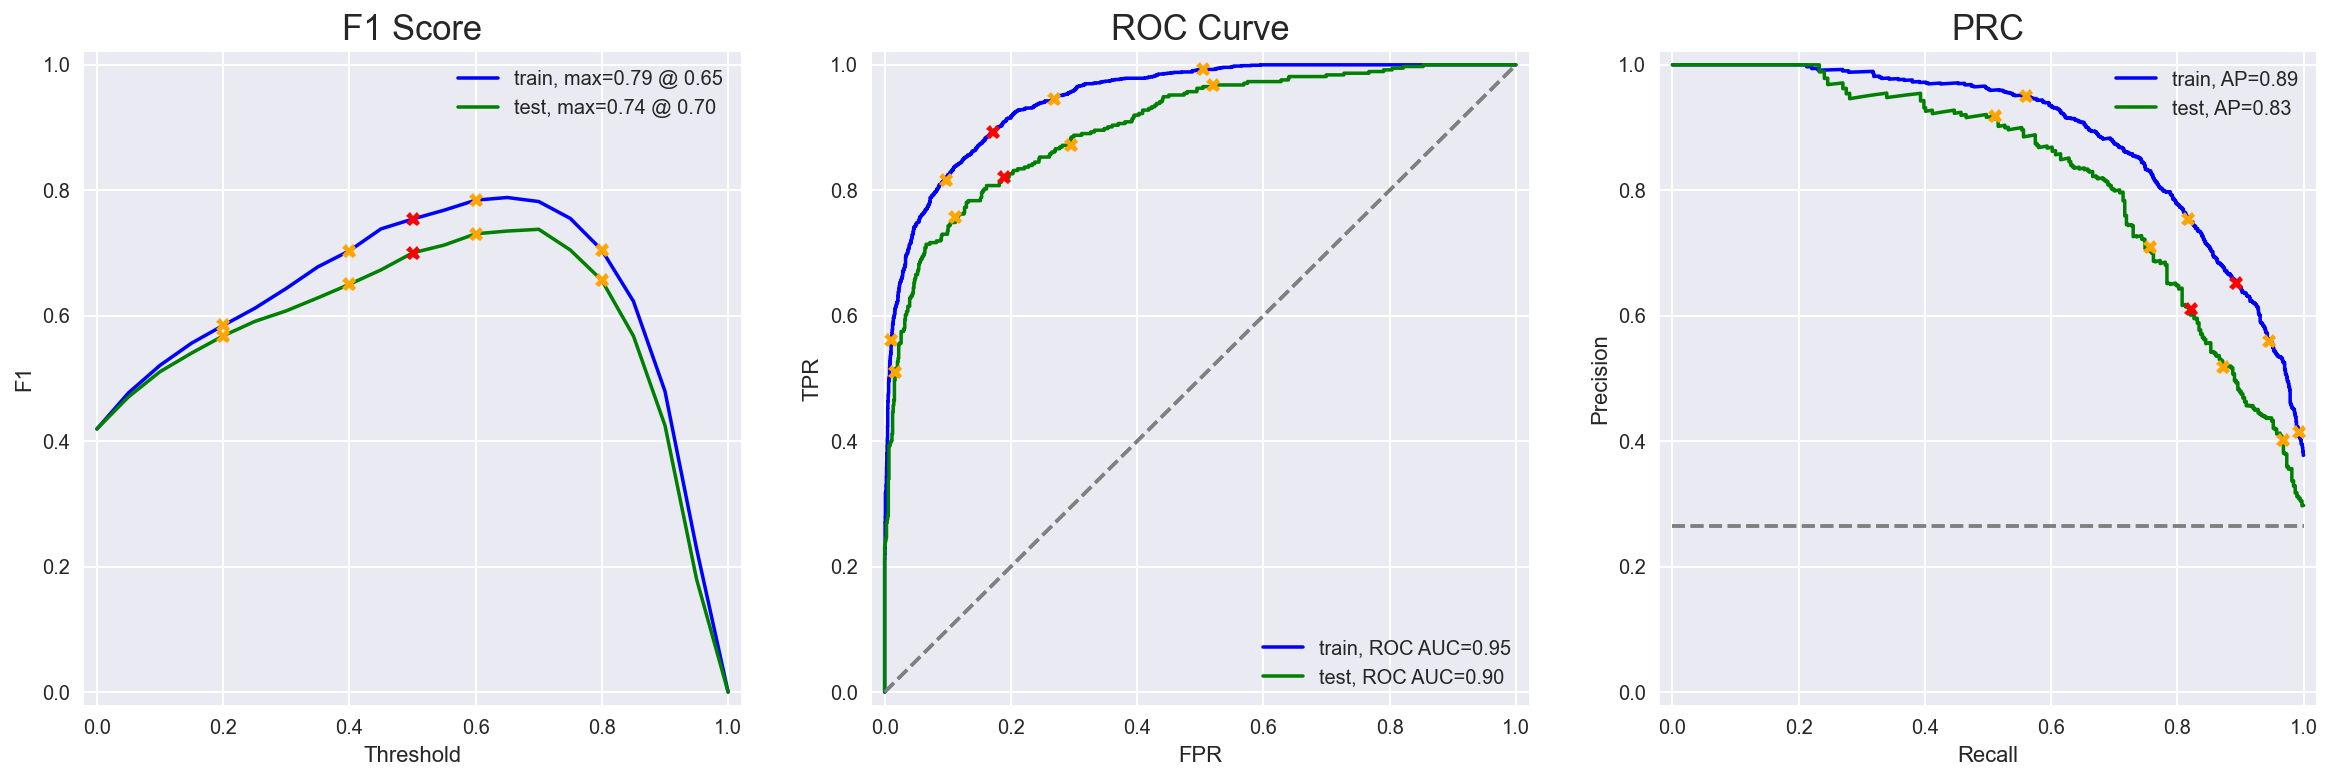

In [133]:
plot_curves(best_rf)

The model is slightly overfit, which could prove problematic for out of sample data.  
For the moment, the model satisfies the required metric thresholds.

##### Scores<a id="RF-Scores"></a>

In [134]:
best_scores(best_rf)

Name of experiment: rf_downsample_filtered
Best Recall:  0.821
Best ROC_AUC: 0.903


<br>

#### Gradient Boosting

In [135]:
run_model(pipeline(GradientBoostingClassifier(random_state=random_state)),
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      0.0  0.972  0.028  0.373  0.627   0.627    0.923  0.737     0.881   
test       0.0  0.953  0.047  0.385  0.615   0.615    0.910  0.704     0.863   

       fn_count  
train     557.0  
test      144.0

##### Feature Importance

In [136]:
report_importances(pipeline(GradientBoostingClassifier(random_state=random_state)), X, y, threshold=.01)

Tenure                            0.360588
TotalCharges                      0.169758
PaymentMethod_Electronic check    0.124320
MonthlyCharges                    0.124144
Type_Two year                     0.098875
Type_One year                     0.074495
Internet                          0.028953
PaperlessBilling                  0.013164
dtype: float64

In [137]:
report_importances(pipeline(GradientBoostingClassifier(random_state=random_state)), X, y, permutation=True, threshold=.007)

TotalCharges      0.237828
Tenure            0.097232
MonthlyCharges    0.094819
Type              0.019801
Internet          0.007452
dtype: float64

In [138]:
gb_cat = None
gb_ohe = ['Type', 'Internet']

##### Compare Balancing Methods

In [139]:
def gb_experiments():
    return compare_experiments({
        'default':             pipeline(GradientBoostingClassifier(random_state=random_state)), 
        
        'default_filtered':    pipeline(GradientBoostingClassifier(random_state=random_state),
                                        ordinal=gb_cat,
                                        one_hot=gb_ohe), 
        
        'upsample':            pipeline(GradientBoostingClassifier(random_state=random_state), upsample=True),
        
        'upsample_filtered':   pipeline(GradientBoostingClassifier(random_state=random_state), upsample=True,
                                        ordinal=gb_cat,
                                        one_hot=gb_ohe),
        
        'downsample':          pipeline(GradientBoostingClassifier(random_state=random_state), downsample=True),
        
        'downsample_filtered': pipeline(GradientBoostingClassifier(random_state=random_state), downsample=True,
                                        ordinal=gb_cat,
                                        one_hot=gb_ohe),
    })

In [140]:
best_gb = gb_experiments()

##### Bayes Search

In [141]:
%%time

gb_bayes = run_model(pipeline(GradientBoostingClassifier(random_state=random_state), upsample=True,
                              ordinal=gb_cat,
                              one_hot=gb_ohe), 
                     X, y,
                     search=BayesSearchCV, 
                     hyperparams={
                         'learning_rate': (1e-1, 1.0, 'log-uniform'), 
                         'n_estimators': (800, 1500),
                         'max_depth': (1, 10),
                     }, n_iter=32, n_jobs=-1)

gb_bayes['scores']['name'] = 'gb_upsample_filtered'
gb_bayes['scores'].round(3)

best params
{'learning_rate': 0.6128331085110219, 'max_depth': 1, 'n_estimators': 1491}

CPU times: user 2min 7s, sys: 17.3 s, total: 2min 25s
Wall time: 3min 26s


seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      6.0  0.916  0.084  0.101  0.899   0.899    0.968  0.843     0.911   
test       0.0  0.903  0.097  0.126  0.874   0.874    0.950  0.816     0.896   

       fn_count                  name  
train     151.0  gb_upsample_filtered  
test       47.0  gb_upsample_filtered

In [142]:
best_gb = gb_bayes

##### Confusion Matrix

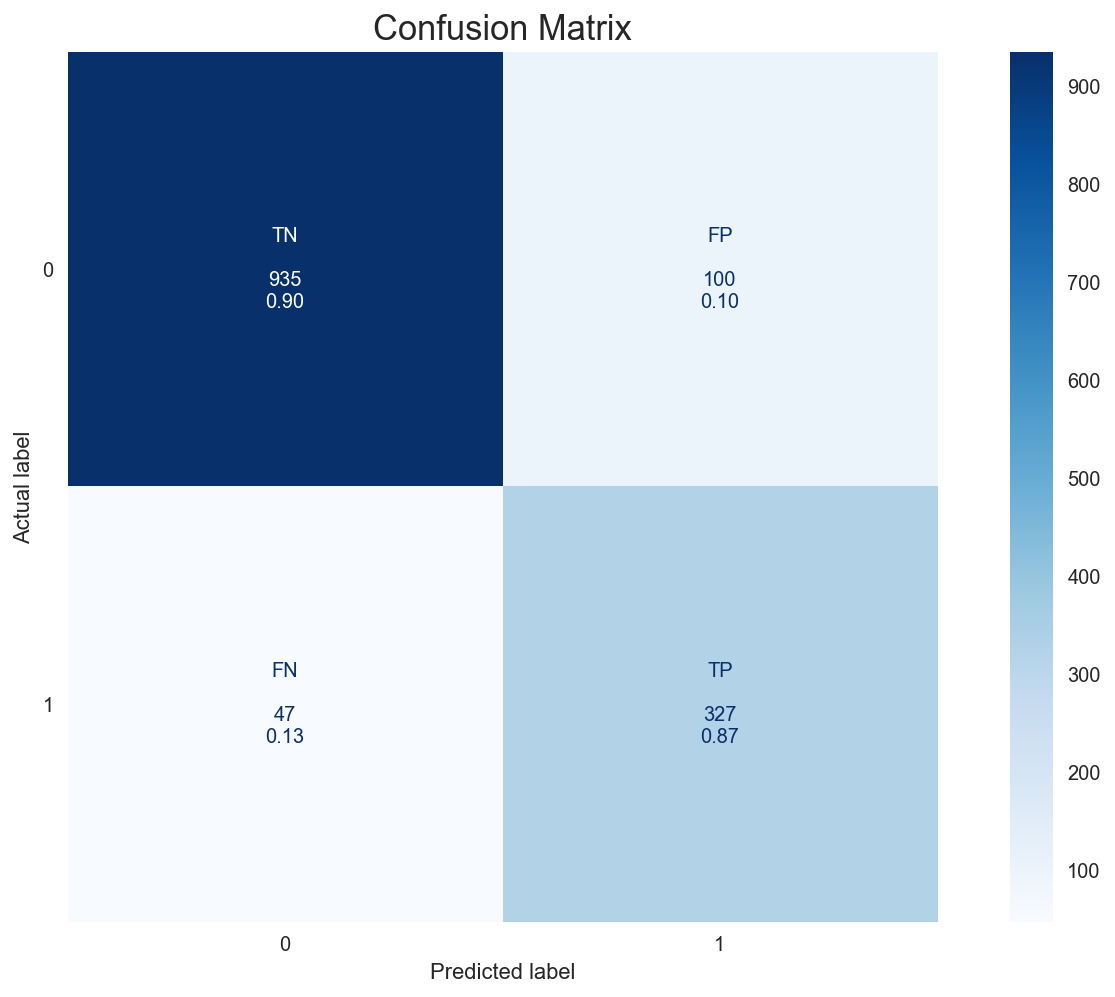

In [143]:
plot_cm(best_gb)

We'd have lost 47 customers.

##### Plot Curves

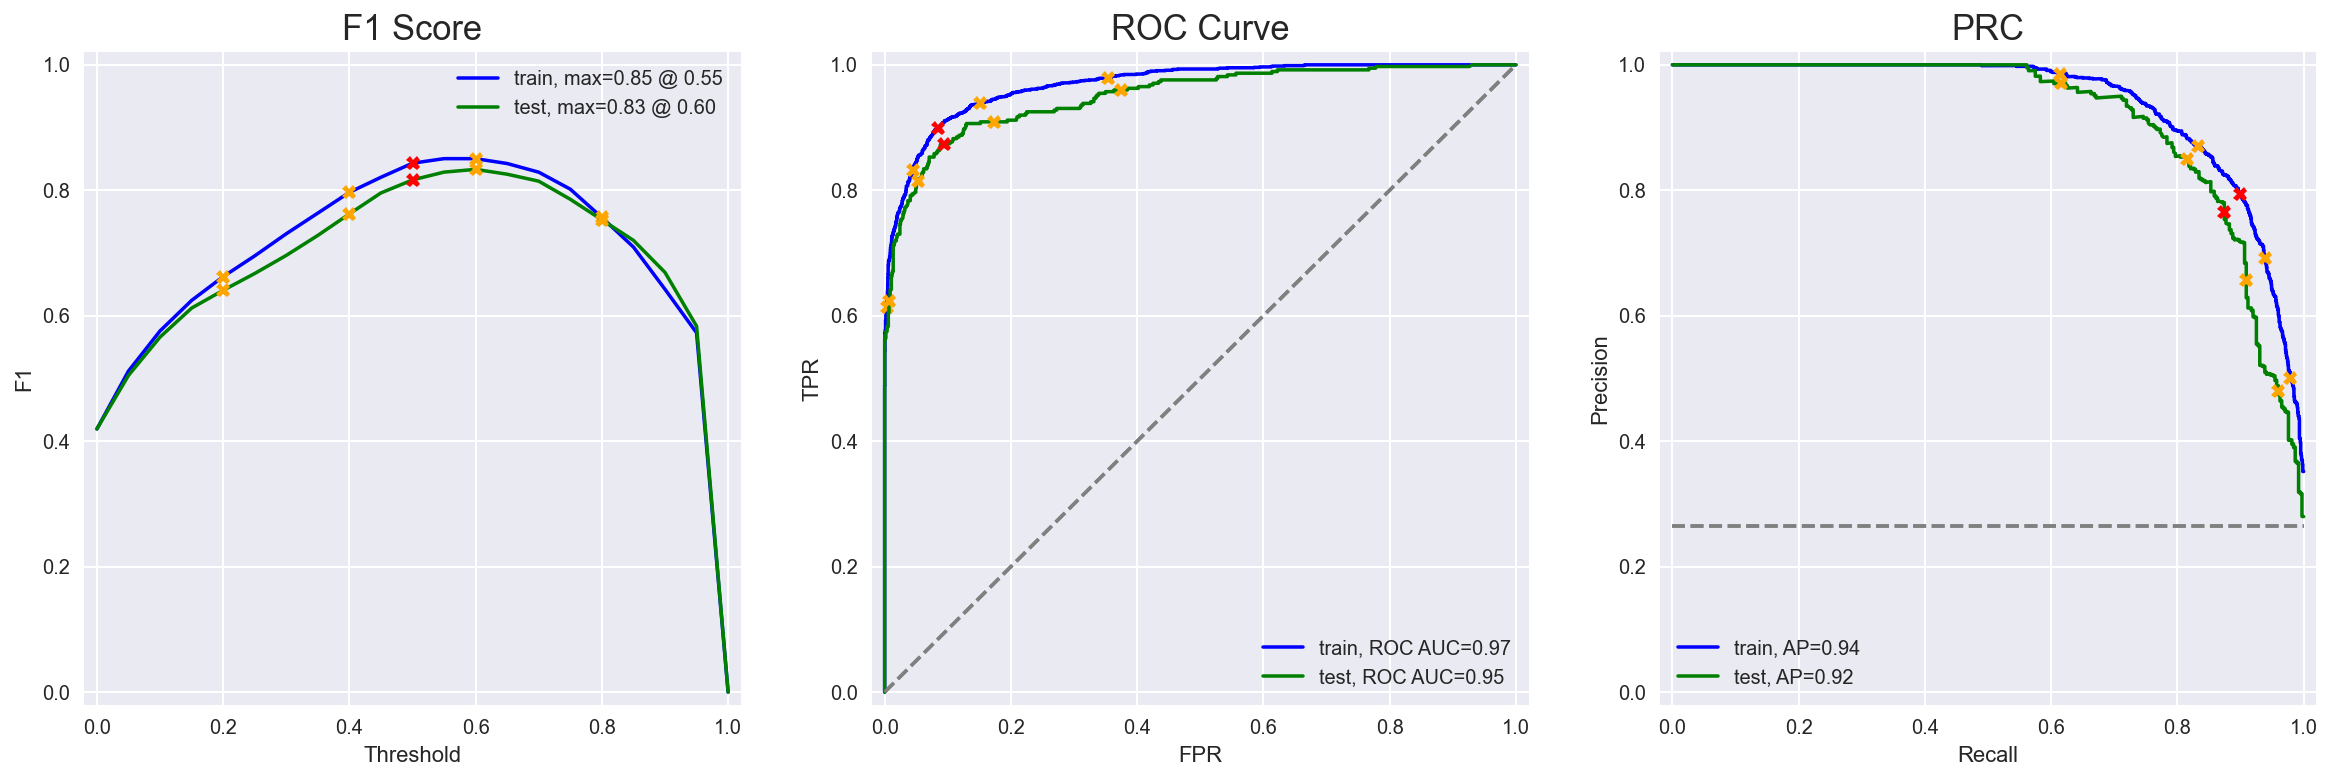

In [144]:
plot_curves(best_gb)

The model is slightly overfit.

##### Scores<a id="GB-Scores"></a>

In [145]:
best_scores(best_gb)

Name of experiment: gb_upsample_filtered
Best Recall:  0.874
Best ROC_AUC: 0.950


<br>

#### XGBoost

In [146]:
run_model(pipeline(xgb.XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=random_state)),
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      2.0  0.998  0.002  0.044  0.956   0.956    0.999  0.975     0.987   
test       0.0  0.965  0.035  0.251  0.749   0.749    0.946  0.812     0.908   

       fn_count  
train      66.0  
test       94.0

##### Feature Importance

In [147]:
report_importances(pipeline(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                                              n_jobs=-1, random_state=random_state)), X, y)

Type_Two year                            0.441393
Type_One year                            0.139836
PaymentMethod_Electronic check           0.113106
Internet                                 0.104587
Tenure                                   0.031533
TotalCharges                             0.028210
MonthlyCharges                           0.025013
PaperlessBilling                         0.020430
Telephone                                0.018347
Dependents                               0.014545
PaymentMethod_Mailed check               0.014437
PaymentMethod_Credit card (automatic)    0.013478
SeniorCitizen                            0.013263
Gender                                   0.012263
Partner                                  0.009560
dtype: float32

In [148]:
report_importances(pipeline(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                                              n_jobs=-1, random_state=random_state)),
                   X, y, permutation=True)

TotalCharges        0.395955
MonthlyCharges      0.275302
Tenure              0.223066
Type                0.035912
PaperlessBilling    0.005820
PaymentMethod       0.002413
Gender              0.001632
Internet            0.000923
SeniorCitizen      -0.000710
Dependents         -0.000426
Partner            -0.000142
Telephone           0.000071
dtype: float64

In [149]:
xgb_cat = None
xgb_ohe = ['Type']

##### Compare Balancing Methods

In [150]:
def xgb_experiments():
    return compare_experiments({
        'weighted':             pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state, 
                                                           scale_pos_weight=y_ratio)), 
        
        'weighted_filtered':    pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state, 
                                                           scale_pos_weight=y_ratio),
                                         ordinal=xgb_cat,
                                         one_hot=xgb_ohe), 
        
        'upsample':             pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state), upsample=True),
        
        'upsample_filtered':    pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state), upsample=True,
                                         ordinal=xgb_cat,
                                         one_hot=xgb_ohe),
        
        'downsample':           pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state), downsample=True),
        
        'downsample_filtered':  pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                           n_jobs=-1, random_state=random_state), downsample=True,
                                         ordinal=xgb_cat,
                                         one_hot=xgb_ohe),
    })

In [151]:
best_xgb = xgb_experiments()

##### Bayes Search

In [152]:
%%time

xgb_bayes = run_model(pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', 
                                                 n_jobs=2, random_state=random_state), 
                               downsample=True,
                               ordinal=xgb_cat,
                               one_hot=xgb_ohe),
                      X, y,
                      search=BayesSearchCV, 
                      hyperparams={
                          'booster': ['gbtree', 'gblinear', 'dart'],
                          'n_estimators': (1000, 1500),
                          'max_depth': (0, 10),
                          'learning_rate': (1e-1, 1e+1, 'log-uniform'),
                          'gamma': (1e-2, 1e+1, 'log-uniform'),
                      }, 
                      n_iter=32, 
                      n_jobs=2)

xgb_bayes['scores']['name'] = 'xgb_downsample_filtered'
xgb_bayes['scores'].round(3)

best params
{'booster': 'dart',
 'gamma': 0.010583978130532565,
 'learning_rate': 1.0030674201933492,
 'max_depth': 3,
 'n_estimators': 1000}

CPU times: user 3min 49s, sys: 14 s, total: 4min 3s
Wall time: 6min 21s


seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      3.0  0.923  0.077  0.000  1.000   1.000    0.995  0.904     0.944   
test       0.0  0.895  0.105  0.126  0.874   0.874    0.954  0.807     0.889   

       fn_count                     name  
train       0.0  xgb_downsample_filtered  
test       47.0  xgb_downsample_filtered

In [153]:
best_xgb = xgb_bayes

##### Confusion Matrix

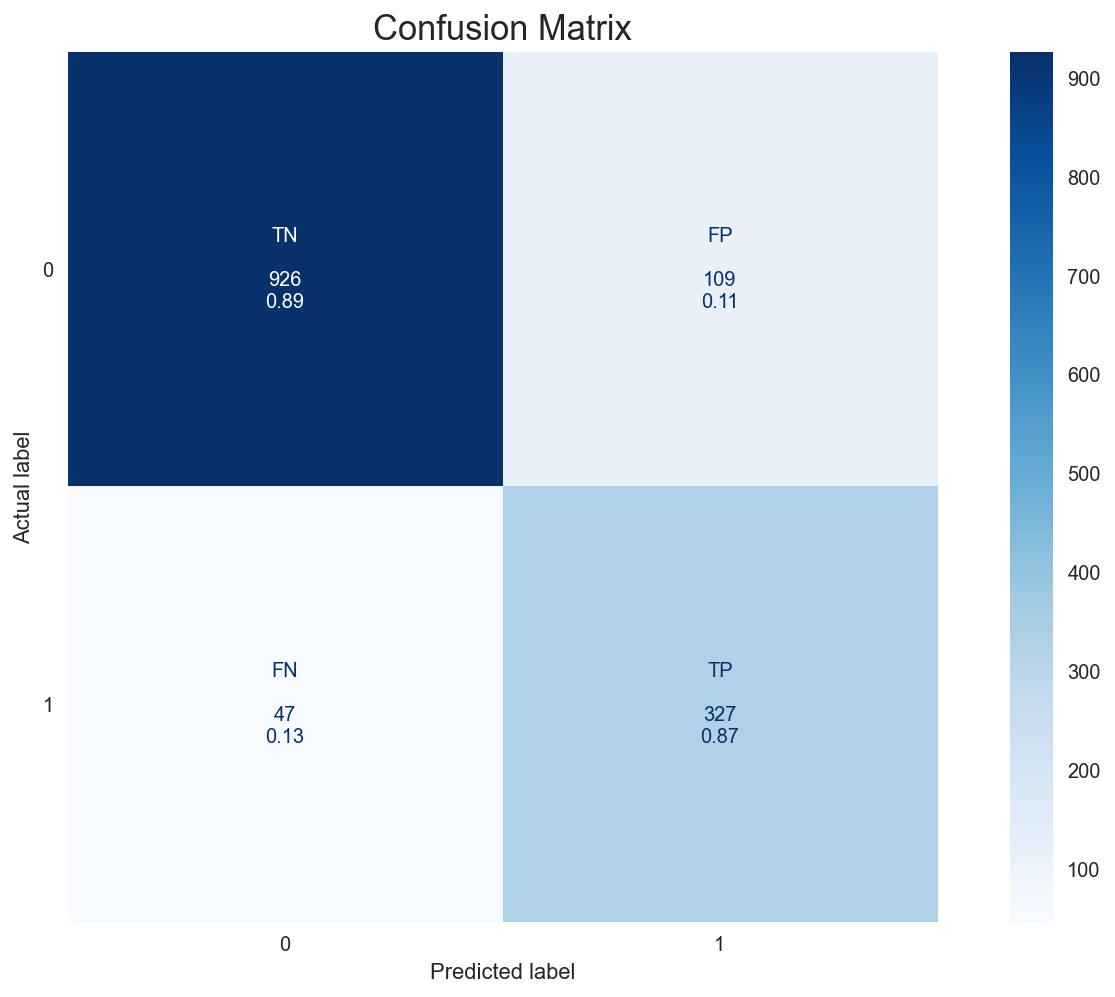

In [154]:
plot_cm(best_xgb)

We'd have lost 47 customers.

##### Plot Curves

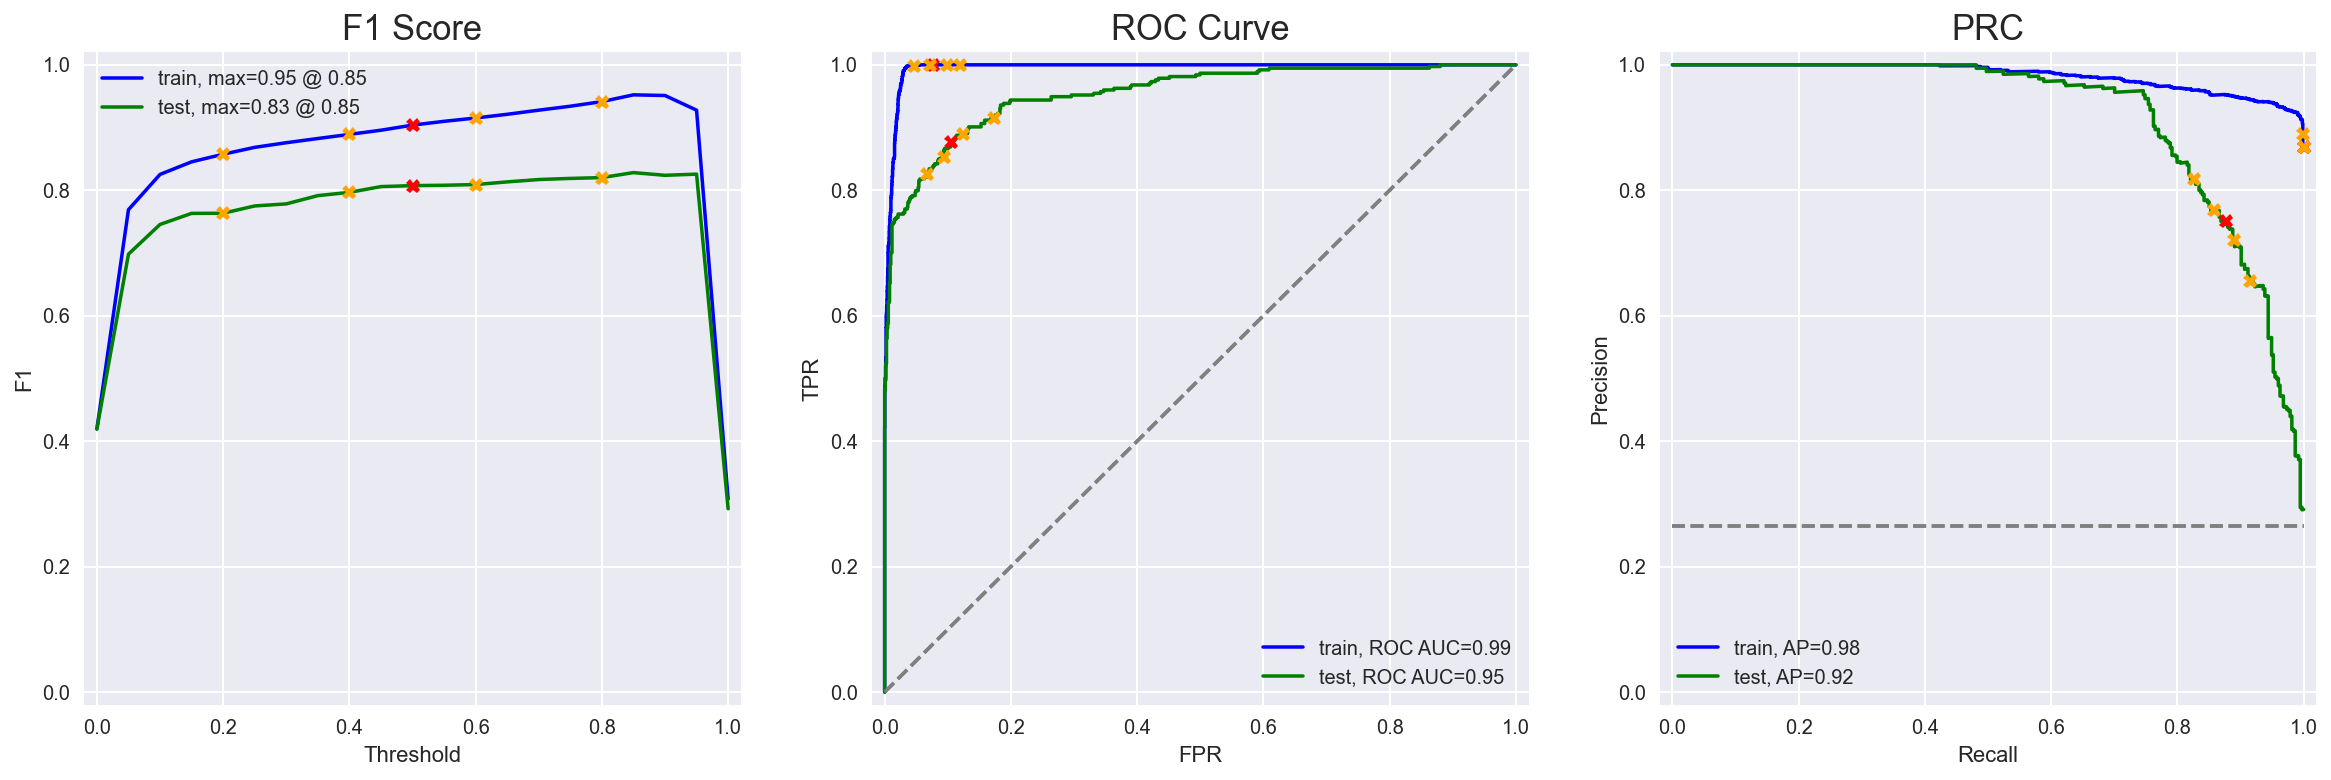

In [155]:
plot_curves(best_xgb)

The model is moderately overfit.

##### Scores<a id="XGB-Scores"></a>

In [156]:
best_scores(best_xgb)

Name of experiment: xgb_downsample_filtered
Best Recall:  0.874
Best ROC_AUC: 0.954


<br>

#### LightGBM

In [157]:
run_model(pipeline(lgb.LGBMClassifier(metric=scoring, n_jobs=-1, random_state=random_state)),
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      0.0  0.992  0.008  0.181  0.819   0.819    0.988  0.889     0.946   
test       0.0  0.960  0.040  0.289  0.711   0.711    0.933  0.781     0.894   

       fn_count  
train     270.0  
test      108.0

##### Feature Importance

In [158]:
report_importances(pipeline(lgb.LGBMClassifier(metric=scoring, is_unbalance=True,
                                               n_jobs=-1, random_state=random_state)), X, y, threshold=100)

TotalCharges      1061
Tenure             925
MonthlyCharges     642
dtype: int32

In [159]:
report_importances(pipeline(lgb.LGBMClassifier(metric=scoring, is_unbalance=True,
                                               n_jobs=-1, random_state=random_state)),
                   X, y, permutation=True, threshold=.03)

TotalCharges      0.313485
MonthlyCharges    0.194109
Tenure            0.167566
Type              0.031796
dtype: float64

In [160]:
lgbm_cat = None
lgbm_ohe = ['Type']

##### Compare Balancing Methods

In [161]:
def lgbm_experiments():
    return compare_experiments({
        'balanced':             pipeline(lgb.LGBMClassifier(metric=scoring, is_unbalance=True, 
                                                            n_jobs=-1, random_state=random_state)), 
        
        'balanced_filtered':    pipeline(lgb.LGBMClassifier(metric=scoring, is_unbalance=True,
                                                            n_jobs=-1, random_state=random_state),
                                         ordinal=lgbm_cat,
                                         one_hot=lgbm_ohe), 
        
        'upsample':             pipeline(lgb.LGBMClassifier(n_jobs=-1, random_state=random_state, 
                                                            metric=scoring), upsample=True),
        
        'upsample_filtered':    pipeline(lgb.LGBMClassifier(n_jobs=-1, random_state=random_state, 
                                                            metric=scoring), upsample=True,
                                         ordinal=lgbm_cat,
                                         one_hot=lgbm_ohe),
        
        'downsample':           pipeline(lgb.LGBMClassifier(n_jobs=-1, random_state=random_state, 
                                                            metric=scoring), downsample=True),
        
        'downsample_filtered':  pipeline(lgb.LGBMClassifier(n_jobs=-1, random_state=random_state, 
                                                            metric=scoring), downsample=True,
                                         ordinal=lgbm_cat,
                                         one_hot=lgbm_ohe),
    })

In [162]:
best_lgbm = lgbm_experiments()

##### Bayes Search

In [163]:
%%time

lgbm_bayes = run_model(pipeline(lgb.LGBMClassifier(metric=scoring, n_jobs=2, random_state=random_state),
                                downsample=True),
                       X, y,
                       search=BayesSearchCV, 
                       hyperparams={
                           'n_estimators': (400, 800),
                           'max_depth': (-1, 20),
                           'learning_rate': (1e-2, 1.0, 'log-uniform'),
                           'num_leaves':  (10, 100),
                       }, n_iter=32, n_jobs=2)

lgbm_bayes['scores']['name'] = 'lgbm_downsample_filtered'
lgbm_bayes['scores'].round(3)

best params
{'learning_rate': 0.7564987407045177,
 'max_depth': 2,
 'n_estimators': 779,
 'num_leaves': 89}

CPU times: user 1min 16s, sys: 10.2 s, total: 1min 26s
Wall time: 1min 2s


seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      0.0  0.924  0.076  0.017  0.983   0.983    0.991  0.897     0.940   
test       0.0  0.892  0.108  0.126  0.874   0.874    0.959  0.804     0.887   

       fn_count                      name  
train      25.0  lgbm_downsample_filtered  
test       47.0  lgbm_downsample_filtered

In [164]:
best_lgbm = lgbm_bayes

##### Confusion Matrix

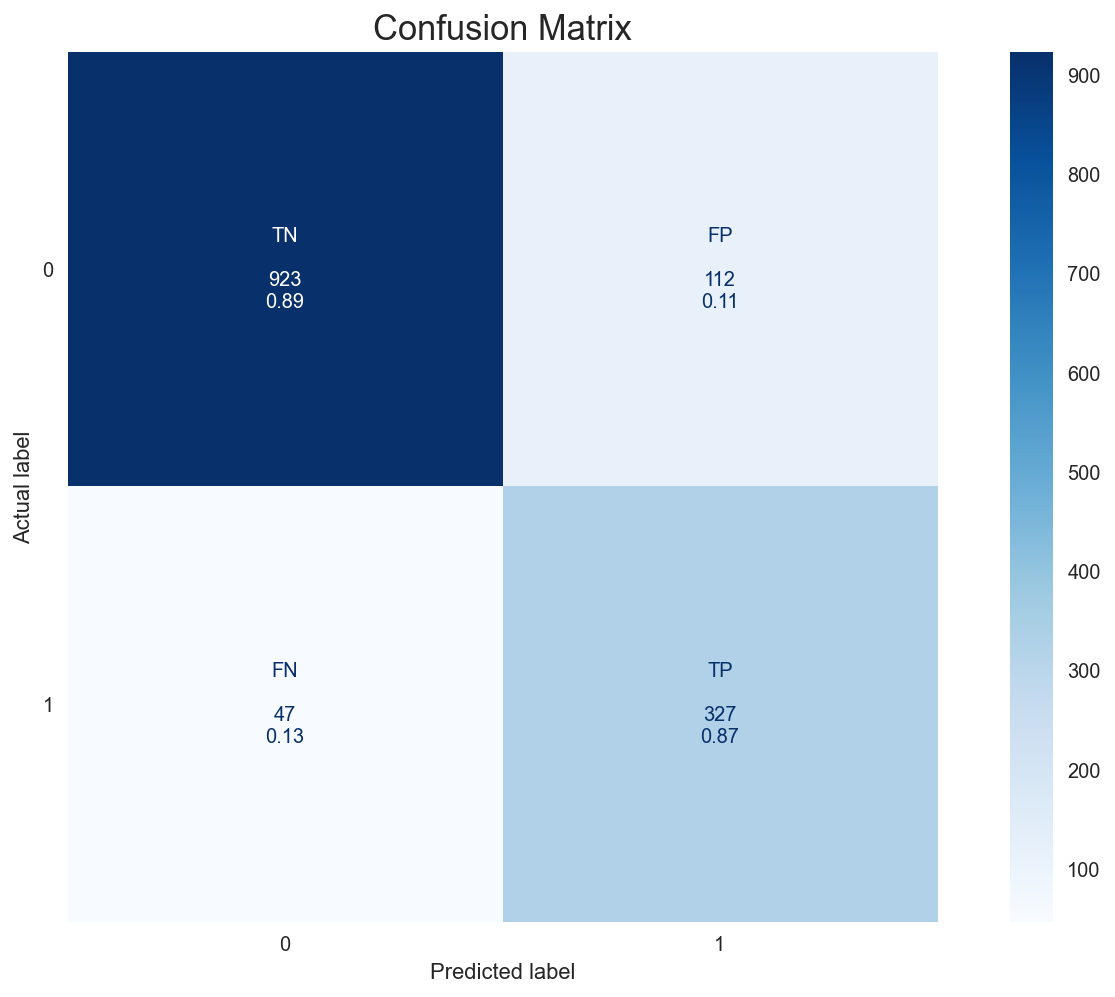

In [165]:
plot_cm(best_lgbm)

We'd have lost 47 customers.

##### Plot Curves

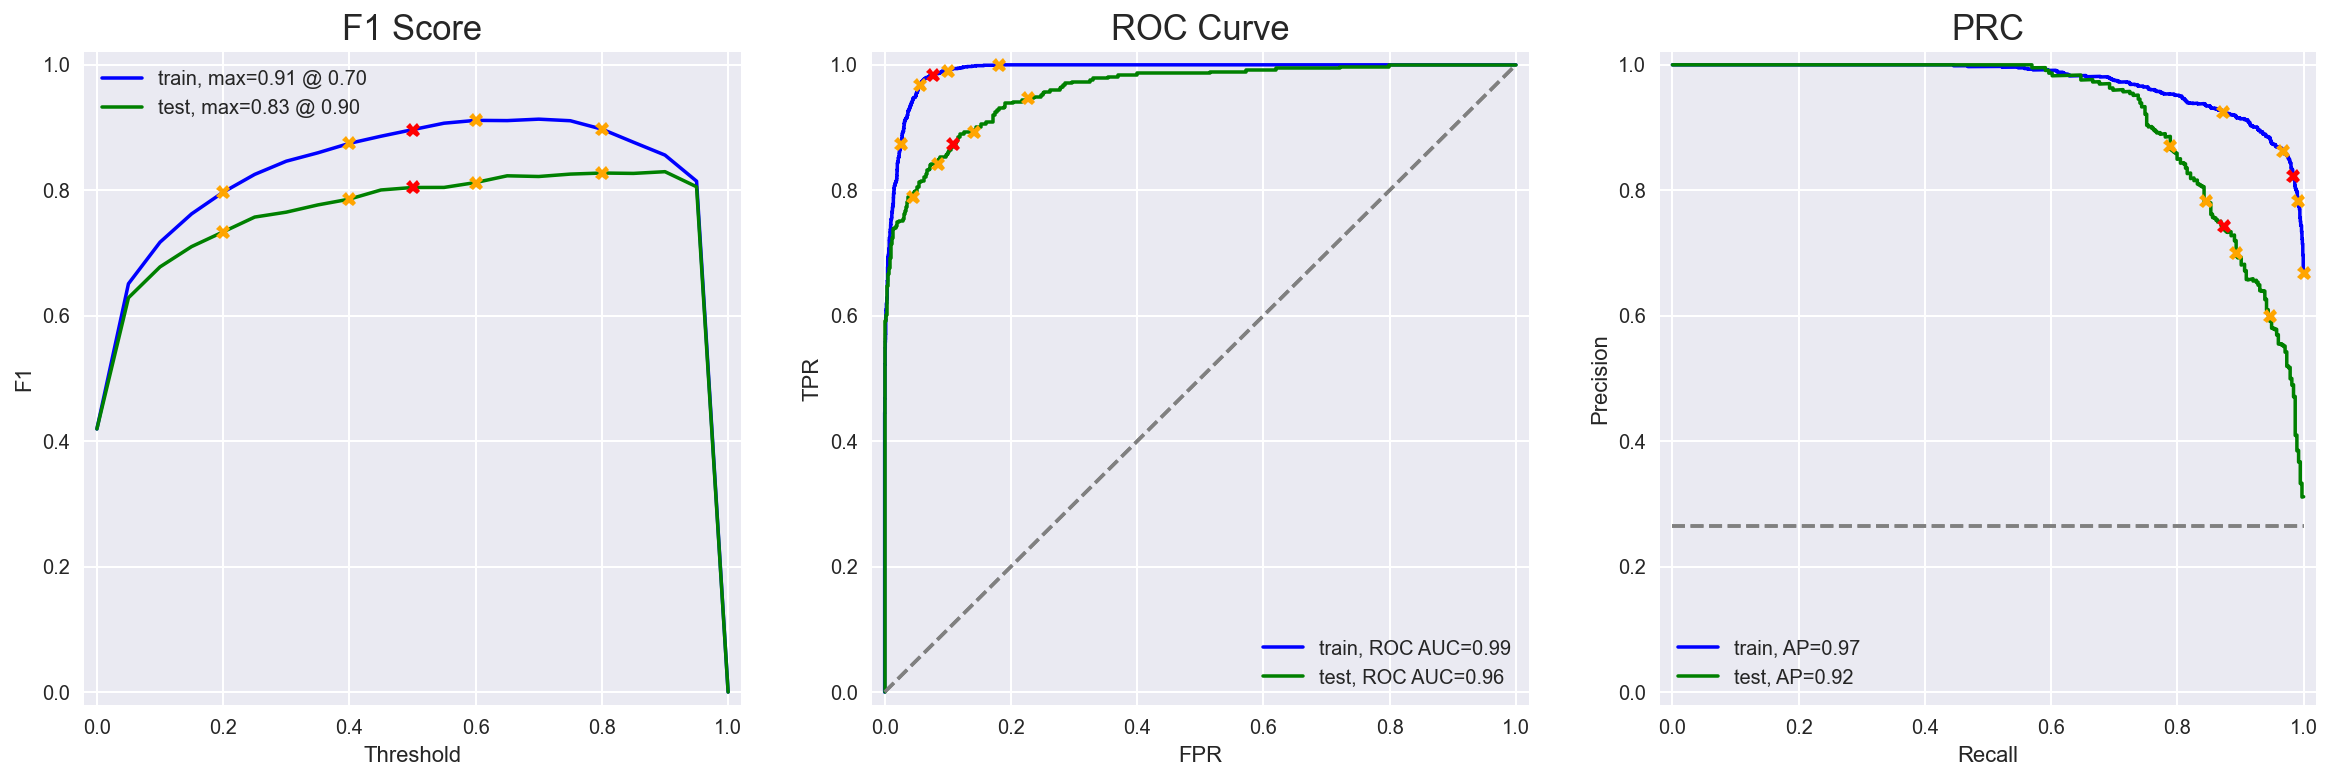

In [166]:
plot_curves(best_lgbm)

The model is moderately overfit.

##### Scores<a id="LGBM-Scores"></a>

In [167]:
best_scores(best_lgbm)

Name of experiment: lgbm_downsample_filtered
Best Recall:  0.874
Best ROC_AUC: 0.959


<br>

#### CatBoost

In [168]:
run_model(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), cat_features=np.arange(3, len(X.columns)), 
                                silent=True, random_seed=random_state),
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      6.0  0.990  0.010  0.247  0.753   0.753    0.969  0.846     0.927   
test       0.0  0.973  0.027  0.321  0.679   0.679    0.933  0.774     0.895   

       fn_count  
train     370.0  
test      120.0

In [169]:
run_model(pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), silent=True, random_seed=random_state)),
          X, y)['scores'].round(3)

seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      3.0  0.992  0.008  0.217  0.783   0.783    0.977  0.867     0.936   
test       0.0  0.972  0.028  0.307  0.693   0.693    0.936  0.782     0.898   

       fn_count  
train     325.0  
test      115.0

##### Feature Importance

In [170]:
report_importances(pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), silent=True, random_seed=random_state)),
                   X, y, threshold=2)

Tenure            31.379079
TotalCharges      29.557692
MonthlyCharges    17.334396
Type_Two year      7.404721
Internet           2.759090
Type_One year      2.600122
dtype: float64

In [171]:
cb_cat = None
cb_ohe = ['Type', 'Internet']

##### Compare Balancing Methods

In [172]:
def cb_experiments():
    return compare_experiments({
        'default':               pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state)),
        
        'default_filtered':      pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state),
                                          ordinal=cb_cat,
                                          one_hot=cb_ohe),
        
        'weighted':              pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), scale_pos_weight=y_ratio, 
                                                                silent=True, random_seed=random_state)),
        
        'weighted_filtered':     pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), scale_pos_weight=y_ratio, 
                                                                silent=True, random_seed=random_state),
                                          ordinal=cb_cat,
                                          one_hot=cb_ohe), 
                
        'upsample':              pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state), upsample=True),
         
        'upsample_filtered':     pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state), upsample=True,
                                          ordinal=cb_cat,
                                          one_hot=cb_ohe),
         
        'downsample':            pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state), downsample=True),
         
        'downsample_filtered':   pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), 
                                                                silent=True, random_seed=random_state), downsample=True,
                                          ordinal=cb_cat,
                                          one_hot=cb_ohe),
    })

In [173]:
best_cb = cb_experiments()

##### Bayes Search

In [174]:
%%time

cb_bayes = run_model(pipeline(cb.CatBoostClassifier(eval_metric=scoring.capitalize(), scale_pos_weight=y_ratio, 
                                                    silent=True, thread_count=2, random_seed=random_state), 
                              ordinal=cb_cat,
                              one_hot=cb_ohe),
                     X, y,
                     search=BayesSearchCV, 
                     hyperparams={
                         'learning_rate': (1e-1, 1.0, 'log-uniform'), 
                         'n_estimators': (500, 800),
                         'max_depth': (1, 10),
                     }, n_iter=32, n_jobs=2)

cb_bayes['scores']['name'] = 'cb_weighted_filtered'
cb_bayes['scores'].round(3)

best params
{'learning_rate': 0.9036232474239646, 'max_depth': 1, 'n_estimators': 727}

CPU times: user 1min 9s, sys: 10.1 s, total: 1min 19s
Wall time: 2min 34s


seconds     tn     fp     fn     tp  recall  roc_auc     f1  accuracy  \
train      1.0  0.899  0.101  0.104  0.896   0.896    0.965  0.824     0.899   
test       0.0  0.893  0.107  0.118  0.882   0.882    0.948  0.810     0.890   

       fn_count                  name  
train     155.0  cb_weighted_filtered  
test       44.0  cb_weighted_filtered

In [175]:
best_cb = cb_bayes

##### Confusion Matrix

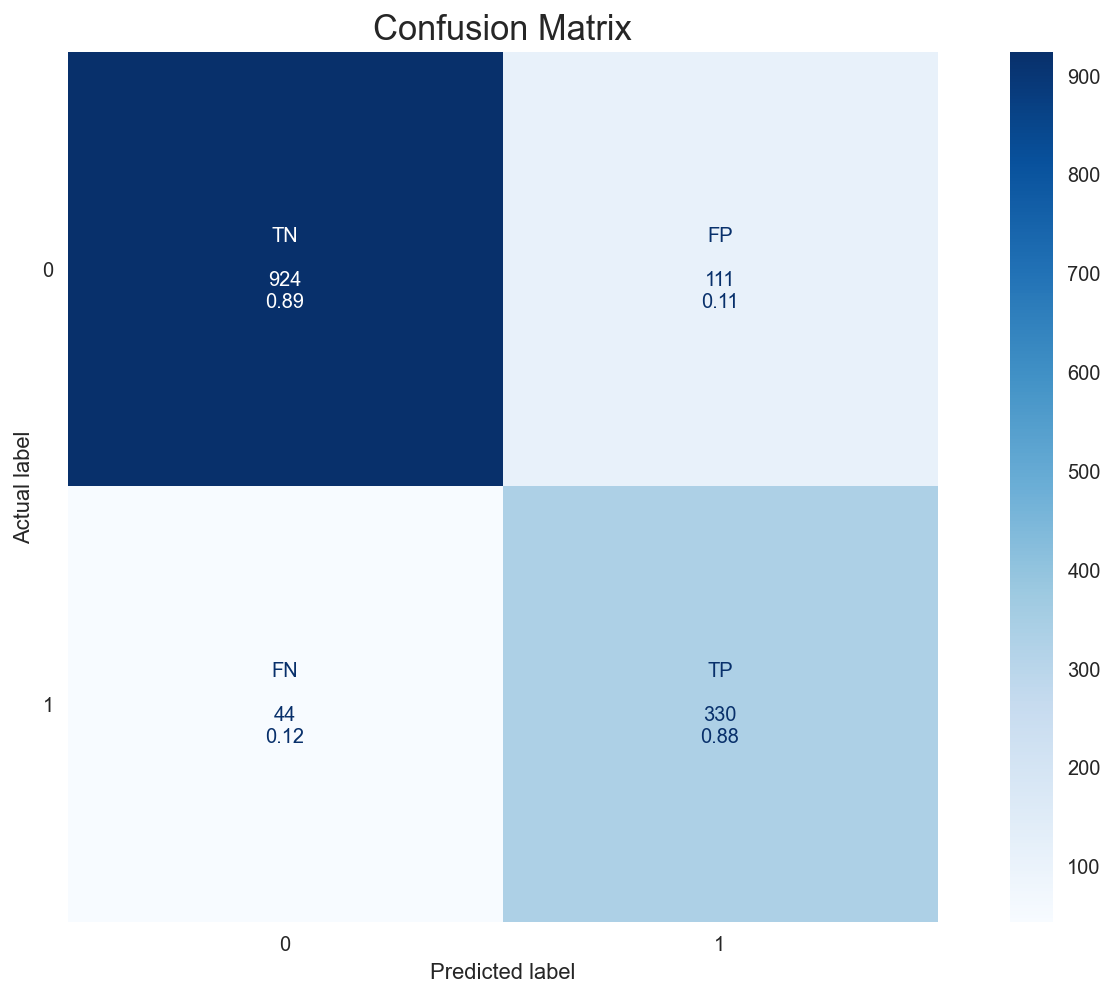

In [176]:
plot_cm(best_cb)

We'd have lost 44 customers.

##### Plot Curves

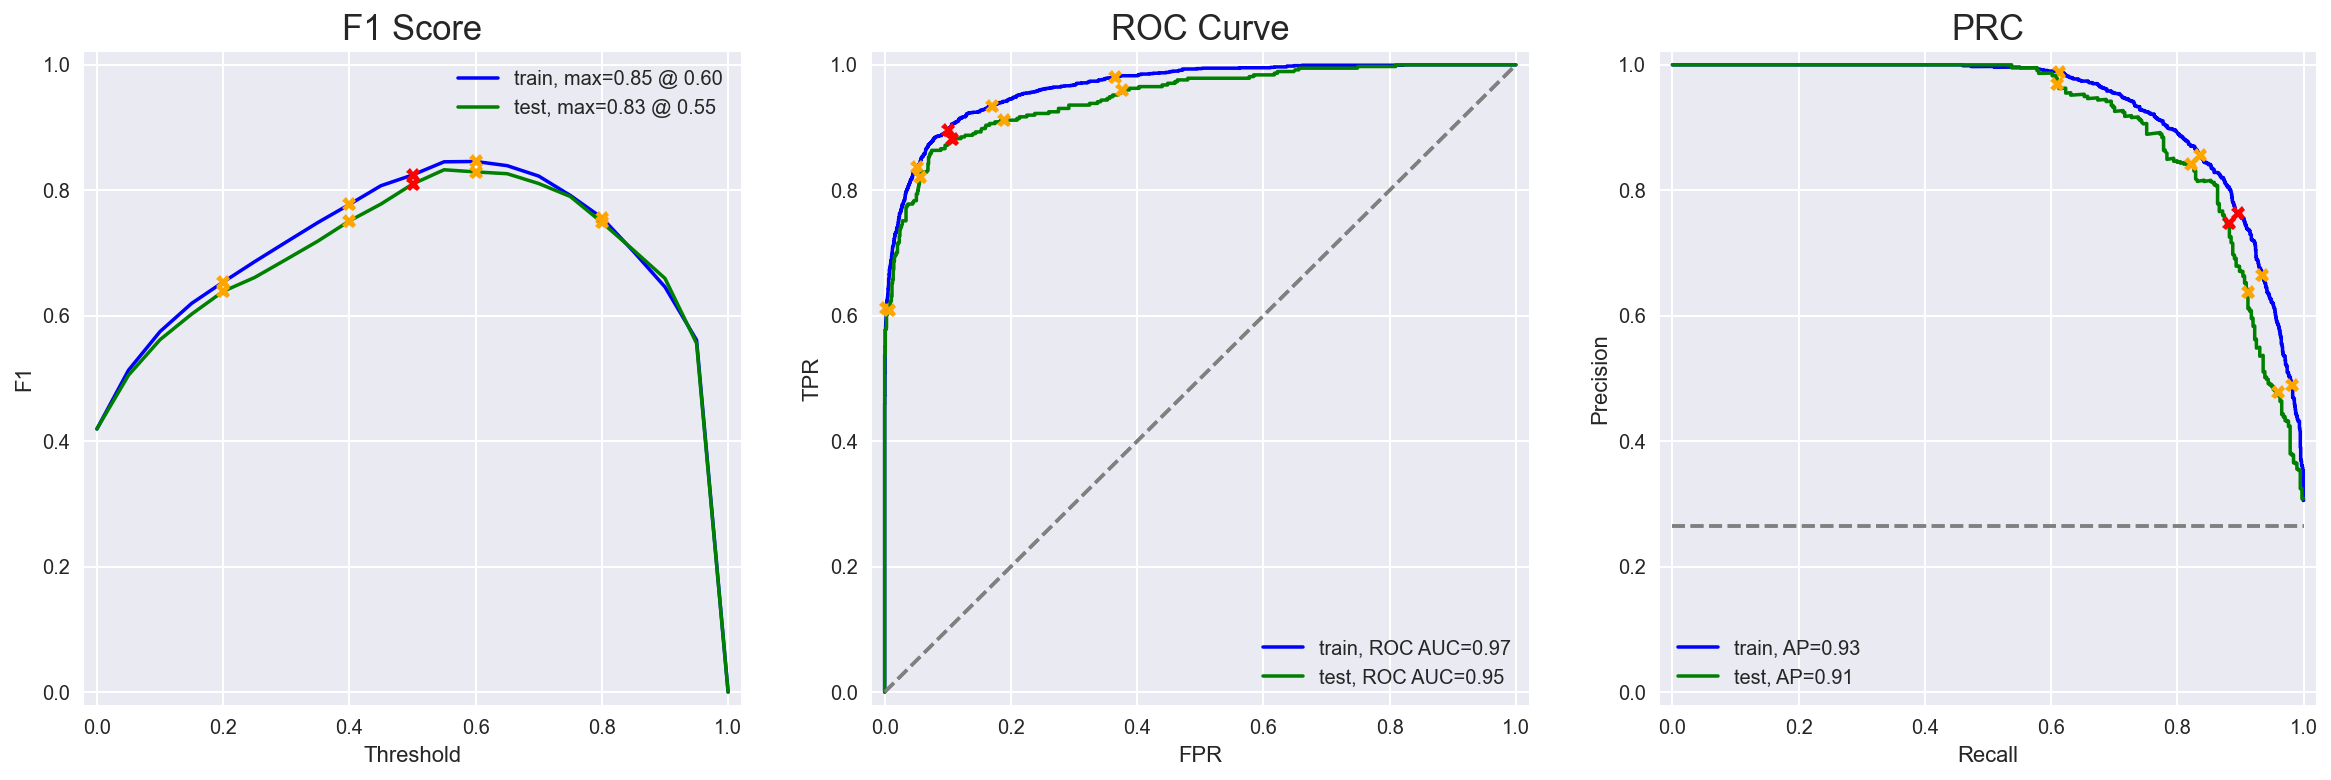

In [177]:
plot_curves(best_cb)

The model is slightly overfit.

##### Scores<a id="CB-Scores"></a>

In [178]:
best_scores(best_cb)

Name of experiment: cb_weighted_filtered
Best Recall:  0.882
Best ROC_AUC: 0.948


<br>

### Conclusions<a id="ML-Conclusions"></a>

In [179]:
best_scores()

In [180]:
print('lost customers: 44/{:,} ({:.2%})'.format(df['CustomerID'].nunique(), 44/df['CustomerID'].nunique()))

lost customers: 44/7,043 (0.62%)


The best scores were obtained by tuning a CatBoost model,  
Achieved an high recall score of 0.88 - which translates to lowest amount of false negatives (44 missed customers),  
and ROC_AUC on par with other boosting models.

Our best model's count of missed customers amounts to less than 1%.  
Whether that's acceptable or not is for the business to decide,  
but from the point of view of our model that's great.

<br>

## Project Conclusions
***

### Analysis Conclusions

We've parsed, cleaned and analysed the provided datasets.  
Observations:

- 'TotalCharges' had blank values, might better be represented by some other value rather than _blank_.
- Most binary features should probably be represented by either 1 or 0, and -1 if irrelevant (more efficient than 'Yes' / 'No' strings).
- We see a 1:3 imbalance of the engineered 'Churn' feature, which means a retention rate of roughly 75%.  
It is pretty good, and there's 25% room for improvement.
- Most churned clients have a month-to-month payment contract.  
Biannual contract clients churn less.
- Churned clients are also more likely to either be subscribed to Internet or telephone services, but not both.  
Clients who are subscribed to both seem to be less prone to leave.
- Fiber Internet clients pay more on average, but have roughly the same churn rates as their DSL counterparts.
- There are many more clients with lower monthly charges - than high paying monthly clients.  
They could be offered additional services to increase turnover.

By further analysis, we've also came to these conclusions:
1. 9.7% of customers can be offered a telephone line service,  
and 23% of customers can be offered to onboard a family member.  
In total, 32.7% of customers can be offered additional telephony services.

2. Almost all of the Internet customers have at least 1 internet service missing.  
96% of customers are relevant for targeted marketing of such services.

### Forecasting Conclusions

The work plan was mostly adhered to, with slight modifications to the order of appliance.  
We've split the data, set up pipelines,  
and trained models of various types (linear, decision trees, gradient boosting).

Also we've compared different combinations of balancing techniques and features encoding,  
while taking care of optimizing hyperparameters of the most promising models.

Some of the key steps to solving the task were to clean the data,  
and make it processable to components down the line (pipeline, encoders, ml model).  
Deciding which features have the most impact on each model,  
and how to properly encode them for the benefit of the model is another important step.  
Cross validation and hyperparameters tuning is what allowed us to squeeze our model and push it to its best.

Best performing models on our data were of Gradient Boosting type:
- The best model with regards to recall was CatBoost: 0.882 recall, 0.948 roc-auc.  
Furthermore, this model has the least amount of False Negatives (44),  
which are essentially missed clients who weren't contacted in an attempt to preserve them.  
Weakest model had 79 clients for comparison.
- The best model with regards to roc-auc was LightGBM: 0.874 recall, 0.959 roc-auc, and 47 false negatives.

Which I'd recommend depends on the preference of the telecommunications company  
with regards to false negatives / false positives tradeoff,  
but personally I'd go with least false negatives - the __CatBoost model__.

### Further Work
Some ideas that could potentially get us a better score, and push towards 99.9% :)

- Try to come up with more engineered features.
- Add back the internet services features.
- Try to remove other features.
- Principal Components Analysis (PCA)


- Different methods of over/under sampling (SMOTE).
- More exhaustive hyperparameters tuning methods, perhaps utilizing GPU for longer sessions.
- Experiment with Neural Networks